In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init
import sys

sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel

## Load and process the data

In [2]:
df_rndbkg = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5")

In [3]:
dt = df_rndbkg.values
correct = (dt[:,3]>0) &(dt[:,19]>0) & (dt[:,1]>0) & (dt[:,2]>0)
dt = dt[correct]

for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]

for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])
    

correct = (dt[:,0]>=2800)
dt = dt[correct]


#Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
idx = dt[:,-1]
bkg_idx = np.where(idx==0)[0]
signal_idx = np.where(idx==1)[0]
dt = dt[bkg_idx]
#Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
#Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]

In [4]:
dt.shape

(587907, 36)

In [5]:
Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [6]:
Y.shape

(587907, 12)

In [7]:
    
#if whichbkg == 'rndbkg':
#    dt = df_rndbkg.values
#    correct = (dt[:,3]>0) &(dt[:,19]>0) &(dt[:,1]>0) &(dt[:,2]>0)&(dt[:,16]>0)&(dt[:,32]>0)
#    dt = dt[correct]
#    for i in range(13,19):
#        dt[:,i] = dt[:,i]/dt[:,3]
#    
#    for i in range(29,35):
#        dt[:,i] = dt[:,i]/(dt[:,19])
#        
#    correct = (dt[:,16]>0) &(dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
#    dt = dt[correct]   
#    correct = (dt[:,0]>=2800)
#    dt = dt[correct]
#    #Y = dt[:,[3,4,5,6,11,12,19,20,21,22,27,28]]
#    idx = dt[:,-1]
#    bkg_idx = np.where(idx==0)[0]
#    signal_idx = np.where(idx==1)[0]
#    dt = dt[bkg_idx]
#    #Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]
#    Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]

In [8]:
bkg_mean = []
bkg_std = []

In [9]:
for i in range(12):
    mean = np.mean(Y[:,i])
    std = np.std(Y[:,i])
    bkg_mean.append(mean)
    bkg_std.append(std)
    Y[:,i] = (Y[:,i]-mean)/std

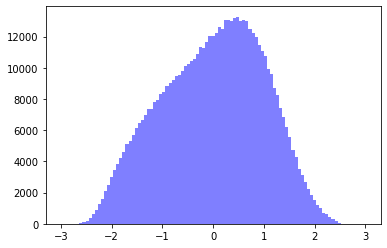

In [10]:
bins = np.linspace(-3,3,100)
bins.shape
column = 1
#print(f_rnd.columns[column])
#plt.ylim(0, 500)
plt.hist(Y[:,column],bins,alpha=0.5,color='b');
#plt.hist(sigout[:,column],bins,alpha=0.5,color='r');
#plt.hist(out2[:,column],bins,alpha=0.5,color='g');
#plt.axvline(np.mean(Y[:,column]))

In [11]:
bkg_mean

[229.63703733315916,
 0.5040889514020693,
 0.7057013083107537,
 0.7997482828680078,
 1.962088799505638,
 255.28311110430732,
 104.75378636669201,
 0.5826962213587913,
 0.7337977883611374,
 0.7995755223103627,
 2.4171146383976034,
 159.75951298419648]

# Do architecture optimization with beta, zdim, nflow 

# CHOOSE BEST ARCHITECTURE< TRY DIFFERENT NORMALIZING FLOW MODELS

In [12]:
bkg_std

[131.99460164832075,
 0.1849760683347428,
 0.12816197632833803,
 0.0865553075423761,
 0.7978444985340304,
 111.36202699158525,
 68.17314726646633,
 0.17458368821556094,
 0.11581000682757887,
 0.08481896882883566,
 1.1084488583498446,
 83.52566008451547]

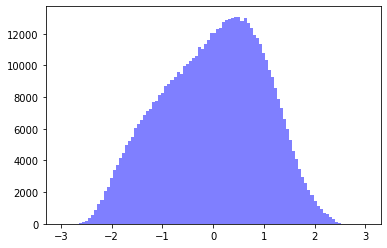

In [13]:
bins = np.linspace(-3,3,101)
plt.hist(Y[:,1],bins,alpha=0.5,color='b');

In [14]:
total_PureBkg = torch.tensor(Y)

total_PureBkg_selection = total_PureBkg

In [15]:
total_PureBkg_selection.shape

torch.Size([587907, 12])

In [16]:
bs = 800
bkgAE_train_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs, shuffle=True) 
bkgAE_test_iterator = utils.DataLoader(total_PureBkg_selection, batch_size=bs)

## Build the model

In [17]:
####MAF 
class VAE_NF(nn.Module):
    def __init__(self, K, D):
        super().__init__()
        self.dim = D
        self.K = K
        self.encoder = nn.Sequential(
            nn.Linear(12, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, D * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(D, 20),
            nn.LeakyReLU(True),
            nn.Linear(20, 30),
            nn.LeakyReLU(True),
            nn.Linear(30, 50),
            nn.LeakyReLU(True),
            nn.Linear(50, 12)
        )
        
        flow_init = MAF(dim=D)
        flows_init = [flow_init for _ in range(K)]
        prior = MultivariateNormal(torch.zeros(D).cuda(), torch.eye(D).cuda())
        self.flows = NormalizingFlowModel(prior, flows_init)

    def forward(self, x):
        # Run Encoder and get NF params
        enc = self.encoder(x)
        mu = enc[:, :self.dim]
        log_var = enc[:, self.dim: self.dim * 2]

        # Re-parametrize
        sigma = (log_var * .5).exp()
        z = mu + sigma * torch.randn_like(sigma)
        kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        # Construct more expressive posterior with NF
        
        z_k, _, sum_ladj = self.flows(z)
        
        kl_div = kl_div / x.size(0) - sum_ladj.mean()  # mean over batch

        # Run Decoder
        x_prime = self.decoder(z_k)
        return x_prime, kl_div

## Creating Instance¶

In [19]:
def train():
    global n_steps
    train_loss = []
    model.train()

    for batch_idx, x in enumerate(bkgAE_train_iterator):
        start_time = time.time()
        
        x = x.float().cuda()

        x_tilde, kl_div = model(x)
        
        
        
        mseloss = nn.MSELoss(size_average=False)
        
        huberloss = nn.SmoothL1Loss(size_average=False)
        

        #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
        loss_recons = mseloss(x_tilde,x ) / x.size(0)
        
        #loss_recons = huberloss(x_tilde,x ) / x.size(0)
        loss = loss_recons + beta * kl_div

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append([loss_recons.item(), kl_div.item()])

        if (batch_idx + 1) % PRINT_INTERVAL == 0:
            print('\tIter [{}/{} ({:.0f}%)]\tLoss: {} Time: {:5.3f} ms/batch beta:{}'.format(
                batch_idx * len(x), 50000,
                PRINT_INTERVAL * batch_idx / 50000,
                np.asarray(train_loss)[-PRINT_INTERVAL:].mean(0),
                1000 * (time.time() - start_time),
                beta
            
            ))

        n_steps += 1

In [20]:
def evaluate(split='valid'):
    global n_steps
    start_time = time.time()
    val_loss = []
    model.eval()

    with torch.no_grad():
        for batch_idx, x in enumerate(bkgAE_test_iterator):
            
            x = x.float().cuda()

            x_tilde, kl_div = model(x)
            mseloss = nn.MSELoss(size_average=False)
            #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            huberloss = nn.SmoothL1Loss(size_average=False)
        

            #loss_recons = F.binary_cross_entropy(x_tilde, x, size_average=False) / x.size(0)
            loss_recons = mseloss(x_tilde,x ) / x.size(0)
            #loss_recons = huberloss(x_tilde,x ) / x.size(0)
            loss = loss_recons + beta * kl_div

            val_loss.append(loss.item())
            #writer.add_scalar('loss/{}/ELBO'.format(split), loss.item(), n_steps)
            #writer.add_scalar('loss/{}/reconstruction'.format(split), loss_recons.item(), n_steps)
            #writer.add_scalar('loss/{}/KL'.format(split), kl_div.item(), n_steps)

    print('\nEvaluation Completed ({})!\tLoss: {:5.4f} Time: {:5.3f} s'.format(
        split,
        np.asarray(val_loss).mean(0),
        time.time() - start_time
    ))
    return np.asarray(val_loss).mean(0)

In [21]:
version = 1
zdim = [1,3,5,7,9,10]
nflow = [1,3,5,7,9,10]
lrs = [1e-3,1e-4,1e-5,1e-6,1e-7]
betas = [0.1,0.5,1.0,2.0,10.0]

version = 0
zdim = [2,4,6,8,10]
nflow = [2,4,6,8,10]
lrs = [1e-3,1e-4,1e-5,1e-6,1e-7]
betas = [0.1,0.5,1.0,2.0,10.0]

In [22]:
version = 0
zdim = [2,4,6,8,10]
nflow = [2,4,6,8,10]
lrs = [1e-3,1e-4,1e-5,1e-6,1e-7]
betas = [0.1,0.5,1.0,2.0,10.0]

In [43]:
N_EPOCHS = 30
PRINT_INTERVAL = 400
NUM_WORKERS = 4
n_steps = 0


LR = 1e-4
N_FLOWS = 1
Z_DIM = 8




In [44]:
import re

In [45]:
for Z_DIM in zdim:
    for N_FLOWS in nflow:
        for beta in betas:
            model = VAE_NF(N_FLOWS, Z_DIM).cuda()
            ae_def = {
                        "type":"bkg",
                        "trainon":"rndbkg",
                        "features":"12features",
                        "architecture":"MAF",
                        "selection":"mjjcut",
                        "trainloss":"MSELoss",
                        "beta":f"beta{re.sub('[.,]', 'p', str(beta))}",
                        "zdimnflow":f"z{Z_DIM}f{N_FLOWS}",
                        "version":f"ver{version}"
                
                     }

            BEST_LOSS = 999
            for LR in lrs:
                optimizer = optim.Adam(model.parameters(), lr=LR)
                LAST_SAVED = -1
                for epoch in range(1, 1000):
                    print("Epoch {}:".format(epoch))
                    train()
                    cur_loss = evaluate()

                    if cur_loss <= BEST_LOSS:
                        PATIENCE_COUNT = 0
                        BEST_LOSS = cur_loss
                        LAST_SAVED = epoch
                        print("Saving model!")
                        torch.save(model.state_dict(),f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_{ae_def['version']}.h5")

                    else:
                        PATIENCE_COUNT += 1
                        print("Not saving model! Last saved: {}".format(LAST_SAVED))
                        if PATIENCE_COUNT > 10:
                            print(f"############Patience Limit Reached with LR={LR}, Best Loss={BEST_LOSS}")
                            break 
                            
                model.load_state_dict(torch.load(f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_{ae_def['version']}.h5"))
                      


            

Epoch 1:
	Iter [319200/50000 (3%)]	Loss: [7.96258696 2.87802717] Time: 5.981 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 7.2318 Time: 2.099 s
Saving model!
Epoch 2:
	Iter [319200/50000 (3%)]	Loss: [ 7.62020842 -5.8372965 ] Time: 5.912 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 6.6040 Time: 2.101 s
Saving model!
Epoch 3:
	Iter [319200/50000 (3%)]	Loss: [  7.71702637 -10.54065135] Time: 5.982 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 6.6082 Time: 2.116 s
Not saving model! Last saved: 2
Epoch 4:
	Iter [319200/50000 (3%)]	Loss: [  7.6661367 -11.7081545] Time: 6.018 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 6.2950 Time: 2.115 s
Saving model!
Epoch 5:
	Iter [319200/50000 (3%)]	Loss: [10.23674099 -8.23642239] Time: 5.956 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 6.9019 Time: 2.117 s
Not saving model! Last saved: 4
Epoch 6:
	Iter [319200/50000 (3%)]	Loss: [ 7.6385121  -8.34086407] Time: 5.966 ms/batch beta:0.1

Evaluation Completed 

	Iter [319200/50000 (3%)]	Loss: [  7.59146625 -20.53702931] Time: 6.010 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.5206 Time: 2.098 s
Not saving model! Last saved: 23
Epoch 26:
	Iter [319200/50000 (3%)]	Loss: [  7.58180392 -20.64354387] Time: 5.928 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.5027 Time: 2.102 s
Not saving model! Last saved: 23
Epoch 27:
	Iter [319200/50000 (3%)]	Loss: [  7.56120293 -20.81049388] Time: 5.911 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.4861 Time: 2.098 s
Not saving model! Last saved: 23
Epoch 28:
	Iter [319200/50000 (3%)]	Loss: [  7.57578595 -21.01625159] Time: 5.920 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.4500 Time: 2.100 s
Saving model!
Epoch 29:
	Iter [319200/50000 (3%)]	Loss: [  7.59098708 -21.26018878] Time: 5.911 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.4283 Time: 2.098 s
Saving model!
Epoch 30:
	Iter [319200/50000 (3%)]	Loss: [  7.56537835 -21.53181597] Time: 5.974 ms/batch be

	Iter [319200/50000 (3%)]	Loss: [  7.56992307 -23.17998304] Time: 5.902 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.2331 Time: 2.123 s
Saving model!
Epoch 8:
	Iter [319200/50000 (3%)]	Loss: [  7.57077983 -23.3206582 ] Time: 5.898 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.2201 Time: 2.108 s
Saving model!
Epoch 9:
	Iter [319200/50000 (3%)]	Loss: [  7.55971707 -23.45415561] Time: 5.885 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.2109 Time: 2.100 s
Saving model!
Epoch 10:
	Iter [319200/50000 (3%)]	Loss: [  7.5482766  -23.60053181] Time: 5.891 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.1978 Time: 2.103 s
Saving model!
Epoch 11:
	Iter [319200/50000 (3%)]	Loss: [  7.56474644 -23.74081874] Time: 5.908 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.1882 Time: 2.100 s
Saving model!
Epoch 12:
	Iter [319200/50000 (3%)]	Loss: [  7.53960578 -23.87958868] Time: 5.914 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.1665 Time: 2.

	Iter [319200/50000 (3%)]	Loss: [  7.58140015 -28.45094106] Time: 6.105 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.7251 Time: 2.368 s
Saving model!
Epoch 55:
	Iter [319200/50000 (3%)]	Loss: [  7.59228202 -28.55422475] Time: 6.089 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.7145 Time: 2.345 s
Saving model!
Epoch 56:
	Iter [319200/50000 (3%)]	Loss: [  7.60595395 -28.64001093] Time: 6.040 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.7094 Time: 2.300 s
Saving model!
Epoch 57:
	Iter [319200/50000 (3%)]	Loss: [  7.59229416 -28.72052335] Time: 6.098 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.7002 Time: 2.140 s
Saving model!
Epoch 58:
	Iter [319200/50000 (3%)]	Loss: [  7.71155593 -28.80428294] Time: 5.918 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.6888 Time: 2.106 s
Saving model!
Epoch 59:
	Iter [319200/50000 (3%)]	Loss: [  7.57045276 -28.82356577] Time: 5.947 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.6889 Time: 

	Iter [319200/50000 (3%)]	Loss: [  8.3740316  -29.87287777] Time: 5.935 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.5870 Time: 2.109 s
Not saving model! Last saved: 97
Epoch 101:
	Iter [319200/50000 (3%)]	Loss: [  7.57027376 -29.8551862 ] Time: 5.930 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.5835 Time: 2.111 s
Not saving model! Last saved: 97
Epoch 102:
	Iter [319200/50000 (3%)]	Loss: [  7.57554037 -29.84385167] Time: 5.902 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.5791 Time: 2.106 s
Saving model!
Epoch 103:
	Iter [319200/50000 (3%)]	Loss: [  7.5771733  -29.84981526] Time: 5.933 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.5791 Time: 2.101 s
Saving model!
Epoch 104:
	Iter [319200/50000 (3%)]	Loss: [  7.58167341 -29.87263761] Time: 5.918 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.5770 Time: 2.104 s
Saving model!
Epoch 105:
	Iter [319200/50000 (3%)]	Loss: [  7.60617826 -29.90635443] Time: 5.923 ms/batch beta:0.1

Evalua


Evaluation Completed (valid)!	Loss: 4.5463 Time: 2.099 s
Not saving model! Last saved: 143
Epoch 145:
	Iter [319200/50000 (3%)]	Loss: [  7.57268105 -30.34772606] Time: 5.896 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.5303 Time: 2.122 s
Not saving model! Last saved: 143
Epoch 146:
	Iter [319200/50000 (3%)]	Loss: [  7.58491789 -30.36859478] Time: 5.908 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.5486 Time: 2.100 s
Not saving model! Last saved: 143
Epoch 147:
	Iter [319200/50000 (3%)]	Loss: [  8.93046291 -30.40635544] Time: 5.895 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.5779 Time: 2.102 s
Not saving model! Last saved: 143
Epoch 148:
	Iter [319200/50000 (3%)]	Loss: [  7.58175334 -30.38350204] Time: 6.074 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.5441 Time: 2.103 s
Not saving model! Last saved: 143
Epoch 149:
	Iter [319200/50000 (3%)]	Loss: [  7.58243556 -30.37427248] Time: 5.896 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss


Evaluation Completed (valid)!	Loss: 4.4952 Time: 2.143 s
Not saving model! Last saved: 182
Epoch 189:
	Iter [319200/50000 (3%)]	Loss: [  7.57026678 -30.75404398] Time: 6.058 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4907 Time: 2.106 s
Saving model!
Epoch 190:
	Iter [319200/50000 (3%)]	Loss: [  7.57365998 -30.75871035] Time: 6.072 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.5024 Time: 2.139 s
Not saving model! Last saved: 189
Epoch 191:
	Iter [319200/50000 (3%)]	Loss: [  7.55479884 -30.75559989] Time: 6.119 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4910 Time: 2.136 s
Not saving model! Last saved: 189
Epoch 192:
	Iter [319200/50000 (3%)]	Loss: [  7.56528739 -30.76523208] Time: 6.006 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.5012 Time: 2.150 s
Not saving model! Last saved: 189
Epoch 193:
	Iter [319200/50000 (3%)]	Loss: [  7.57447705 -30.76855061] Time: 6.005 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4984 Time: 2.116

	Iter [319200/50000 (3%)]	Loss: [  7.70778165 -31.08825884] Time: 5.924 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.5592 Time: 2.100 s
Not saving model! Last saved: 225
Epoch 233:
	Iter [319200/50000 (3%)]	Loss: [  7.60978836 -31.08098285] Time: 5.936 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4916 Time: 2.101 s
Not saving model! Last saved: 225
Epoch 234:
	Iter [319200/50000 (3%)]	Loss: [  7.59962162 -31.07042108] Time: 5.926 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4789 Time: 2.106 s
Not saving model! Last saved: 225
Epoch 235:
	Iter [319200/50000 (3%)]	Loss: [  7.57719429 -31.06107886] Time: 7.236 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4915 Time: 2.108 s
Not saving model! Last saved: 225
Epoch 236:
	Iter [319200/50000 (3%)]	Loss: [  7.58650217 -31.07235171] Time: 5.927 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4563 Time: 2.116 s
Saving model!
Epoch 237:
	Iter [319200/50000 (3%)]	Loss: [  7.58205375 -31.07082


Evaluation Completed (valid)!	Loss: 4.4059 Time: 2.104 s
Saving model!
Epoch 30:
	Iter [319200/50000 (3%)]	Loss: [  7.56476598 -31.52250234] Time: 5.957 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4050 Time: 2.103 s
Saving model!
Epoch 31:
	Iter [319200/50000 (3%)]	Loss: [  7.55707499 -31.53944813] Time: 5.904 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4043 Time: 2.107 s
Saving model!
Epoch 32:
	Iter [319200/50000 (3%)]	Loss: [  7.54625831 -31.55734097] Time: 5.914 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4013 Time: 3.961 s
Saving model!
Epoch 33:
	Iter [319200/50000 (3%)]	Loss: [  7.55320202 -31.57970732] Time: 5.983 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4271 Time: 2.102 s
Not saving model! Last saved: 32
Epoch 34:
	Iter [319200/50000 (3%)]	Loss: [  7.54456259 -31.59456275] Time: 6.002 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3995 Time: 2.122 s
Saving model!
Epoch 35:
	Iter [319200/50000 (3%)]	Loss: [  7.55


Evaluation Completed (valid)!	Loss: 4.3783 Time: 2.100 s
Not saving model! Last saved: 74
Epoch 76:
	Iter [319200/50000 (3%)]	Loss: [  7.5435723  -32.21959884] Time: 5.954 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3477 Time: 2.104 s
Not saving model! Last saved: 74
Epoch 77:
	Iter [319200/50000 (3%)]	Loss: [  7.58184106 -32.23348275] Time: 5.960 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3361 Time: 2.105 s
Saving model!
Epoch 78:
	Iter [319200/50000 (3%)]	Loss: [  7.56406661 -32.24800385] Time: 5.963 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3332 Time: 2.108 s
Saving model!
Epoch 79:
	Iter [319200/50000 (3%)]	Loss: [  7.56889139 -32.2580179 ] Time: 5.981 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3327 Time: 2.109 s
Saving model!
Epoch 80:
	Iter [319200/50000 (3%)]	Loss: [  7.58140526 -32.27274192] Time: 6.006 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3326 Time: 2.111 s
Saving model!
Epoch 81:
	Iter [319200/50000 

	Iter [319200/50000 (3%)]	Loss: [  7.55317469 -32.84420924] Time: 5.969 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2785 Time: 2.100 s
Saving model!
Epoch 122:
	Iter [319200/50000 (3%)]	Loss: [  7.5450972  -32.85578552] Time: 5.991 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2740 Time: 2.107 s
Saving model!
Epoch 123:
	Iter [319200/50000 (3%)]	Loss: [  7.58556127 -32.87030252] Time: 5.921 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2789 Time: 2.110 s
Not saving model! Last saved: 122
Epoch 124:
	Iter [319200/50000 (3%)]	Loss: [  7.58728713 -32.88346966] Time: 5.929 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2714 Time: 2.110 s
Saving model!
Epoch 125:
	Iter [319200/50000 (3%)]	Loss: [  7.55306121 -32.89948372] Time: 5.919 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2739 Time: 2.108 s
Not saving model! Last saved: 124
Epoch 126:
	Iter [319200/50000 (3%)]	Loss: [  7.56856341 -32.91576519] Time: 5.931 ms/batch beta:0.1

Eval

	Iter [319200/50000 (3%)]	Loss: [  7.56786761 -33.44941445] Time: 6.162 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2254 Time: 2.149 s
Not saving model! Last saved: 165
Epoch 167:
	Iter [319200/50000 (3%)]	Loss: [  7.57349177 -33.46018954] Time: 6.149 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2173 Time: 2.180 s
Not saving model! Last saved: 165
Epoch 168:
	Iter [319200/50000 (3%)]	Loss: [  7.5371308  -33.47280072] Time: 6.106 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2176 Time: 2.148 s
Not saving model! Last saved: 165
Epoch 169:
	Iter [319200/50000 (3%)]	Loss: [  7.56448925 -33.48577483] Time: 6.097 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2165 Time: 2.152 s
Saving model!
Epoch 170:
	Iter [319200/50000 (3%)]	Loss: [  7.55621433 -33.49653695] Time: 6.139 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2127 Time: 2.149 s
Saving model!
Epoch 171:
	Iter [319200/50000 (3%)]	Loss: [  7.56292621 -33.50945912] Time: 6.112 ms/

	Iter [319200/50000 (3%)]	Loss: [  7.57903469 -34.01200044] Time: 6.055 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.1651 Time: 2.171 s
Saving model!
Epoch 212:
	Iter [319200/50000 (3%)]	Loss: [  7.57814039 -34.02702093] Time: 6.203 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.1651 Time: 2.146 s
Not saving model! Last saved: 211
Epoch 213:
	Iter [319200/50000 (3%)]	Loss: [  7.56755902 -34.04107952] Time: 6.094 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.1585 Time: 2.153 s
Saving model!
Epoch 214:
	Iter [319200/50000 (3%)]	Loss: [  7.56074679 -34.05361531] Time: 6.098 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.1655 Time: 2.145 s
Not saving model! Last saved: 213
Epoch 215:
	Iter [319200/50000 (3%)]	Loss: [  7.56151575 -34.06573259] Time: 6.104 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.1664 Time: 2.154 s
Not saving model! Last saved: 213
Epoch 216:
	Iter [319200/50000 (3%)]	Loss: [  7.54546376 -34.08209637] Time: 6.071 ms/


Evaluation Completed (valid)!	Loss: 4.1330 Time: 2.120 s
Not saving model! Last saved: 254
Epoch 256:
	Iter [319200/50000 (3%)]	Loss: [  7.59256912 -34.56662055] Time: 6.042 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.1141 Time: 2.121 s
Saving model!
Epoch 257:
	Iter [319200/50000 (3%)]	Loss: [  7.57330435 -34.57903236] Time: 6.030 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.1074 Time: 2.123 s
Saving model!
Epoch 258:
	Iter [319200/50000 (3%)]	Loss: [  7.57827323 -34.58898856] Time: 6.002 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.1110 Time: 2.146 s
Not saving model! Last saved: 257
Epoch 259:
	Iter [319200/50000 (3%)]	Loss: [  7.57577106 -34.60242091] Time: 5.994 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.1108 Time: 2.123 s
Not saving model! Last saved: 257
Epoch 260:
	Iter [319200/50000 (3%)]	Loss: [  7.56807529 -34.61339557] Time: 5.992 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.1050 Time: 2.119 s
Saving model!
Epo


Evaluation Completed (valid)!	Loss: 4.0654 Time: 2.138 s
Not saving model! Last saved: 297
Epoch 301:
	Iter [319200/50000 (3%)]	Loss: [  7.56805591 -35.09859594] Time: 5.975 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0570 Time: 2.465 s
Saving model!
Epoch 302:
	Iter [319200/50000 (3%)]	Loss: [  7.58928284 -35.10882121] Time: 5.925 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0715 Time: 2.289 s
Not saving model! Last saved: 301
Epoch 303:
	Iter [319200/50000 (3%)]	Loss: [  7.5729444  -35.12374436] Time: 5.934 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0555 Time: 2.102 s
Saving model!
Epoch 304:
	Iter [319200/50000 (3%)]	Loss: [  7.57178833 -35.13510539] Time: 5.920 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0554 Time: 2.255 s
Saving model!
Epoch 305:
	Iter [319200/50000 (3%)]	Loss: [  7.57671654 -35.14346859] Time: 5.929 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0666 Time: 2.124 s
Not saving model! Last saved: 304
Epo


Evaluation Completed (valid)!	Loss: 4.0156 Time: 2.115 s
Not saving model! Last saved: 343
Epoch 345:
	Iter [319200/50000 (3%)]	Loss: [  7.5633628  -35.59107429] Time: 5.993 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0075 Time: 2.113 s
Saving model!
Epoch 346:
	Iter [319200/50000 (3%)]	Loss: [  7.56461014 -35.60398996] Time: 5.987 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0188 Time: 2.115 s
Not saving model! Last saved: 345
Epoch 347:
	Iter [319200/50000 (3%)]	Loss: [  7.59605231 -35.61420929] Time: 5.922 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0109 Time: 2.117 s
Not saving model! Last saved: 345
Epoch 348:
	Iter [319200/50000 (3%)]	Loss: [  7.57479358 -35.62535522] Time: 5.995 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0057 Time: 2.115 s
Saving model!
Epoch 349:
	Iter [319200/50000 (3%)]	Loss: [  7.59312136 -35.63462565] Time: 5.983 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0104 Time: 2.142 s
Not saving model!

	Iter [319200/50000 (3%)]	Loss: [  7.56846829 -36.07034918] Time: 5.913 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.9729 Time: 2.110 s
Not saving model! Last saved: 388
Epoch 390:
	Iter [319200/50000 (3%)]	Loss: [  7.57649108 -36.08018424] Time: 5.918 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.9714 Time: 2.111 s
Not saving model! Last saved: 388
Epoch 391:
	Iter [319200/50000 (3%)]	Loss: [  7.57566626 -36.09103956] Time: 5.979 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.9612 Time: 2.109 s
Saving model!
Epoch 392:
	Iter [319200/50000 (3%)]	Loss: [  7.58501845 -36.09776158] Time: 5.907 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.9550 Time: 2.107 s
Saving model!
Epoch 393:
	Iter [319200/50000 (3%)]	Loss: [  7.589076   -36.11171071] Time: 5.958 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.9606 Time: 2.098 s
Not saving model! Last saved: 392
Epoch 394:
	Iter [319200/50000 (3%)]	Loss: [  7.56566813 -36.12287774] Time: 6.045 ms/

	Iter [319200/50000 (3%)]	Loss: [  7.56955047 -36.51478136] Time: 5.976 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.9187 Time: 2.127 s
Not saving model! Last saved: 431
Epoch 434:
	Iter [319200/50000 (3%)]	Loss: [  7.58772133 -36.52887912] Time: 5.932 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.9267 Time: 2.104 s
Not saving model! Last saved: 431
Epoch 435:
	Iter [319200/50000 (3%)]	Loss: [  7.59200068 -36.53704947] Time: 5.932 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.9212 Time: 2.110 s
Not saving model! Last saved: 431
Epoch 436:
	Iter [319200/50000 (3%)]	Loss: [  7.58593244 -36.55043341] Time: 5.925 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.9197 Time: 2.108 s
Not saving model! Last saved: 431
Epoch 437:
	Iter [319200/50000 (3%)]	Loss: [  7.57075479 -36.5615227 ] Time: 5.934 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.9124 Time: 2.109 s
Saving model!
Epoch 438:
	Iter [319200/50000 (3%)]	Loss: [  7.58102459 -36.57029


Evaluation Completed (valid)!	Loss: 3.8775 Time: 2.129 s
Saving model!
Epoch 4:
	Iter [319200/50000 (3%)]	Loss: [  7.54840801 -36.81959822] Time: 6.042 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8782 Time: 2.108 s
Not saving model! Last saved: 3
Epoch 5:
	Iter [319200/50000 (3%)]	Loss: [  7.56320969 -36.8172603 ] Time: 5.971 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8787 Time: 2.111 s
Not saving model! Last saved: 3
Epoch 6:
	Iter [319200/50000 (3%)]	Loss: [  7.5637044  -36.81925556] Time: 5.944 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8770 Time: 2.110 s
Saving model!
Epoch 7:
	Iter [319200/50000 (3%)]	Loss: [  7.56265309 -36.81930162] Time: 5.960 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8785 Time: 2.136 s
Not saving model! Last saved: 6
Epoch 8:
	Iter [319200/50000 (3%)]	Loss: [  7.55946366 -36.81671394] Time: 5.944 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8779 Time: 2.112 s
Not saving model! Last saved: 6
E


Evaluation Completed (valid)!	Loss: 3.8734 Time: 2.113 s
Saving model!
Epoch 48:
	Iter [319200/50000 (3%)]	Loss: [  7.56915926 -36.84504375] Time: 5.932 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8743 Time: 2.103 s
Not saving model! Last saved: 47
Epoch 49:
	Iter [319200/50000 (3%)]	Loss: [  7.54144909 -36.84433114] Time: 5.975 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8750 Time: 2.100 s
Not saving model! Last saved: 47
Epoch 50:
	Iter [319200/50000 (3%)]	Loss: [  7.5598969  -36.84650449] Time: 6.029 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8752 Time: 2.102 s
Not saving model! Last saved: 47
Epoch 51:
	Iter [319200/50000 (3%)]	Loss: [  7.55804386 -36.84672062] Time: 5.926 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8791 Time: 2.101 s
Not saving model! Last saved: 47
Epoch 52:
	Iter [319200/50000 (3%)]	Loss: [  7.56061868 -36.84707368] Time: 5.944 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8743 Time: 2.101 s
Not sa


Evaluation Completed (valid)!	Loss: 3.8710 Time: 2.126 s
Not saving model! Last saved: 89
Epoch 92:
	Iter [319200/50000 (3%)]	Loss: [  7.56023437 -36.87776529] Time: 5.924 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8710 Time: 2.107 s
Not saving model! Last saved: 89
Epoch 93:
	Iter [319200/50000 (3%)]	Loss: [  7.54763126 -36.87855445] Time: 7.279 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8706 Time: 2.106 s
Not saving model! Last saved: 89
Epoch 94:
	Iter [319200/50000 (3%)]	Loss: [  7.54879798 -36.88080725] Time: 5.935 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8715 Time: 2.111 s
Not saving model! Last saved: 89
Epoch 95:
	Iter [319200/50000 (3%)]	Loss: [  7.57113192 -36.87839784] Time: 6.016 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8703 Time: 2.108 s
Saving model!
Epoch 96:
	Iter [319200/50000 (3%)]	Loss: [  7.56204093 -36.8799922 ] Time: 5.974 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8717 Time: 2.114 s
Not sa


Evaluation Completed (valid)!	Loss: 3.8671 Time: 2.113 s
Saving model!
Epoch 136:
	Iter [319200/50000 (3%)]	Loss: [  7.57412013 -36.91048403] Time: 5.993 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8671 Time: 2.098 s
Not saving model! Last saved: 135
Epoch 137:
	Iter [319200/50000 (3%)]	Loss: [  7.5517227  -36.91525649] Time: 5.918 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8674 Time: 2.105 s
Not saving model! Last saved: 135
Epoch 138:
	Iter [319200/50000 (3%)]	Loss: [  7.57099869 -36.91185049] Time: 5.991 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8681 Time: 2.126 s
Not saving model! Last saved: 135
Epoch 139:
	Iter [319200/50000 (3%)]	Loss: [  7.55957278 -36.9156882 ] Time: 5.971 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8670 Time: 2.106 s
Saving model!
Epoch 140:
	Iter [319200/50000 (3%)]	Loss: [  7.54939496 -36.91634305] Time: 7.376 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8675 Time: 2.109 s
Not saving model!

	Iter [319200/50000 (3%)]	Loss: [  7.56189732 -36.94416937] Time: 5.918 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8642 Time: 2.112 s
Not saving model! Last saved: 175
Epoch 180:
	Iter [319200/50000 (3%)]	Loss: [  7.58166847 -36.94190424] Time: 5.951 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8640 Time: 2.109 s
Saving model!
Epoch 181:
	Iter [319200/50000 (3%)]	Loss: [  7.55300823 -36.94512221] Time: 5.906 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8657 Time: 2.115 s
Not saving model! Last saved: 180
Epoch 182:
	Iter [319200/50000 (3%)]	Loss: [  7.56666757 -36.94474271] Time: 5.900 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8639 Time: 2.120 s
Saving model!
Epoch 183:
	Iter [319200/50000 (3%)]	Loss: [  7.56411981 -36.94460235] Time: 5.915 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8648 Time: 2.101 s
Not saving model! Last saved: 182
Epoch 184:
	Iter [319200/50000 (3%)]	Loss: [  7.5684311  -36.94599625] Time: 5.908 ms/

	Iter [319200/50000 (3%)]	Loss: [  7.54872141 -36.97802299] Time: 5.901 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8622 Time: 2.107 s
Not saving model! Last saved: 218
Epoch 224:
	Iter [319200/50000 (3%)]	Loss: [  7.56427485 -36.97700566] Time: 5.920 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8603 Time: 2.109 s
Saving model!
Epoch 225:
	Iter [319200/50000 (3%)]	Loss: [  7.56485366 -36.97746174] Time: 5.908 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8633 Time: 2.111 s
Not saving model! Last saved: 224
Epoch 226:
	Iter [319200/50000 (3%)]	Loss: [  7.53550195 -36.98054022] Time: 5.901 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8626 Time: 2.112 s
Not saving model! Last saved: 224
Epoch 227:
	Iter [319200/50000 (3%)]	Loss: [  7.54896613 -36.98192955] Time: 5.907 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8632 Time: 2.114 s
Not saving model! Last saved: 224
Epoch 228:
	Iter [319200/50000 (3%)]	Loss: [  7.5674903  -36.98130


Evaluation Completed (valid)!	Loss: -2.9447 Time: 2.134 s
Saving model!
Epoch 10:
	Iter [319200/50000 (3%)]	Loss: [  8.04527218 -21.8984974 ] Time: 6.024 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -2.8814 Time: 2.111 s
Not saving model! Last saved: 9
Epoch 11:
	Iter [319200/50000 (3%)]	Loss: [  8.09171727 -22.10348722] Time: 5.978 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -3.1085 Time: 2.109 s
Saving model!
Epoch 12:
	Iter [319200/50000 (3%)]	Loss: [  8.01840574 -22.30026878] Time: 6.016 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -3.2458 Time: 2.111 s
Saving model!
Epoch 13:
	Iter [319200/50000 (3%)]	Loss: [  8.003068   -22.54307182] Time: 6.092 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -3.3571 Time: 2.112 s
Saving model!
Epoch 14:
	Iter [319200/50000 (3%)]	Loss: [  8.00548908 -22.85893692] Time: 6.002 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -3.5822 Time: 2.118 s
Saving model!
Epoch 15:
	Iter [319200/50000 (3%)]	Loss: [ 

	Iter [319200/50000 (3%)]	Loss: [  7.97511998 -25.52088773] Time: 6.011 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -4.8374 Time: 2.115 s
Saving model!
Epoch 6:
	Iter [319200/50000 (3%)]	Loss: [  7.97962201 -25.6625568 ] Time: 5.987 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -4.9073 Time: 2.116 s
Saving model!
Epoch 7:
	Iter [319200/50000 (3%)]	Loss: [  7.98375684 -25.80805758] Time: 5.988 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -4.9725 Time: 2.128 s
Saving model!
Epoch 8:
	Iter [319200/50000 (3%)]	Loss: [  7.97600524 -25.95049417] Time: 5.998 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -5.0461 Time: 2.101 s
Saving model!
Epoch 9:
	Iter [319200/50000 (3%)]	Loss: [  7.97548206 -26.09158697] Time: 5.990 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -5.1289 Time: 2.106 s
Saving model!
Epoch 10:
	Iter [319200/50000 (3%)]	Loss: [  7.98034826 -26.23377941] Time: 5.984 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -5.1957 Time


Evaluation Completed (valid)!	Loss: -7.4273 Time: 2.118 s
Saving model!
Epoch 53:
	Iter [319200/50000 (3%)]	Loss: [ 12.34255081 -30.86352973] Time: 5.989 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.3982 Time: 2.111 s
Not saving model! Last saved: 52
Epoch 54:
	Iter [319200/50000 (3%)]	Loss: [  8.0346395  -30.86270864] Time: 6.005 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.4328 Time: 2.135 s
Saving model!
Epoch 55:
	Iter [319200/50000 (3%)]	Loss: [  8.00677979 -30.86221936] Time: 5.993 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.4272 Time: 2.110 s
Not saving model! Last saved: 54
Epoch 56:
	Iter [319200/50000 (3%)]	Loss: [  8.00314246 -30.85837157] Time: 5.977 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.4552 Time: 2.110 s
Saving model!
Epoch 57:
	Iter [319200/50000 (3%)]	Loss: [  7.986194   -30.86467057] Time: 5.944 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.4338 Time: 2.110 s
Not saving model! Last saved: 56
Epoch

	Iter [319200/50000 (3%)]	Loss: [  8.01961207 -32.11258119] Time: 5.998 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.0692 Time: 2.101 s
Saving model!
Epoch 99:
	Iter [319200/50000 (3%)]	Loss: [  8.06651643 -32.16493571] Time: 5.957 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.0446 Time: 2.108 s
Not saving model! Last saved: 98
Epoch 100:
	Iter [319200/50000 (3%)]	Loss: [  8.01498295 -32.16548503] Time: 5.948 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.9663 Time: 2.107 s
Not saving model! Last saved: 98
Epoch 101:
	Iter [319200/50000 (3%)]	Loss: [  8.04975    -32.16160975] Time: 5.979 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.9816 Time: 2.142 s
Not saving model! Last saved: 98
Epoch 102:
	Iter [319200/50000 (3%)]	Loss: [  8.03986822 -32.16013263] Time: 5.946 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.0435 Time: 2.110 s
Not saving model! Last saved: 98
Epoch 103:
	Iter [319200/50000 (3%)]	Loss: [  8.03920707 -32.15843


Evaluation Completed (valid)!	Loss: -8.3795 Time: 2.095 s
Saving model!
Epoch 143:
	Iter [319200/50000 (3%)]	Loss: [  7.96333095 -32.70349762] Time: 5.970 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.3724 Time: 2.103 s
Not saving model! Last saved: 142
Epoch 144:
	Iter [319200/50000 (3%)]	Loss: [  7.97778545 -32.7176154 ] Time: 6.120 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.3946 Time: 2.098 s
Saving model!
Epoch 145:
	Iter [319200/50000 (3%)]	Loss: [  7.98922348 -32.74596131] Time: 6.029 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.3916 Time: 2.128 s
Not saving model! Last saved: 144
Epoch 146:
	Iter [319200/50000 (3%)]	Loss: [  7.97730672 -32.7875287 ] Time: 6.055 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.3942 Time: 2.137 s
Not saving model! Last saved: 144
Epoch 147:
	Iter [319200/50000 (3%)]	Loss: [  8.02551387 -32.83878335] Time: 6.037 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: 13.0770 Time: 2.135 s
Not saving 

	Iter [319200/50000 (3%)]	Loss: [  8.02585327 -33.21807281] Time: 5.963 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.5748 Time: 2.133 s
Not saving model! Last saved: 183
Epoch 188:
	Iter [319200/50000 (3%)]	Loss: [  8.03822054 -33.21802785] Time: 5.996 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.5699 Time: 2.093 s
Not saving model! Last saved: 183
Epoch 189:
	Iter [319200/50000 (3%)]	Loss: [  8.04639923 -33.21841819] Time: 6.021 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.6068 Time: 2.096 s
Not saving model! Last saved: 183
Epoch 190:
	Iter [319200/50000 (3%)]	Loss: [  8.02645069 -33.21429323] Time: 6.415 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.5957 Time: 2.101 s
Not saving model! Last saved: 183
Epoch 191:
	Iter [319200/50000 (3%)]	Loss: [  8.02609895 -33.21182103] Time: 5.985 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.6185 Time: 2.104 s
Saving model!
Epoch 192:
	Iter [319200/50000 (3%)]	Loss: [  8.00817316 -33.

	Iter [319200/50000 (3%)]	Loss: [  7.97921354 -33.52810835] Time: 5.959 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.7672 Time: 2.110 s
Not saving model! Last saved: 229
Epoch 232:
	Iter [319200/50000 (3%)]	Loss: [  8.00369006 -33.52754015] Time: 5.947 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.7376 Time: 2.107 s
Not saving model! Last saved: 229
Epoch 233:
	Iter [319200/50000 (3%)]	Loss: [  8.01525454 -33.52621339] Time: 5.950 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.7038 Time: 2.112 s
Not saving model! Last saved: 229
Epoch 234:
	Iter [319200/50000 (3%)]	Loss: [  8.00268777 -33.5096283 ] Time: 6.028 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.7389 Time: 2.110 s
Not saving model! Last saved: 229
Epoch 235:
	Iter [319200/50000 (3%)]	Loss: [  8.04330688 -33.5246988 ] Time: 5.981 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.7170 Time: 2.112 s
Not saving model! Last saved: 229
Epoch 236:
	Iter [319200/50000 (3%)]	Loss


Evaluation Completed (valid)!	Loss: -8.8590 Time: 2.123 s
Not saving model! Last saved: 268
Epoch 275:
	Iter [319200/50000 (3%)]	Loss: [  8.00801971 -33.73821286] Time: 6.034 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.8602 Time: 2.132 s
Not saving model! Last saved: 268
Epoch 276:
	Iter [319200/50000 (3%)]	Loss: [  8.0054907 -33.7365422] Time: 6.046 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.8816 Time: 2.153 s
Saving model!
Epoch 277:
	Iter [319200/50000 (3%)]	Loss: [  7.98183682 -33.73653427] Time: 6.041 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.8834 Time: 2.136 s
Saving model!
Epoch 278:
	Iter [319200/50000 (3%)]	Loss: [  7.98617857 -33.7375854 ] Time: 6.025 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.8892 Time: 2.134 s
Saving model!
Epoch 279:
	Iter [319200/50000 (3%)]	Loss: [  7.98595057 -33.74359333] Time: 6.032 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.8695 Time: 2.134 s
Not saving model! Last saved: 278


Evaluation Completed (valid)!	Loss: -8.9539 Time: 2.145 s
Not saving model! Last saved: 317
Epoch 319:
	Iter [319200/50000 (3%)]	Loss: [  8.00087234 -33.91958018] Time: 6.031 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.8890 Time: 2.138 s
Not saving model! Last saved: 317
Epoch 320:
	Iter [319200/50000 (3%)]	Loss: [  8.03693923 -33.92417702] Time: 6.069 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.9692 Time: 2.111 s
Saving model!
Epoch 321:
	Iter [319200/50000 (3%)]	Loss: [  8.07406132 -33.92526259] Time: 5.967 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.8718 Time: 2.109 s
Not saving model! Last saved: 320
Epoch 322:
	Iter [319200/50000 (3%)]	Loss: [  8.05614299 -33.92465933] Time: 5.918 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.8566 Time: 2.109 s
Not saving model! Last saved: 320
Epoch 323:
	Iter [319200/50000 (3%)]	Loss: [  8.07446201 -33.92442705] Time: 5.926 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.9678 Time:


Evaluation Completed (valid)!	Loss: -9.0351 Time: 2.222 s
Not saving model! Last saved: 361
Epoch 363:
	Iter [319200/50000 (3%)]	Loss: [  8.10156381 -34.14329699] Time: 5.990 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.6722 Time: 2.446 s
Not saving model! Last saved: 361
Epoch 364:
	Iter [319200/50000 (3%)]	Loss: [  8.22421742 -34.14506567] Time: 5.922 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.0080 Time: 2.347 s
Not saving model! Last saved: 361
Epoch 365:
	Iter [319200/50000 (3%)]	Loss: [  8.11028636 -34.14519349] Time: 5.936 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.9522 Time: 2.099 s
Not saving model! Last saved: 361
Epoch 366:
	Iter [319200/50000 (3%)]	Loss: [  8.06268562 -34.14547717] Time: 5.900 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.0011 Time: 2.572 s
Not saving model! Last saved: 361
Epoch 367:
	Iter [319200/50000 (3%)]	Loss: [  8.04381643 -34.14338166] Time: 5.926 ms/batch beta:0.5

Evaluation Completed (valid)!


Evaluation Completed (valid)!	Loss: -9.1530 Time: 2.111 s
Saving model!
Epoch 9:
	Iter [319200/50000 (3%)]	Loss: [  7.9473523  -34.20803679] Time: 5.983 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.1543 Time: 2.115 s
Saving model!
Epoch 10:
	Iter [319200/50000 (3%)]	Loss: [  7.92956    -34.20838395] Time: 5.961 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.1557 Time: 2.111 s
Saving model!
Epoch 11:
	Iter [319200/50000 (3%)]	Loss: [  7.93632359 -34.2085426 ] Time: 5.930 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.1575 Time: 2.114 s
Saving model!
Epoch 12:
	Iter [319200/50000 (3%)]	Loss: [  7.94475669 -34.21137247] Time: 5.950 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.1577 Time: 2.109 s
Saving model!
Epoch 13:
	Iter [319200/50000 (3%)]	Loss: [  7.95677138 -34.20895209] Time: 5.925 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.1590 Time: 2.092 s
Saving model!
Epoch 14:
	Iter [319200/50000 (3%)]	Loss: [  7.94846116 -34.211


Evaluation Completed (valid)!	Loss: -9.1987 Time: 2.123 s
Saving model!
Epoch 55:
	Iter [319200/50000 (3%)]	Loss: [  7.92919876 -34.27483966] Time: 5.898 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.1988 Time: 2.097 s
Saving model!
Epoch 56:
	Iter [319200/50000 (3%)]	Loss: [  7.93174291 -34.27977643] Time: 5.949 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.1988 Time: 2.099 s
Saving model!
Epoch 57:
	Iter [319200/50000 (3%)]	Loss: [  7.93621114 -34.27773604] Time: 5.914 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2008 Time: 2.098 s
Saving model!
Epoch 58:
	Iter [319200/50000 (3%)]	Loss: [  7.93715169 -34.28161938] Time: 5.908 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2008 Time: 2.099 s
Not saving model! Last saved: 57
Epoch 59:
	Iter [319200/50000 (3%)]	Loss: [  7.95087008 -34.28133186] Time: 5.893 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2027 Time: 2.097 s
Saving model!
Epoch 60:
	Iter [319200/50000 (3%)]	Loss: [


Evaluation Completed (valid)!	Loss: -9.2276 Time: 2.096 s
Saving model!
Epoch 100:
	Iter [319200/50000 (3%)]	Loss: [  7.97018258 -34.35560458] Time: 5.907 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2284 Time: 2.099 s
Saving model!
Epoch 101:
	Iter [319200/50000 (3%)]	Loss: [  7.95401836 -34.35919103] Time: 5.925 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2296 Time: 2.119 s
Saving model!
Epoch 102:
	Iter [319200/50000 (3%)]	Loss: [  7.96671814 -34.3557383 ] Time: 5.910 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2257 Time: 2.097 s
Not saving model! Last saved: 101
Epoch 103:
	Iter [319200/50000 (3%)]	Loss: [  7.94206519 -34.35234935] Time: 5.908 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2252 Time: 2.102 s
Not saving model! Last saved: 101
Epoch 104:
	Iter [319200/50000 (3%)]	Loss: [  7.94523636 -34.35668997] Time: 5.895 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2269 Time: 2.097 s
Not saving model! Last saved: 1

	Iter [319200/50000 (3%)]	Loss: [  7.95497885 -34.42069135] Time: 6.018 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2526 Time: 2.121 s
Saving model!
Epoch 145:
	Iter [319200/50000 (3%)]	Loss: [  7.95640479 -34.42400746] Time: 6.027 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2529 Time: 2.118 s
Saving model!
Epoch 146:
	Iter [319200/50000 (3%)]	Loss: [  7.93885665 -34.42452599] Time: 6.002 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2537 Time: 2.116 s
Saving model!
Epoch 147:
	Iter [319200/50000 (3%)]	Loss: [  7.95445823 -34.42244448] Time: 6.034 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2533 Time: 2.119 s
Not saving model! Last saved: 146
Epoch 148:
	Iter [319200/50000 (3%)]	Loss: [  7.95935554 -34.42370929] Time: 5.991 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2560 Time: 2.280 s
Saving model!
Epoch 149:
	Iter [319200/50000 (3%)]	Loss: [  7.95733894 -34.42535277] Time: 5.989 ms/batch beta:0.5

Evaluation Complete

	Iter [319200/50000 (3%)]	Loss: [  7.95412327 -34.471938  ] Time: 5.930 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2699 Time: 2.098 s
Not saving model! Last saved: 187
Epoch 190:
	Iter [319200/50000 (3%)]	Loss: [  7.95876014 -34.4654811 ] Time: 5.930 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2768 Time: 2.099 s
Saving model!
Epoch 191:
	Iter [319200/50000 (3%)]	Loss: [  7.93890069 -34.47581633] Time: 5.979 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2780 Time: 2.418 s
Saving model!
Epoch 192:
	Iter [319200/50000 (3%)]	Loss: [  7.96267599 -34.47490336] Time: 6.001 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2782 Time: 2.154 s
Saving model!
Epoch 193:
	Iter [319200/50000 (3%)]	Loss: [  7.94525937 -34.478117  ] Time: 6.207 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2800 Time: 2.134 s
Saving model!
Epoch 194:
	Iter [319200/50000 (3%)]	Loss: [  7.94436271 -34.47844607] Time: 5.929 ms/batch beta:0.5

Evaluation Complete


Evaluation Completed (valid)!	Loss: -9.3005 Time: 2.119 s
Saving model!
Epoch 234:
	Iter [319200/50000 (3%)]	Loss: [  7.95863508 -34.50890975] Time: 5.926 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2980 Time: 2.111 s
Not saving model! Last saved: 233
Epoch 235:
	Iter [319200/50000 (3%)]	Loss: [  7.94609428 -34.51512901] Time: 5.925 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.3009 Time: 2.116 s
Saving model!
Epoch 236:
	Iter [319200/50000 (3%)]	Loss: [  7.94621575 -34.52418205] Time: 5.962 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.3014 Time: 2.112 s
Saving model!
Epoch 237:
	Iter [319200/50000 (3%)]	Loss: [  7.95784639 -34.51623258] Time: 5.962 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2984 Time: 2.115 s
Not saving model! Last saved: 236
Epoch 238:
	Iter [319200/50000 (3%)]	Loss: [  7.96723434 -34.51570125] Time: 5.943 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.3000 Time: 2.111 s
Not saving model! Last saved: 2

	Iter [319200/50000 (3%)]	Loss: [  7.95874405 -34.56060552] Time: 6.008 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.3212 Time: 2.105 s
Not saving model! Last saved: 275
Epoch 279:
	Iter [319200/50000 (3%)]	Loss: [  7.96028392 -34.55895688] Time: 5.968 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.3218 Time: 2.108 s
Not saving model! Last saved: 275
Epoch 280:
	Iter [319200/50000 (3%)]	Loss: [  7.95331092 -34.56307878] Time: 5.941 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.3210 Time: 2.111 s
Not saving model! Last saved: 275
Epoch 281:
	Iter [319200/50000 (3%)]	Loss: [  7.97391147 -34.56178277] Time: 6.062 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.3229 Time: 2.114 s
Not saving model! Last saved: 275
Epoch 282:
	Iter [319200/50000 (3%)]	Loss: [  7.96784459 -34.5673946 ] Time: 6.037 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.3219 Time: 2.112 s
Not saving model! Last saved: 275
Epoch 283:
	Iter [319200/50000 (3%)]	Loss

	Iter [319200/50000 (3%)]	Loss: [  8.49682186 -22.29675854] Time: 5.906 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -14.0494 Time: 2.113 s
Saving model!
Epoch 5:
	Iter [319200/50000 (3%)]	Loss: [  8.50255994 -22.60065926] Time: 5.949 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -14.2916 Time: 2.108 s
Saving model!
Epoch 6:
	Iter [319200/50000 (3%)]	Loss: [  8.50818724 -22.96988937] Time: 5.968 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -14.8102 Time: 2.117 s
Saving model!
Epoch 7:
	Iter [319200/50000 (3%)]	Loss: [  8.49261682 -23.45164779] Time: 5.919 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -15.3807 Time: 2.095 s
Saving model!
Epoch 8:
	Iter [319200/50000 (3%)]	Loss: [  8.50538658 -24.08138762] Time: 5.918 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -16.0350 Time: 2.100 s
Saving model!
Epoch 9:
	Iter [319200/50000 (3%)]	Loss: [  8.56046104 -24.88143097] Time: 5.908 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -15.9344

	Iter [319200/50000 (3%)]	Loss: [  8.97342001 -26.97004925] Time: 5.997 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -17.9891 Time: 2.098 s
Not saving model! Last saved: 46
Epoch 50:
	Iter [319200/50000 (3%)]	Loss: [  8.92752685 -26.96492708] Time: 5.960 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -18.0556 Time: 2.101 s
Not saving model! Last saved: 46
Epoch 51:
	Iter [319200/50000 (3%)]	Loss: [  8.88242237 -26.95902856] Time: 5.973 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -18.0044 Time: 2.102 s
Not saving model! Last saved: 46
Epoch 52:
	Iter [319200/50000 (3%)]	Loss: [  8.83533925 -26.95097789] Time: 5.961 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -17.9974 Time: 2.105 s
Not saving model! Last saved: 46
Epoch 53:
	Iter [319200/50000 (3%)]	Loss: [  8.95145271 -26.94205822] Time: 5.972 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -18.2113 Time: 2.133 s
Not saving model! Last saved: 46
Epoch 54:
	Iter [319200/50000 (3%)]	Loss: [  


Evaluation Completed (valid)!	Loss: -23.6467 Time: 2.104 s
Saving model!
Epoch 38:
	Iter [319200/50000 (3%)]	Loss: [  8.49769128 -32.16091513] Time: 5.920 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -23.6992 Time: 2.105 s
Saving model!
Epoch 39:
	Iter [319200/50000 (3%)]	Loss: [  8.49112709 -32.19858355] Time: 5.978 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -23.7562 Time: 2.109 s
Saving model!
Epoch 40:
	Iter [319200/50000 (3%)]	Loss: [  8.47697135 -32.25827537] Time: 6.018 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -23.8497 Time: 2.108 s
Saving model!
Epoch 41:
	Iter [319200/50000 (3%)]	Loss: [  8.48316414 -32.34647938] Time: 5.906 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -23.9268 Time: 2.112 s
Saving model!
Epoch 42:
	Iter [319200/50000 (3%)]	Loss: [  8.50579249 -32.45739412] Time: 5.923 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -24.0594 Time: 2.113 s
Saving model!
Epoch 43:
	Iter [319200/50000 (3%)]	Loss: [  8.49353921 


Evaluation Completed (valid)!	Loss: -25.6420 Time: 2.114 s
Not saving model! Last saved: 82
Epoch 84:
	Iter [319200/50000 (3%)]	Loss: [  8.50874109 -34.1440723 ] Time: 5.928 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -25.6108 Time: 2.112 s
Not saving model! Last saved: 82
Epoch 85:
	Iter [319200/50000 (3%)]	Loss: [  8.530434   -34.14297651] Time: 5.951 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -25.6328 Time: 2.109 s
Not saving model! Last saved: 82
Epoch 86:
	Iter [319200/50000 (3%)]	Loss: [  8.52065204 -34.14853199] Time: 5.929 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -25.6201 Time: 2.111 s
Not saving model! Last saved: 82
Epoch 87:
	Iter [319200/50000 (3%)]	Loss: [  8.50660532 -34.14834216] Time: 5.955 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -25.6047 Time: 2.136 s
Not saving model! Last saved: 82
Epoch 88:
	Iter [319200/50000 (3%)]	Loss: [  8.51688842 -34.15071373] Time: 5.933 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss


Evaluation Completed (valid)!	Loss: -26.2703 Time: 2.114 s
Saving model!
Epoch 129:
	Iter [319200/50000 (3%)]	Loss: [  8.50183323 -34.76446328] Time: 5.925 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.3160 Time: 2.115 s
Saving model!
Epoch 130:
	Iter [319200/50000 (3%)]	Loss: [  8.4976368  -34.81708717] Time: 5.905 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.3424 Time: 2.112 s
Saving model!
Epoch 131:
	Iter [319200/50000 (3%)]	Loss: [ 44.65472354 -34.88729923] Time: 5.917 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.3940 Time: 2.124 s
Saving model!
Epoch 132:
	Iter [319200/50000 (3%)]	Loss: [  8.53549526 -34.90306192] Time: 5.922 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.3830 Time: 2.099 s
Not saving model! Last saved: 131
Epoch 133:
	Iter [319200/50000 (3%)]	Loss: [  8.55253183 -34.90579469] Time: 5.917 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.3155 Time: 2.104 s
Not saving model! Last saved: 131
Epoch 134:


	Iter [319200/50000 (3%)]	Loss: [  8.64645335 -35.26623519] Time: 5.916 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.4540 Time: 2.098 s
Not saving model! Last saved: 171
Epoch 174:
	Iter [319200/50000 (3%)]	Loss: [  8.70054993 -35.26597263] Time: 5.938 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.6671 Time: 2.102 s
Not saving model! Last saved: 171
Epoch 175:
	Iter [319200/50000 (3%)]	Loss: [  8.63714429 -35.26674147] Time: 5.927 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.6608 Time: 2.101 s
Not saving model! Last saved: 171
Epoch 176:
	Iter [319200/50000 (3%)]	Loss: [  8.58798665 -35.26742442] Time: 5.914 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.6807 Time: 2.107 s
Not saving model! Last saved: 171
Epoch 177:
	Iter [319200/50000 (3%)]	Loss: [  8.52255573 -35.27370923] Time: 5.916 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.7295 Time: 2.110 s
Saving model!
Epoch 178:
	Iter [319200/50000 (3%)]	Loss: [  8.51066091

	Iter [319200/50000 (3%)]	Loss: [  8.57956909 -35.73322911] Time: 5.946 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.1821 Time: 2.100 s
Not saving model! Last saved: 214
Epoch 218:
	Iter [319200/50000 (3%)]	Loss: [  8.61490382 -35.73227992] Time: 5.909 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.0854 Time: 2.130 s
Not saving model! Last saved: 214
Epoch 219:
	Iter [319200/50000 (3%)]	Loss: [  8.57553731 -35.73499897] Time: 5.992 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.1565 Time: 2.129 s
Not saving model! Last saved: 214
Epoch 220:
	Iter [319200/50000 (3%)]	Loss: [  8.61036381 -35.73459693] Time: 5.986 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.0805 Time: 2.124 s
Not saving model! Last saved: 214
Epoch 221:
	Iter [319200/50000 (3%)]	Loss: [  8.53580885 -35.73498262] Time: 6.314 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.1574 Time: 2.124 s
Not saving model! Last saved: 214
Epoch 222:
	Iter [319200/50000 (3%)]


Evaluation Completed (valid)!	Loss: -27.4164 Time: 2.419 s
Not saving model! Last saved: 256
Epoch 261:
	Iter [319200/50000 (3%)]	Loss: [  8.69606908 -35.97755882] Time: 6.054 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.3458 Time: 2.136 s
Not saving model! Last saved: 256
Epoch 262:
	Iter [319200/50000 (3%)]	Loss: [  8.64854596 -35.97758875] Time: 6.050 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.4521 Time: 2.443 s
Not saving model! Last saved: 256
Epoch 263:
	Iter [319200/50000 (3%)]	Loss: [  8.57742059 -35.98053739] Time: 6.082 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.4494 Time: 2.137 s
Not saving model! Last saved: 256
Epoch 264:
	Iter [319200/50000 (3%)]	Loss: [  8.54713784 -35.98176731] Time: 6.053 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.4759 Time: 2.137 s
Not saving model! Last saved: 256
Epoch 265:
	Iter [319200/50000 (3%)]	Loss: [  8.52029573 -35.98250495] Time: 6.051 ms/batch beta:1.0

Evaluation Completed (va


Evaluation Completed (valid)!	Loss: -27.5640 Time: 2.125 s
Not saving model! Last saved: 296
Epoch 304:
	Iter [319200/50000 (3%)]	Loss: [  8.66100279 -36.13572708] Time: 6.004 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.4281 Time: 2.124 s
Not saving model! Last saved: 296
Epoch 305:
	Iter [319200/50000 (3%)]	Loss: [  8.62243855 -36.13948968] Time: 5.988 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.5608 Time: 2.124 s
Not saving model! Last saved: 296
Epoch 306:
	Iter [319200/50000 (3%)]	Loss: [  8.54285443 -36.14406982] Time: 6.040 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.6293 Time: 2.125 s
Not saving model! Last saved: 296
Epoch 307:
	Iter [319200/50000 (3%)]	Loss: [  8.53609685 -36.14628114] Time: 5.991 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.6409 Time: 2.123 s
Not saving model! Last saved: 296
############Patience Limit Reached with LR=1e-05, Best Loss=-27.671822707507076
Epoch 1:
	Iter [319200/50000 (3%)]	Loss: [  8.

	Iter [319200/50000 (3%)]	Loss: [  8.48895442 -36.76195601] Time: 5.949 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -28.2812 Time: 2.094 s
Not saving model! Last saved: 41
Epoch 43:
	Iter [319200/50000 (3%)]	Loss: [  8.48194125 -36.71218848] Time: 5.983 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -28.2383 Time: 2.093 s
Not saving model! Last saved: 41
Epoch 44:
	Iter [319200/50000 (3%)]	Loss: [  8.48500938 -36.7364321 ] Time: 5.872 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -28.3274 Time: 2.093 s
Saving model!
Epoch 45:
	Iter [319200/50000 (3%)]	Loss: [  8.46025994 -36.80938757] Time: 5.940 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -28.3423 Time: 2.093 s
Saving model!
Epoch 46:
	Iter [319200/50000 (3%)]	Loss: [  8.4754354  -36.82045473] Time: 5.865 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -28.3593 Time: 2.116 s
Saving model!
Epoch 47:
	Iter [319200/50000 (3%)]	Loss: [  8.47320259 -36.83481199] Time: 5.885 ms/batch beta:1.0

E

	Iter [319200/50000 (3%)]	Loss: [  8.49302537 -37.35701711] Time: 6.046 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -28.8679 Time: 2.120 s
Not saving model! Last saved: 86
Epoch 89:
	Iter [319200/50000 (3%)]	Loss: [  8.49137345 -37.39425828] Time: 5.997 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -28.9425 Time: 2.122 s
Saving model!
Epoch 90:
	Iter [319200/50000 (3%)]	Loss: [  8.48996336 -37.43838722] Time: 5.988 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -28.9662 Time: 2.122 s
Saving model!
Epoch 91:
	Iter [319200/50000 (3%)]	Loss: [  8.51741694 -37.33252384] Time: 6.057 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -28.8550 Time: 2.117 s
Not saving model! Last saved: 90
Epoch 92:
	Iter [319200/50000 (3%)]	Loss: [  8.49802073 -37.40424191] Time: 6.080 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -28.9927 Time: 2.446 s
Saving model!
Epoch 93:
	Iter [319200/50000 (3%)]	Loss: [  8.50003711 -37.4801844 ] Time: 5.958 ms/batch beta:1.0

E


Evaluation Completed (valid)!	Loss: -29.5736 Time: 2.095 s
Saving model!
Epoch 134:
	Iter [319200/50000 (3%)]	Loss: [  8.48504327 -38.05396929] Time: 5.965 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -29.5930 Time: 2.097 s
Saving model!
Epoch 135:
	Iter [319200/50000 (3%)]	Loss: [  8.49505371 -38.07312542] Time: 5.910 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -29.5548 Time: 2.099 s
Not saving model! Last saved: 134
Epoch 136:
	Iter [319200/50000 (3%)]	Loss: [  8.50555872 -38.07927114] Time: 6.009 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -29.5994 Time: 2.099 s
Saving model!
Epoch 137:
	Iter [319200/50000 (3%)]	Loss: [  8.47746074 -38.09512794] Time: 5.908 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -29.6157 Time: 2.099 s
Saving model!
Epoch 138:
	Iter [319200/50000 (3%)]	Loss: [  8.49735668 -38.10799444] Time: 5.910 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -29.6323 Time: 2.098 s
Saving model!
Epoch 139:
	Iter [319200/50000 

	Iter [319200/50000 (3%)]	Loss: [  8.47690092 -38.69865374] Time: 6.038 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -30.2102 Time: 2.133 s
Saving model!
Epoch 180:
	Iter [319200/50000 (3%)]	Loss: [  8.5271503  -38.53781427] Time: 5.975 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -30.1626 Time: 2.115 s
Not saving model! Last saved: 179
Epoch 181:
	Iter [319200/50000 (3%)]	Loss: [  8.52320165 -38.68235963] Time: 5.925 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -30.1843 Time: 2.099 s
Not saving model! Last saved: 179
Epoch 182:
	Iter [319200/50000 (3%)]	Loss: [  8.50418982 -38.69821453] Time: 5.919 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -30.2242 Time: 2.100 s
Saving model!
Epoch 183:
	Iter [319200/50000 (3%)]	Loss: [  8.50576655 -38.71232592] Time: 5.941 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -30.2214 Time: 2.101 s
Not saving model! Last saved: 182
Epoch 184:
	Iter [319200/50000 (3%)]	Loss: [  8.50849333 -38.72621536] Time:

	Iter [319200/50000 (3%)]	Loss: [  8.4815533  -39.32992183] Time: 5.917 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -30.7965 Time: 2.100 s
Not saving model! Last saved: 223
Epoch 225:
	Iter [319200/50000 (3%)]	Loss: [  8.49478256 -39.33896089] Time: 5.972 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -30.8729 Time: 2.105 s
Saving model!
Epoch 226:
	Iter [319200/50000 (3%)]	Loss: [  8.48790776 -39.35845198] Time: 5.956 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -30.8821 Time: 2.107 s
Saving model!
Epoch 227:
	Iter [319200/50000 (3%)]	Loss: [  8.51762235 -39.37153729] Time: 5.963 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -30.8986 Time: 2.112 s
Saving model!
Epoch 228:
	Iter [319200/50000 (3%)]	Loss: [  8.47830459 -39.3892238 ] Time: 5.948 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -30.8612 Time: 2.107 s
Not saving model! Last saved: 227
Epoch 229:
	Iter [319200/50000 (3%)]	Loss: [  8.52281846 -39.40324141] Time: 5.951 ms/batch beta


Evaluation Completed (valid)!	Loss: -31.4545 Time: 2.097 s
Not saving model! Last saved: 268
Epoch 270:
	Iter [319200/50000 (3%)]	Loss: [  8.4942299  -39.98047651] Time: 5.989 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -31.5090 Time: 2.104 s
Saving model!
Epoch 271:
	Iter [319200/50000 (3%)]	Loss: [  8.49011243 -39.9937921 ] Time: 5.964 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -31.4609 Time: 2.104 s
Not saving model! Last saved: 270
Epoch 272:
	Iter [319200/50000 (3%)]	Loss: [  8.51191872 -39.96381613] Time: 5.967 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -31.5389 Time: 2.107 s
Saving model!
Epoch 273:
	Iter [319200/50000 (3%)]	Loss: [  8.48528493 -40.02244404] Time: 5.997 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -31.5334 Time: 2.107 s
Not saving model! Last saved: 272
Epoch 274:
	Iter [319200/50000 (3%)]	Loss: [  8.49468939 -40.03615284] Time: 5.970 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -31.5534 Time: 2.111 s
Savin

	Iter [319200/50000 (3%)]	Loss: [  8.49415138 -40.55614448] Time: 5.875 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -32.0859 Time: 2.095 s
Saving model!
Epoch 315:
	Iter [319200/50000 (3%)]	Loss: [  8.50389567 -40.56967525] Time: 5.873 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -32.0493 Time: 2.093 s
Not saving model! Last saved: 314
Epoch 316:
	Iter [319200/50000 (3%)]	Loss: [  8.52629534 -40.58281879] Time: 5.870 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -32.0802 Time: 2.093 s
Not saving model! Last saved: 314
Epoch 317:
	Iter [319200/50000 (3%)]	Loss: [  8.5135211  -40.59899814] Time: 5.959 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -32.0875 Time: 2.093 s
Saving model!
Epoch 318:
	Iter [319200/50000 (3%)]	Loss: [  8.50272808 -40.61235744] Time: 5.870 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -32.1112 Time: 2.090 s
Saving model!
Epoch 319:
	Iter [319200/50000 (3%)]	Loss: [  8.51739921 -40.6327891 ] Time: 5.879 ms/batch beta


Evaluation Completed (valid)!	Loss: -32.5923 Time: 2.119 s
Not saving model! Last saved: 358
Epoch 360:
	Iter [319200/50000 (3%)]	Loss: [  8.49445752 -41.09400061] Time: 5.901 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -32.6355 Time: 2.094 s
Saving model!
Epoch 361:
	Iter [319200/50000 (3%)]	Loss: [  8.49615457 -41.12456341] Time: 6.009 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -32.6354 Time: 2.101 s
Not saving model! Last saved: 360
Epoch 362:
	Iter [319200/50000 (3%)]	Loss: [  8.47999696 -41.13562325] Time: 5.908 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -32.6597 Time: 2.094 s
Saving model!
Epoch 363:
	Iter [319200/50000 (3%)]	Loss: [  8.46608455 -41.1539973 ] Time: 5.919 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -32.6580 Time: 2.099 s
Not saving model! Last saved: 362
Epoch 364:
	Iter [319200/50000 (3%)]	Loss: [  8.49883787 -41.16444211] Time: 5.897 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -32.6622 Time: 2.098 s
Savin

	Iter [319200/50000 (3%)]	Loss: [  8.52004253 -41.47693848] Time: 6.053 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -33.0325 Time: 2.117 s
Not saving model! Last saved: 400
Epoch 405:
	Iter [319200/50000 (3%)]	Loss: [  9.76492341 -41.56829175] Time: 6.006 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -33.0754 Time: 2.118 s
Saving model!
Epoch 406:
	Iter [319200/50000 (3%)]	Loss: [  8.48366484 -41.57225817] Time: 5.995 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -33.0828 Time: 2.142 s
Saving model!
Epoch 407:
	Iter [319200/50000 (3%)]	Loss: [  8.48956308 -41.58071003] Time: 6.100 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -33.1054 Time: 2.120 s
Saving model!
Epoch 408:
	Iter [319200/50000 (3%)]	Loss: [  8.50121606 -41.58862926] Time: 5.997 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -33.1214 Time: 2.119 s
Saving model!
Epoch 409:
	Iter [319200/50000 (3%)]	Loss: [  8.48940612 -41.59672462] Time: 5.950 ms/batch beta:1.0

Evaluation Com


Evaluation Completed (valid)!	Loss: -33.4530 Time: 2.093 s
Saving model!
Epoch 449:
	Iter [319200/50000 (3%)]	Loss: [  8.47319324 -41.93510953] Time: 6.071 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -33.4459 Time: 2.144 s
Not saving model! Last saved: 448
Epoch 450:
	Iter [319200/50000 (3%)]	Loss: [  8.48252004 -41.94149165] Time: 6.034 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -33.4546 Time: 2.138 s
Saving model!
Epoch 451:
	Iter [319200/50000 (3%)]	Loss: [  8.50451887 -41.89170214] Time: 6.015 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -33.4160 Time: 2.091 s
Not saving model! Last saved: 450
Epoch 452:
	Iter [319200/50000 (3%)]	Loss: [  8.51855458 -41.93015285] Time: 5.989 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -33.4681 Time: 2.091 s
Saving model!
Epoch 453:
	Iter [319200/50000 (3%)]	Loss: [  8.50395635 -41.9750945 ] Time: 5.982 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -33.4793 Time: 2.115 s
Saving model!
Epoch 454:



Evaluation Completed (valid)!	Loss: -33.7565 Time: 2.113 s
Not saving model! Last saved: 492
Epoch 494:
	Iter [319200/50000 (3%)]	Loss: [  8.49280566 -42.23821494] Time: 5.916 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -33.7464 Time: 2.107 s
Not saving model! Last saved: 492
Epoch 495:
	Iter [319200/50000 (3%)]	Loss: [  8.49162056 -42.24211865] Time: 6.038 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -33.7694 Time: 2.109 s
Saving model!
Epoch 496:
	Iter [319200/50000 (3%)]	Loss: [  8.52092276 -42.2521812 ] Time: 5.908 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -33.7764 Time: 2.121 s
Saving model!
Epoch 497:
	Iter [319200/50000 (3%)]	Loss: [  8.50998668 -42.26109155] Time: 6.030 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -33.7443 Time: 2.186 s
Not saving model! Last saved: 496
Epoch 498:
	Iter [319200/50000 (3%)]	Loss: [  8.52178513 -42.27214143] Time: 6.038 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -33.7773 Time: 2.152 s
Savin

	Iter [319200/50000 (3%)]	Loss: [ 12.80671184 -42.44451699] Time: 5.997 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -33.9418 Time: 2.135 s
Not saving model! Last saved: 535
Epoch 539:
	Iter [319200/50000 (3%)]	Loss: [  8.52149289 -42.44401509] Time: 8.261 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -33.9290 Time: 2.138 s
Not saving model! Last saved: 535
Epoch 540:
	Iter [319200/50000 (3%)]	Loss: [  8.48726375 -42.44622841] Time: 6.030 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -33.9604 Time: 2.134 s
Not saving model! Last saved: 535
Epoch 541:
	Iter [319200/50000 (3%)]	Loss: [  8.49589306 -42.45046022] Time: 5.995 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -33.9685 Time: 2.134 s
Not saving model! Last saved: 535
Epoch 542:
	Iter [319200/50000 (3%)]	Loss: [  8.48855933 -42.48469622] Time: 6.001 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -34.0011 Time: 2.137 s
Saving model!
Epoch 543:
	Iter [319200/50000 (3%)]	Loss: [  8.47151271


Evaluation Completed (valid)!	Loss: -34.1458 Time: 2.161 s
Saving model!
Epoch 582:
	Iter [319200/50000 (3%)]	Loss: [  8.50916718 -42.64684036] Time: 6.102 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -34.1646 Time: 2.136 s
Saving model!
Epoch 583:
	Iter [319200/50000 (3%)]	Loss: [  8.49147338 -42.64684972] Time: 6.011 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -34.1604 Time: 2.135 s
Not saving model! Last saved: 582
Epoch 584:
	Iter [319200/50000 (3%)]	Loss: [  8.49557679 -42.64437279] Time: 6.024 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -34.1578 Time: 2.141 s
Not saving model! Last saved: 582
Epoch 585:
	Iter [319200/50000 (3%)]	Loss: [  8.49387706 -42.640252  ] Time: 6.091 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -34.1578 Time: 2.138 s
Not saving model! Last saved: 582
Epoch 586:
	Iter [319200/50000 (3%)]	Loss: [  8.48275223 -42.65140821] Time: 6.032 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -34.1768 Time: 2.137 s
Savin


Evaluation Completed (valid)!	Loss: -34.3310 Time: 2.120 s
Saving model!
Epoch 626:
	Iter [319200/50000 (3%)]	Loss: [ 17.76819679 -42.83797963] Time: 5.991 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -34.3251 Time: 2.118 s
Not saving model! Last saved: 625
Epoch 627:
	Iter [319200/50000 (3%)]	Loss: [  8.47001881 -42.83576488] Time: 5.998 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -34.3492 Time: 2.132 s
Saving model!
Epoch 628:
	Iter [319200/50000 (3%)]	Loss: [  8.48046036 -42.83452259] Time: 6.002 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -34.3518 Time: 2.142 s
Saving model!
Epoch 629:
	Iter [319200/50000 (3%)]	Loss: [  8.47866172 -42.83525666] Time: 6.002 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -34.3586 Time: 2.119 s
Saving model!
Epoch 630:
	Iter [319200/50000 (3%)]	Loss: [  8.48803955 -42.83434886] Time: 6.321 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -34.3599 Time: 2.119 s
Saving model!
Epoch 631:
	Iter [319200/50000 


Evaluation Completed (valid)!	Loss: -34.4766 Time: 2.119 s
Not saving model! Last saved: 668
Epoch 670:
	Iter [319200/50000 (3%)]	Loss: [  8.49588396 -42.92284705] Time: 5.985 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -34.4326 Time: 2.122 s
Not saving model! Last saved: 668
Epoch 671:
	Iter [319200/50000 (3%)]	Loss: [  8.49101416 -42.92607156] Time: 5.996 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -34.3909 Time: 2.122 s
Not saving model! Last saved: 668
Epoch 672:
	Iter [319200/50000 (3%)]	Loss: [  8.48014661 -42.88406313] Time: 5.990 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -34.4186 Time: 2.141 s
Not saving model! Last saved: 668
Epoch 673:
	Iter [319200/50000 (3%)]	Loss: [  8.4932668  -42.91906745] Time: 5.997 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -34.4491 Time: 2.132 s
Not saving model! Last saved: 668
Epoch 674:
	Iter [319200/50000 (3%)]	Loss: [  8.51206377 -42.95750389] Time: 5.988 ms/batch beta:1.0

Evaluation Completed (va


Evaluation Completed (valid)!	Loss: -34.4843 Time: 2.151 s
Not saving model! Last saved: 27
Epoch 34:
	Iter [319200/50000 (3%)]	Loss: [  8.45329468 -42.94847889] Time: 6.043 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -34.4833 Time: 2.127 s
Not saving model! Last saved: 27
Epoch 35:
	Iter [319200/50000 (3%)]	Loss: [  8.47057734 -42.9486308 ] Time: 6.003 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -34.4931 Time: 2.132 s
Not saving model! Last saved: 27
Epoch 36:
	Iter [319200/50000 (3%)]	Loss: [  8.44293921 -42.95221886] Time: 6.037 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -34.4939 Time: 2.134 s
Not saving model! Last saved: 27
Epoch 37:
	Iter [319200/50000 (3%)]	Loss: [  8.46246678 -42.95162865] Time: 6.036 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -34.4953 Time: 2.135 s
Not saving model! Last saved: 27
Epoch 38:
	Iter [319200/50000 (3%)]	Loss: [  8.44024285 -42.9503483 ] Time: 6.048 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss


Evaluation Completed (valid)!	Loss: -44.9476 Time: 2.168 s
Saving model!
Epoch 10:
	Iter [319200/50000 (3%)]	Loss: [112.51659654 -27.34857706] Time: 6.046 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -44.5844 Time: 2.135 s
Not saving model! Last saved: 9
Epoch 11:
	Iter [319200/50000 (3%)]	Loss: [  9.86289186 -27.18639873] Time: 6.030 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -44.6567 Time: 2.134 s
Not saving model! Last saved: 9
Epoch 12:
	Iter [319200/50000 (3%)]	Loss: [ 10.12381542 -27.20837438] Time: 6.025 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -44.6731 Time: 2.155 s
Not saving model! Last saved: 9
Epoch 13:
	Iter [319200/50000 (3%)]	Loss: [ 10.11366035 -27.23270402] Time: 6.012 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -44.0757 Time: 2.136 s
Not saving model! Last saved: 9
Epoch 14:
	Iter [319200/50000 (3%)]	Loss: [  9.97299064 -27.26439526] Time: 7.373 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -44.8090 Time: 2.133 


Evaluation Completed (valid)!	Loss: -51.2415 Time: 2.119 s
Saving model!
Epoch 7:
	Iter [319200/50000 (3%)]	Loss: [  9.4956946  -30.42422639] Time: 5.997 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -51.4566 Time: 2.130 s
Saving model!
Epoch 8:
	Iter [319200/50000 (3%)]	Loss: [  9.63715121 -30.61671919] Time: 5.984 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -51.8320 Time: 2.132 s
Saving model!
Epoch 9:
	Iter [319200/50000 (3%)]	Loss: [  9.56247343 -30.74749073] Time: 5.984 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -52.1360 Time: 2.157 s
Saving model!
Epoch 10:
	Iter [319200/50000 (3%)]	Loss: [  9.51445882 -30.87921183] Time: 6.102 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -52.4429 Time: 2.121 s
Saving model!
Epoch 11:
	Iter [319200/50000 (3%)]	Loss: [  9.51576765 -31.0156085 ] Time: 6.335 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -52.7104 Time: 2.120 s
Saving model!
Epoch 12:
	Iter [319200/50000 (3%)]	Loss: [  9.49032443 -31

	Iter [319200/50000 (3%)]	Loss: [  9.56319345 -35.00334166] Time: 5.953 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -60.5380 Time: 2.109 s
Saving model!
Epoch 54:
	Iter [319200/50000 (3%)]	Loss: [  9.53021206 -35.02405927] Time: 5.993 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -60.5310 Time: 2.111 s
Not saving model! Last saved: 53
Epoch 55:
	Iter [319200/50000 (3%)]	Loss: [  9.50647861 -35.02487507] Time: 5.969 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -60.5361 Time: 2.094 s
Not saving model! Last saved: 53
Epoch 56:
	Iter [319200/50000 (3%)]	Loss: [  9.53233341 -34.89326348] Time: 5.964 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -60.2112 Time: 2.127 s
Not saving model! Last saved: 53
Epoch 57:
	Iter [319200/50000 (3%)]	Loss: [  9.52819911 -34.88746367] Time: 5.986 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -60.2107 Time: 2.099 s
Not saving model! Last saved: 53
Epoch 58:
	Iter [319200/50000 (3%)]	Loss: [  9.54096956 -34.8763

	Iter [319200/50000 (3%)]	Loss: [  9.58746929 -36.05073807] Time: 5.951 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -62.4792 Time: 2.108 s
Not saving model! Last saved: 96
Epoch 99:
	Iter [319200/50000 (3%)]	Loss: [  9.69641206 -36.05221612] Time: 5.962 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -62.1795 Time: 2.108 s
Not saving model! Last saved: 96
Epoch 100:
	Iter [319200/50000 (3%)]	Loss: [  9.69163889 -36.05506124] Time: 5.916 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -62.5076 Time: 2.133 s
Not saving model! Last saved: 96
Epoch 101:
	Iter [319200/50000 (3%)]	Loss: [  9.64172388 -36.06022612] Time: 5.990 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -62.3978 Time: 2.093 s
Not saving model! Last saved: 96
Epoch 102:
	Iter [319200/50000 (3%)]	Loss: [  9.58915246 -36.067129  ] Time: 5.965 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -62.5227 Time: 2.094 s
Not saving model! Last saved: 96
Epoch 103:
	Iter [319200/50000 (3%)]	Loss:


Evaluation Completed (valid)!	Loss: -63.7247 Time: 2.096 s
Not saving model! Last saved: 140
Epoch 143:
	Iter [319200/50000 (3%)]	Loss: [  9.65517925 -36.74140635] Time: 5.876 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -63.8889 Time: 2.094 s
Not saving model! Last saved: 140
Epoch 144:
	Iter [319200/50000 (3%)]	Loss: [  9.61720667 -36.74942695] Time: 5.990 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -63.9078 Time: 2.095 s
Not saving model! Last saved: 140
Epoch 145:
	Iter [319200/50000 (3%)]	Loss: [  9.58818945 -36.7796734 ] Time: 5.981 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -63.9970 Time: 2.096 s
Not saving model! Last saved: 140
Epoch 146:
	Iter [319200/50000 (3%)]	Loss: [  9.56311454 -36.81665548] Time: 5.982 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -64.1054 Time: 2.097 s
Saving model!
Epoch 147:
	Iter [319200/50000 (3%)]	Loss: [  9.51178528 -36.83785065] Time: 5.980 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -63.6768

	Iter [319200/50000 (3%)]	Loss: [  9.78256699 -37.16464414] Time: 5.956 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -64.9195 Time: 2.104 s
Not saving model! Last saved: 182
Epoch 188:
	Iter [319200/50000 (3%)]	Loss: [  9.70161838 -37.33351684] Time: 5.974 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -65.0398 Time: 2.107 s
Not saving model! Last saved: 182
Epoch 189:
	Iter [319200/50000 (3%)]	Loss: [  9.63914067 -37.29909044] Time: 5.954 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -65.1341 Time: 2.106 s
Saving model!
Epoch 190:
	Iter [319200/50000 (3%)]	Loss: [  9.60118183 -37.36204747] Time: 5.984 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -65.2023 Time: 2.104 s
Saving model!
Epoch 191:
	Iter [319200/50000 (3%)]	Loss: [  9.54932591 -37.36829406] Time: 5.947 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -65.2171 Time: 2.105 s
Saving model!
Epoch 192:
	Iter [319200/50000 (3%)]	Loss: [  9.52119574 -37.37740965] Time: 5.969 ms/batch beta

	Iter [319200/50000 (3%)]	Loss: [  9.4818836  -37.61325038] Time: 5.860 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -65.7502 Time: 2.092 s
Saving model!
Epoch 4:
	Iter [319200/50000 (3%)]	Loss: [  9.49270597 -37.61418056] Time: 5.873 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -65.7462 Time: 2.118 s
Not saving model! Last saved: 3
Epoch 5:
	Iter [319200/50000 (3%)]	Loss: [  9.47114041 -37.61485195] Time: 5.909 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -65.7470 Time: 2.088 s
Not saving model! Last saved: 3
Epoch 6:
	Iter [319200/50000 (3%)]	Loss: [  9.49794335 -37.61636724] Time: 5.885 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -65.7522 Time: 2.093 s
Saving model!
Epoch 7:
	Iter [319200/50000 (3%)]	Loss: [  9.47671116 -37.61724846] Time: 5.870 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -65.7499 Time: 2.092 s
Not saving model! Last saved: 6
Epoch 8:
	Iter [319200/50000 (3%)]	Loss: [  9.4684965  -37.61927083] Time: 5.870 ms/batch 

	Iter [319200/50000 (3%)]	Loss: [  9.48591496 -37.65997031] Time: 5.882 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -65.8241 Time: 2.092 s
Not saving model! Last saved: 43
Epoch 48:
	Iter [319200/50000 (3%)]	Loss: [  9.4913769 -37.6610144] Time: 5.869 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -65.8202 Time: 2.090 s
Not saving model! Last saved: 43
Epoch 49:
	Iter [319200/50000 (3%)]	Loss: [  9.47417762 -37.66251328] Time: 5.902 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -65.8551 Time: 2.095 s
Saving model!
Epoch 50:
	Iter [319200/50000 (3%)]	Loss: [  9.48495884 -37.66229986] Time: 5.886 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -65.8516 Time: 2.104 s
Not saving model! Last saved: 49
Epoch 51:
	Iter [319200/50000 (3%)]	Loss: [  9.48390167 -37.66414307] Time: 5.907 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -65.8556 Time: 2.116 s
Saving model!
Epoch 52:
	Iter [319200/50000 (3%)]	Loss: [  9.48264043 -37.66409554] Time: 5.888 ms/


Evaluation Completed (valid)!	Loss: -65.9227 Time: 2.123 s
Not saving model! Last saved: 84
Epoch 92:
	Iter [319200/50000 (3%)]	Loss: [  9.47310971 -37.70354907] Time: 6.006 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -65.9179 Time: 2.125 s
Not saving model! Last saved: 84
Epoch 93:
	Iter [319200/50000 (3%)]	Loss: [  9.49733898 -37.70139243] Time: 5.972 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -65.9080 Time: 2.131 s
Not saving model! Last saved: 84
Epoch 94:
	Iter [319200/50000 (3%)]	Loss: [  9.46580993 -37.70491383] Time: 6.099 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -65.9282 Time: 2.134 s
Not saving model! Last saved: 84
Epoch 95:
	Iter [319200/50000 (3%)]	Loss: [  9.48151644 -37.70343741] Time: 5.993 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -65.9422 Time: 2.141 s
Saving model!
Epoch 96:
	Iter [319200/50000 (3%)]	Loss: [  9.46472437 -37.70670947] Time: 5.996 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -65.9463 Time: 3.

	Iter [319200/50000 (3%)]	Loss: [11.67534913  3.17499094] Time: 5.921 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: 29.8645 Time: 2.103 s
Not saving model! Last saved: 16
Epoch 23:
	Iter [319200/50000 (3%)]	Loss: [11.6571338   1.27982409] Time: 5.934 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: 7.5644 Time: 2.100 s
Not saving model! Last saved: 16
Epoch 24:
	Iter [319200/50000 (3%)]	Loss: [15.88849894 -1.19198838] Time: 6.071 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: 2561.3520 Time: 2.131 s
Not saving model! Last saved: 16
Epoch 25:
	Iter [319200/50000 (3%)]	Loss: [67.21221997 -4.75869646] Time: 5.949 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -74.4362 Time: 2.111 s
Not saving model! Last saved: 16
Epoch 26:
	Iter [319200/50000 (3%)]	Loss: [ 43.57865301 -10.60672522] Time: 5.910 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -0.3534 Time: 2.110 s
Not saving model! Last saved: 16
Epoch 27:
	Iter [319200/50000 (3%)]	Loss: [ 83.1103

	Iter [319200/50000 (3%)]	Loss: [ 12.74857772 -29.77338345] Time: 5.893 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -286.5280 Time: 2.124 s
Saving model!
Epoch 9:
	Iter [319200/50000 (3%)]	Loss: [ 12.81827323 -29.90575404] Time: 5.914 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -287.8634 Time: 2.098 s
Saving model!
Epoch 10:
	Iter [319200/50000 (3%)]	Loss: [ 12.73366993 -30.04983334] Time: 5.944 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -288.6812 Time: 2.105 s
Saving model!
Epoch 11:
	Iter [319200/50000 (3%)]	Loss: [ 12.59625692 -30.19338996] Time: 5.907 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -290.2122 Time: 2.106 s
Saving model!
Epoch 12:
	Iter [319200/50000 (3%)]	Loss: [ 12.44974492 -30.3439589 ] Time: 6.021 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -291.5516 Time: 2.107 s
Saving model!
Epoch 13:
	Iter [319200/50000 (3%)]	Loss: [ 12.45197161 -30.49110588] Time: 5.912 ms/batch beta:10.0

Evaluation Completed (valid)!

	Iter [319200/50000 (3%)]	Loss: [ 12.00969853 -34.58292728] Time: 5.886 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -334.5304 Time: 2.134 s
Saving model!
Epoch 56:
	Iter [319200/50000 (3%)]	Loss: [ 11.99661984 -34.68255828] Time: 5.921 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -335.6315 Time: 2.107 s
Saving model!
Epoch 57:
	Iter [319200/50000 (3%)]	Loss: [ 12.02145988 -34.7959421 ] Time: 5.928 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -336.9243 Time: 2.109 s
Saving model!
Epoch 58:
	Iter [319200/50000 (3%)]	Loss: [ 11.97263462 -34.93401372] Time: 5.929 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -338.3159 Time: 2.110 s
Saving model!
Epoch 59:
	Iter [319200/50000 (3%)]	Loss: [ 12.00558522 -35.06880976] Time: 5.924 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -339.7030 Time: 2.094 s
Saving model!
Epoch 60:
	Iter [319200/50000 (3%)]	Loss: [183.73871934 -35.15641575] Time: 5.938 ms/batch beta:10.0

Evaluation Completed (valid)

	Iter [319200/50000 (3%)]	Loss: [ 12.19083623 -36.50028366] Time: 5.997 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -352.7000 Time: 2.118 s
Not saving model! Last saved: 98
Epoch 101:
	Iter [319200/50000 (3%)]	Loss: [ 12.1513822  -36.51196758] Time: 5.999 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -353.1197 Time: 2.124 s
Saving model!
Epoch 102:
	Iter [319200/50000 (3%)]	Loss: [ 12.08019393 -36.52499184] Time: 5.995 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -353.3366 Time: 2.119 s
Saving model!
Epoch 103:
	Iter [319200/50000 (3%)]	Loss: [ 12.05384556 -36.53974704] Time: 6.000 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -353.5540 Time: 2.119 s
Saving model!
Epoch 104:
	Iter [319200/50000 (3%)]	Loss: [ 12.00332574 -36.56598838] Time: 5.996 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -353.8584 Time: 2.121 s
Saving model!
Epoch 105:
	Iter [319200/50000 (3%)]	Loss: [ 11.98137256 -36.59865829] Time: 5.984 ms/batch beta:10.0

Eval


Evaluation Completed (valid)!	Loss: -363.9143 Time: 2.093 s
Saving model!
Epoch 145:
	Iter [319200/50000 (3%)]	Loss: [ 12.00818936 -37.60717336] Time: 5.864 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -364.5400 Time: 2.099 s
Saving model!
Epoch 146:
	Iter [319200/50000 (3%)]	Loss: [ 12.01026173 -37.67445383] Time: 5.882 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -365.3724 Time: 2.119 s
Saving model!
Epoch 147:
	Iter [319200/50000 (3%)]	Loss: [ 12.0278771  -37.76264844] Time: 5.881 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -366.3857 Time: 2.095 s
Saving model!
Epoch 148:
	Iter [319200/50000 (3%)]	Loss: [3248.12054989  -37.86310165] Time: 5.938 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -366.5661 Time: 2.095 s
Saving model!
Epoch 149:
	Iter [319200/50000 (3%)]	Loss: [ 12.08023664 -37.85925555] Time: 5.976 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -366.4681 Time: 2.095 s
Not saving model! Last saved: 148
Epoch 150:
	Iter [

	Iter [319200/50000 (3%)]	Loss: [ 11.99832114 -38.51318438] Time: 6.085 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -373.1257 Time: 2.135 s
Not saving model! Last saved: 187
Epoch 190:
	Iter [319200/50000 (3%)]	Loss: [ 12.02455338 -38.51350211] Time: 6.212 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -373.1232 Time: 2.137 s
Not saving model! Last saved: 187
Epoch 191:
	Iter [319200/50000 (3%)]	Loss: [ 12.03894109 -38.51255455] Time: 6.140 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -373.1179 Time: 2.206 s
Not saving model! Last saved: 187
Epoch 192:
	Iter [319200/50000 (3%)]	Loss: [ 12.06195425 -38.51226446] Time: 6.081 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -373.1236 Time: 2.134 s
Not saving model! Last saved: 187
Epoch 193:
	Iter [319200/50000 (3%)]	Loss: [ 12.09083006 -38.51177164] Time: 6.075 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -373.0416 Time: 2.159 s
Not saving model! Last saved: 187
Epoch 194:
	Iter [319200/5

	Iter [319200/50000 (3%)]	Loss: [ 12.03154735 -38.98839384] Time: 5.994 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -377.9745 Time: 2.120 s
Saving model!
Epoch 37:
	Iter [319200/50000 (3%)]	Loss: [ 12.04224157 -39.00235041] Time: 5.990 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -378.1101 Time: 2.119 s
Saving model!
Epoch 38:
	Iter [319200/50000 (3%)]	Loss: [ 11.99847677 -39.01554833] Time: 6.057 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -378.2399 Time: 2.136 s
Saving model!
Epoch 39:
	Iter [319200/50000 (3%)]	Loss: [ 12.00001247 -39.03035938] Time: 6.077 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -378.3970 Time: 2.153 s
Saving model!
Epoch 40:
	Iter [319200/50000 (3%)]	Loss: [ 11.99458864 -39.04317086] Time: 6.042 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -378.5257 Time: 2.128 s
Saving model!
Epoch 41:
	Iter [319200/50000 (3%)]	Loss: [ 11.98794503 -39.05816761] Time: 5.975 ms/batch beta:10.0

Evaluation Completed (valid)

	Iter [319200/50000 (3%)]	Loss: [ 12.03646272 -39.65226994] Time: 5.970 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -384.6086 Time: 2.096 s
Saving model!
Epoch 84:
	Iter [319200/50000 (3%)]	Loss: [ 12.0426141 -39.6685705] Time: 5.952 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -384.7601 Time: 2.098 s
Saving model!
Epoch 85:
	Iter [319200/50000 (3%)]	Loss: [ 12.03405337 -39.68048911] Time: 5.954 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -384.8914 Time: 2.094 s
Saving model!
Epoch 86:
	Iter [319200/50000 (3%)]	Loss: [ 12.02773414 -39.69596352] Time: 6.013 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -385.0454 Time: 2.127 s
Saving model!
Epoch 87:
	Iter [319200/50000 (3%)]	Loss: [ 12.0329882 -39.7091805] Time: 5.897 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -385.1660 Time: 2.095 s
Saving model!
Epoch 88:
	Iter [319200/50000 (3%)]	Loss: [ 12.04028449 -39.72305007] Time: 5.937 ms/batch beta:10.0

Evaluation Completed (valid)!	Lo


Evaluation Completed (valid)!	Loss: -391.1072 Time: 2.095 s
Saving model!
Epoch 130:
	Iter [319200/50000 (3%)]	Loss: [ 12.02067966 -40.31424844] Time: 5.989 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -391.2450 Time: 2.120 s
Saving model!
Epoch 131:
	Iter [319200/50000 (3%)]	Loss: [ 11.98898935 -40.32784442] Time: 5.918 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -391.3867 Time: 2.101 s
Saving model!
Epoch 132:
	Iter [319200/50000 (3%)]	Loss: [ 12.00353526 -40.34175692] Time: 5.919 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -391.5228 Time: 2.100 s
Saving model!
Epoch 133:
	Iter [319200/50000 (3%)]	Loss: [ 12.01508549 -40.35628842] Time: 5.936 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -391.6572 Time: 2.100 s
Saving model!
Epoch 134:
	Iter [319200/50000 (3%)]	Loss: [ 11.9914497  -40.37109957] Time: 5.930 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -391.8045 Time: 2.101 s
Saving model!
Epoch 135:
	Iter [319200/50000 (3%)]	Los

	Iter [319200/50000 (3%)]	Loss: [ 12.02312925 -40.94981865] Time: 5.993 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -397.5856 Time: 2.134 s
Saving model!
Epoch 177:
	Iter [319200/50000 (3%)]	Loss: [ 12.00383267 -40.96384023] Time: 6.030 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -397.7386 Time: 2.154 s
Saving model!
Epoch 178:
	Iter [319200/50000 (3%)]	Loss: [ 11.99601174 -40.97767964] Time: 6.001 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -397.8832 Time: 2.132 s
Saving model!
Epoch 179:
	Iter [319200/50000 (3%)]	Loss: [ 12.02151831 -40.99255193] Time: 6.025 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -398.0220 Time: 2.135 s
Saving model!
Epoch 180:
	Iter [319200/50000 (3%)]	Loss: [ 11.98117811 -41.00640417] Time: 5.996 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -398.1675 Time: 2.134 s
Saving model!
Epoch 181:
	Iter [319200/50000 (3%)]	Loss: [ 11.98998266 -41.02059657] Time: 5.997 ms/batch beta:10.0

Evaluation Completed (v


Evaluation Completed (valid)!	Loss: -403.4089 Time: 2.198 s
Saving model!
Epoch 223:
	Iter [319200/50000 (3%)]	Loss: [ 12.01156934 -41.54429728] Time: 6.036 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -403.4574 Time: 2.181 s
Saving model!
Epoch 224:
	Iter [319200/50000 (3%)]	Loss: [ 12.02568668 -41.5470142 ] Time: 6.171 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -403.4992 Time: 2.159 s
Saving model!
Epoch 225:
	Iter [319200/50000 (3%)]	Loss: [ 11.99334132 -41.55378548] Time: 6.050 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -403.6083 Time: 2.180 s
Saving model!
Epoch 226:
	Iter [319200/50000 (3%)]	Loss: [ 11.99549435 -41.56431673] Time: 6.031 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -403.7063 Time: 2.247 s
Saving model!
Epoch 227:
	Iter [319200/50000 (3%)]	Loss: [ 12.02452465 -41.5743837 ] Time: 6.099 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -403.8351 Time: 2.199 s
Saving model!
Epoch 228:
	Iter [319200/50000 (3%)]	Los


Evaluation Completed (valid)!	Loss: -408.0275 Time: 2.161 s
Saving model!
Epoch 269:
	Iter [319200/50000 (3%)]	Loss: [ 12.01471473 -42.00627393] Time: 6.079 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -408.1595 Time: 2.141 s
Saving model!
Epoch 270:
	Iter [319200/50000 (3%)]	Loss: [ 12.00762184 -42.02108196] Time: 6.104 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -408.3082 Time: 2.136 s
Saving model!
Epoch 271:
	Iter [319200/50000 (3%)]	Loss: [ 12.01006755 -42.03487674] Time: 6.087 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -408.4528 Time: 2.194 s
Saving model!
Epoch 272:
	Iter [319200/50000 (3%)]	Loss: [ 12.01110297 -42.04822711] Time: 6.082 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -408.5896 Time: 2.181 s
Saving model!
Epoch 273:
	Iter [319200/50000 (3%)]	Loss: [ 12.0069578  -42.06171397] Time: 6.056 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -408.7256 Time: 2.137 s
Saving model!
Epoch 274:
	Iter [319200/50000 (3%)]	Los


Evaluation Completed (valid)!	Loss: -413.1408 Time: 2.095 s
Saving model!
Epoch 315:
	Iter [319200/50000 (3%)]	Loss: [ 12.04029629 -42.51780624] Time: 5.901 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -413.1888 Time: 2.136 s
Saving model!
Epoch 316:
	Iter [319200/50000 (3%)]	Loss: [ 12.10195945 -42.52114958] Time: 5.919 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -413.2051 Time: 2.093 s
Saving model!
Epoch 317:
	Iter [319200/50000 (3%)]	Loss: [ 12.05950783 -42.52734104] Time: 5.979 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -413.2446 Time: 2.100 s
Saving model!
Epoch 318:
	Iter [319200/50000 (3%)]	Loss: [ 12.05890514 -42.53465074] Time: 5.917 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -413.4065 Time: 2.113 s
Saving model!
Epoch 319:
	Iter [319200/50000 (3%)]	Loss: [ 12.01739384 -42.54590463] Time: 5.913 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -413.5195 Time: 2.101 s
Saving model!
Epoch 320:
	Iter [319200/50000 (3%)]	Los


Evaluation Completed (valid)!	Loss: -416.9808 Time: 2.121 s
Saving model!
Epoch 361:
	Iter [319200/50000 (3%)]	Loss: [ 12.07045295 -42.90117821] Time: 5.995 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -416.9693 Time: 2.122 s
Not saving model! Last saved: 360
Epoch 362:
	Iter [319200/50000 (3%)]	Loss: [ 12.03265363 -42.90510468] Time: 6.059 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -417.0483 Time: 2.142 s
Saving model!
Epoch 363:
	Iter [319200/50000 (3%)]	Loss: [ 12.01962562 -42.90851772] Time: 5.997 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -417.1427 Time: 2.121 s
Saving model!
Epoch 364:
	Iter [319200/50000 (3%)]	Loss: [ 11.99935138 -42.91666917] Time: 5.973 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -417.2213 Time: 2.124 s
Saving model!
Epoch 365:
	Iter [319200/50000 (3%)]	Loss: [ 11.98951969 -42.92562178] Time: 6.103 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -417.3291 Time: 2.136 s
Saving model!
Epoch 366:
	Iter [31

	Iter [319200/50000 (3%)]	Loss: [ 12.03514221 -43.26512413] Time: 5.919 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -420.7278 Time: 2.137 s
Saving model!
Epoch 407:
	Iter [319200/50000 (3%)]	Loss: [ 11.99848304 -43.27573857] Time: 5.912 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -420.8519 Time: 2.103 s
Saving model!
Epoch 408:
	Iter [319200/50000 (3%)]	Loss: [ 12.00221286 -43.28935142] Time: 5.934 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -421.0003 Time: 2.100 s
Saving model!
Epoch 409:
	Iter [319200/50000 (3%)]	Loss: [ 12.0011487 -43.3036016] Time: 5.982 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -421.1369 Time: 2.100 s
Saving model!
Epoch 410:
	Iter [319200/50000 (3%)]	Loss: [ 11.99714751 -43.3180919 ] Time: 5.926 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -421.2819 Time: 2.098 s
Saving model!
Epoch 411:
	Iter [319200/50000 (3%)]	Loss: [ 12.02665361 -43.33104751] Time: 5.948 ms/batch beta:10.0

Evaluation Completed (val

	Iter [319200/50000 (3%)]	Loss: [ 11.99690334 -43.09259713] Time: 5.896 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -424.6264 Time: 2.115 s
Saving model!
Epoch 452:
	Iter [319200/50000 (3%)]	Loss: [ 12.02485678 -43.66653328] Time: 5.926 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -424.7540 Time: 2.114 s
Saving model!
Epoch 453:
	Iter [319200/50000 (3%)]	Loss: [ 71.28658871 -43.60152575] Time: 5.936 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -385.5672 Time: 2.142 s
Not saving model! Last saved: 452
Epoch 454:
	Iter [319200/50000 (3%)]	Loss: [ 12.00451787 -39.77968968] Time: 5.935 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -386.1631 Time: 2.116 s
Not saving model! Last saved: 452
Epoch 455:
	Iter [319200/50000 (3%)]	Loss: [ 12.04228078 -42.9676815 ] Time: 5.955 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -391.9348 Time: 2.117 s
Not saving model! Last saved: 452
Epoch 456:
	Iter [319200/50000 (3%)]	Loss: [ 12.09653812 -40.42522


Evaluation Completed (valid)!	Loss: -401.4741 Time: 2.111 s
Not saving model! Last saved: 488
Epoch 495:
	Iter [319200/50000 (3%)]	Loss: [ 11.99685088 -43.53578604] Time: 5.896 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -427.1059 Time: 2.115 s
Saving model!
Epoch 496:
	Iter [319200/50000 (3%)]	Loss: [ 12.01047189 -42.17799437] Time: 5.939 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -394.6992 Time: 2.114 s
Not saving model! Last saved: 495
Epoch 497:
	Iter [319200/50000 (3%)]	Loss: [ 12.01594312 -40.68785633] Time: 5.920 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -395.2930 Time: 2.137 s
Not saving model! Last saved: 495
Epoch 498:
	Iter [319200/50000 (3%)]	Loss: [ 12.02154078 -40.7460029 ] Time: 5.921 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -395.8224 Time: 2.117 s
Not saving model! Last saved: 495
Epoch 499:
	Iter [319200/50000 (3%)]	Loss: [ 11.99045847 -40.80425813] Time: 5.918 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss

	Iter [319200/50000 (3%)]	Loss: [  7.62258075 -10.79581252] Time: 7.982 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 6.3603 Time: 2.542 s
Not saving model! Last saved: 8
Epoch 12:
	Iter [319200/50000 (3%)]	Loss: [  7.63667575 -13.20381103] Time: 7.992 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 7.2895 Time: 2.517 s
Not saving model! Last saved: 8
Epoch 13:
	Iter [319200/50000 (3%)]	Loss: [ 7.75948147 -6.58926635] Time: 7.996 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 6.8475 Time: 2.522 s
Not saving model! Last saved: 8
Epoch 14:
	Iter [319200/50000 (3%)]	Loss: [ 7.64060269 -8.50110883] Time: 7.993 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 6.6955 Time: 2.520 s
Not saving model! Last saved: 8
Epoch 15:
	Iter [319200/50000 (3%)]	Loss: [ 7.66843028 -9.70817407] Time: 7.984 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 6.6268 Time: 2.519 s
Not saving model! Last saved: 8
Epoch 16:
	Iter [319200/50000 (3%)]	Loss: [  7.66005239 -10.253036

	Iter [319200/50000 (3%)]	Loss: [  7.59123358 -22.03670657] Time: 7.878 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.3461 Time: 2.522 s
Not saving model! Last saved: 19
Epoch 26:
	Iter [319200/50000 (3%)]	Loss: [  7.59200747 -22.33733458] Time: 7.871 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.3467 Time: 2.493 s
Not saving model! Last saved: 19
Epoch 27:
	Iter [319200/50000 (3%)]	Loss: [  7.61786877 -22.84091688] Time: 7.868 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.9197 Time: 2.487 s
Not saving model! Last saved: 19
Epoch 28:
	Iter [319200/50000 (3%)]	Loss: [ 11.69565504 -21.69847973] Time: 7.861 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.6193 Time: 2.498 s
Not saving model! Last saved: 19
Epoch 29:
	Iter [319200/50000 (3%)]	Loss: [  7.73023    -21.48487905] Time: 7.873 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.5466 Time: 2.489 s
Not saving model! Last saved: 19
Epoch 30:
	Iter [319200/50000 (3%)]	Loss: [  7.68989632

	Iter [319200/50000 (3%)]	Loss: [  7.61109305 -30.15423392] Time: 7.920 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.8642 Time: 2.497 s
Not saving model! Last saved: 38
Epoch 42:
	Iter [319200/50000 (3%)]	Loss: [  7.66565109 -29.9001638 ] Time: 8.016 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.5700 Time: 2.513 s
Saving model!
Epoch 43:
	Iter [319200/50000 (3%)]	Loss: [  7.58286917 -30.18407994] Time: 7.917 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.5670 Time: 2.494 s
Saving model!
Epoch 44:
	Iter [319200/50000 (3%)]	Loss: [  7.59590237 -30.23209635] Time: 8.008 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.5562 Time: 2.490 s
Saving model!
Epoch 45:
	Iter [319200/50000 (3%)]	Loss: [  7.61279095 -30.29064231] Time: 7.913 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.5882 Time: 2.484 s
Not saving model! Last saved: 44
Epoch 46:
	Iter [319200/50000 (3%)]	Loss: [  7.63414607 -30.35585142] Time: 7.921 ms/batch beta:0.1

Evaluation 

	Iter [319200/50000 (3%)]	Loss: [  7.59893782 -31.42260561] Time: 7.966 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4470 Time: 2.500 s
Saving model!
Epoch 87:
	Iter [319200/50000 (3%)]	Loss: [  7.59130792 -31.45104989] Time: 7.914 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4631 Time: 2.492 s
Not saving model! Last saved: 86
Epoch 88:
	Iter [319200/50000 (3%)]	Loss: [  7.6133591  -31.48081175] Time: 7.937 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4483 Time: 2.496 s
Not saving model! Last saved: 86
Epoch 89:
	Iter [319200/50000 (3%)]	Loss: [  7.64023309 -31.51446885] Time: 7.932 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4688 Time: 2.521 s
Not saving model! Last saved: 86
Epoch 90:
	Iter [319200/50000 (3%)]	Loss: [ 10.06041573 -30.69889921] Time: 7.921 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.8654 Time: 2.492 s
Not saving model! Last saved: 86
Epoch 91:
	Iter [319200/50000 (3%)]	Loss: [  7.91170236 -30.68356908] Time


Evaluation Completed (valid)!	Loss: 4.3720 Time: 2.501 s
Saving model!
Epoch 18:
	Iter [319200/50000 (3%)]	Loss: [  7.56827496 -32.03469189] Time: 7.871 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3690 Time: 2.507 s
Saving model!
Epoch 19:
	Iter [319200/50000 (3%)]	Loss: [  7.56726938 -32.05919604] Time: 7.940 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3678 Time: 2.513 s
Saving model!
Epoch 20:
	Iter [319200/50000 (3%)]	Loss: [  7.57413098 -32.0842326 ] Time: 7.862 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3673 Time: 2.525 s
Saving model!
Epoch 21:
	Iter [319200/50000 (3%)]	Loss: [  7.58219691 -32.11029986] Time: 7.927 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3655 Time: 2.509 s
Saving model!
Epoch 22:
	Iter [319200/50000 (3%)]	Loss: [  7.5853069  -32.13484102] Time: 7.872 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3555 Time: 2.511 s
Saving model!
Epoch 23:
	Iter [319200/50000 (3%)]	Loss: [  7.58906132 -32.1630298 

	Iter [319200/50000 (3%)]	Loss: [  7.57251345 -33.18934605] Time: 7.934 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2600 Time: 2.503 s
Not saving model! Last saved: 63
Epoch 65:
	Iter [319200/50000 (3%)]	Loss: [  7.5724294  -33.21508419] Time: 7.983 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2524 Time: 2.509 s
Not saving model! Last saved: 63
Epoch 66:
	Iter [319200/50000 (3%)]	Loss: [  7.59294424 -33.23958823] Time: 8.204 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2503 Time: 2.494 s
Saving model!
Epoch 67:
	Iter [319200/50000 (3%)]	Loss: [  7.58166003 -33.26721757] Time: 7.975 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2405 Time: 2.535 s
Saving model!
Epoch 68:
	Iter [319200/50000 (3%)]	Loss: [  7.58346337 -33.29349002] Time: 7.945 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2461 Time: 2.502 s
Not saving model! Last saved: 67
Epoch 69:
	Iter [319200/50000 (3%)]	Loss: [  7.57901105 -33.31624652] Time: 7.960 ms/batch be

	Iter [319200/50000 (3%)]	Loss: [  7.5823198  -34.32387658] Time: 7.980 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.1402 Time: 2.495 s
Saving model!
Epoch 111:
	Iter [319200/50000 (3%)]	Loss: [  7.57058649 -34.34696609] Time: 7.991 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.1379 Time: 2.520 s
Saving model!
Epoch 112:
	Iter [319200/50000 (3%)]	Loss: [  7.57229695 -34.36858803] Time: 7.977 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.1339 Time: 2.502 s
Saving model!
Epoch 113:
	Iter [319200/50000 (3%)]	Loss: [  7.554131   -34.39211061] Time: 7.980 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.1840 Time: 2.510 s
Not saving model! Last saved: 112
Epoch 114:
	Iter [319200/50000 (3%)]	Loss: [  7.59027157 -34.41320992] Time: 7.901 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.1300 Time: 2.531 s
Saving model!
Epoch 115:
	Iter [319200/50000 (3%)]	Loss: [  7.57559733 -34.4365225 ] Time: 8.143 ms/batch beta:0.1

Evaluation Completed (va


Evaluation Completed (valid)!	Loss: 4.0358 Time: 2.490 s
Saving model!
Epoch 156:
	Iter [319200/50000 (3%)]	Loss: [  7.59406904 -35.4116672 ] Time: 7.873 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0344 Time: 2.502 s
Saving model!
Epoch 157:
	Iter [319200/50000 (3%)]	Loss: [  7.57719388 -35.43266683] Time: 7.874 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0324 Time: 2.493 s
Saving model!
Epoch 158:
	Iter [319200/50000 (3%)]	Loss: [  7.56602913 -35.45674361] Time: 7.935 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0350 Time: 2.525 s
Not saving model! Last saved: 157
Epoch 159:
	Iter [319200/50000 (3%)]	Loss: [  7.57258349 -35.48151998] Time: 7.870 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0274 Time: 2.499 s
Saving model!
Epoch 160:
	Iter [319200/50000 (3%)]	Loss: [  7.56584581 -35.50768126] Time: 7.866 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0351 Time: 2.489 s
Not saving model! Last saved: 159
Epoch 161:
	Iter [31920

	Iter [319200/50000 (3%)]	Loss: [  7.59610544 -36.35760831] Time: 7.911 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.9414 Time: 2.496 s
Not saving model! Last saved: 198
Epoch 201:
	Iter [319200/50000 (3%)]	Loss: [  7.57768453 -36.38092448] Time: 7.920 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.9402 Time: 2.489 s
Saving model!
Epoch 202:
	Iter [319200/50000 (3%)]	Loss: [  7.58861564 -36.40259703] Time: 7.918 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.9581 Time: 2.500 s
Not saving model! Last saved: 201
Epoch 203:
	Iter [319200/50000 (3%)]	Loss: [  7.5861147  -36.42310594] Time: 7.950 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.9393 Time: 2.493 s
Saving model!
Epoch 204:
	Iter [319200/50000 (3%)]	Loss: [  7.58473197 -36.44491803] Time: 7.929 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.9293 Time: 2.501 s
Saving model!
Epoch 205:
	Iter [319200/50000 (3%)]	Loss: [  7.56837656 -36.4679741 ] Time: 7.933 ms/batch beta:0.1

Eval


Evaluation Completed (valid)!	Loss: 3.8518 Time: 2.506 s
Saving model!
Epoch 245:
	Iter [319200/50000 (3%)]	Loss: [  7.58977785 -37.26149693] Time: 7.932 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.9091 Time: 2.494 s
Not saving model! Last saved: 244
Epoch 246:
	Iter [319200/50000 (3%)]	Loss: [  7.60493824 -37.2802559 ] Time: 7.921 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8613 Time: 2.501 s
Not saving model! Last saved: 244
Epoch 247:
	Iter [319200/50000 (3%)]	Loss: [  7.58337216 -37.29918303] Time: 7.940 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8753 Time: 2.496 s
Not saving model! Last saved: 244
Epoch 248:
	Iter [319200/50000 (3%)]	Loss: [  7.57490521 -37.31800604] Time: 7.850 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8555 Time: 2.492 s
Not saving model! Last saved: 244
Epoch 249:
	Iter [319200/50000 (3%)]	Loss: [  7.57338608 -37.33437081] Time: 8.031 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8520 Time: 2.500


Evaluation Completed (valid)!	Loss: 3.7736 Time: 2.497 s
Saving model!
Epoch 289:
	Iter [319200/50000 (3%)]	Loss: [  7.5990703  -38.03655028] Time: 7.940 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.7893 Time: 2.533 s
Not saving model! Last saved: 288
Epoch 290:
	Iter [319200/50000 (3%)]	Loss: [  7.58139003 -38.05235821] Time: 7.904 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.7929 Time: 2.492 s
Not saving model! Last saved: 288
Epoch 291:
	Iter [319200/50000 (3%)]	Loss: [  7.62359815 -38.05793464] Time: 7.931 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.7764 Time: 2.502 s
Not saving model! Last saved: 288
Epoch 292:
	Iter [319200/50000 (3%)]	Loss: [  7.57262828 -38.08854467] Time: 7.896 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8639 Time: 2.500 s
Not saving model! Last saved: 288
Epoch 293:
	Iter [319200/50000 (3%)]	Loss: [  7.59031875 -38.10209866] Time: 7.881 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.7760 Time: 2.492


Evaluation Completed (valid)!	Loss: 3.7510 Time: 2.533 s
Not saving model! Last saved: 330
Epoch 333:
	Iter [319200/50000 (3%)]	Loss: [  7.60065406 -38.60762831] Time: 8.107 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.7326 Time: 2.548 s
Not saving model! Last saved: 330
Epoch 334:
	Iter [319200/50000 (3%)]	Loss: [  7.5944585  -38.62267227] Time: 7.931 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.7183 Time: 2.513 s
Saving model!
Epoch 335:
	Iter [319200/50000 (3%)]	Loss: [  7.63973113 -38.63626292] Time: 7.883 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.7209 Time: 2.494 s
Not saving model! Last saved: 334
Epoch 336:
	Iter [319200/50000 (3%)]	Loss: [  7.60323782 -38.65650729] Time: 7.849 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.7283 Time: 2.502 s
Not saving model! Last saved: 334
Epoch 337:
	Iter [319200/50000 (3%)]	Loss: [  7.89800479 -38.4620488 ] Time: 7.935 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.7044 Time: 2.499


Evaluation Completed (valid)!	Loss: 3.6924 Time: 2.542 s
Not saving model! Last saved: 23
Epoch 29:
	Iter [319200/50000 (3%)]	Loss: [  7.56410566 -38.76882534] Time: 8.020 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6917 Time: 2.538 s
Saving model!
Epoch 30:
	Iter [319200/50000 (3%)]	Loss: [  7.57167268 -38.77053116] Time: 7.999 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6908 Time: 2.541 s
Saving model!
Epoch 31:
	Iter [319200/50000 (3%)]	Loss: [  7.56076369 -38.77554973] Time: 8.034 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6930 Time: 2.541 s
Not saving model! Last saved: 30
Epoch 32:
	Iter [319200/50000 (3%)]	Loss: [  7.57245452 -38.77784501] Time: 8.166 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6925 Time: 2.550 s
Not saving model! Last saved: 30
Epoch 33:
	Iter [319200/50000 (3%)]	Loss: [  7.5661803  -38.78051003] Time: 7.952 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6930 Time: 2.499 s
Not saving model! Last sa


Evaluation Completed (valid)!	Loss: 3.6788 Time: 2.499 s
Not saving model! Last saved: 70
Epoch 74:
	Iter [319200/50000 (3%)]	Loss: [  7.57396822 -38.91742965] Time: 8.139 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6761 Time: 2.506 s
Saving model!
Epoch 75:
	Iter [319200/50000 (3%)]	Loss: [  7.56917639 -38.92046006] Time: 8.105 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6764 Time: 2.507 s
Not saving model! Last saved: 74
Epoch 76:
	Iter [319200/50000 (3%)]	Loss: [  7.55872447 -38.92541021] Time: 7.934 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6811 Time: 2.494 s
Not saving model! Last saved: 74
Epoch 77:
	Iter [319200/50000 (3%)]	Loss: [  7.57708557 -38.92658448] Time: 7.927 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6768 Time: 2.500 s
Not saving model! Last saved: 74
Epoch 78:
	Iter [319200/50000 (3%)]	Loss: [  7.5648644 -38.9301703] Time: 7.947 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6775 Time: 2.495 s
Not savi

	Iter [319200/50000 (3%)]	Loss: [  7.56771342 -39.06472331] Time: 8.201 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6609 Time: 2.486 s
Saving model!
Epoch 119:
	Iter [319200/50000 (3%)]	Loss: [  7.57904284 -39.06802664] Time: 7.863 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6638 Time: 2.494 s
Not saving model! Last saved: 118
Epoch 120:
	Iter [319200/50000 (3%)]	Loss: [  7.56645216 -39.07190134] Time: 7.929 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6624 Time: 2.490 s
Not saving model! Last saved: 118
Epoch 121:
	Iter [319200/50000 (3%)]	Loss: [  7.58046534 -39.07396161] Time: 7.888 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6608 Time: 2.491 s
Saving model!
Epoch 122:
	Iter [319200/50000 (3%)]	Loss: [  7.56592318 -39.07727517] Time: 7.942 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6657 Time: 2.567 s
Not saving model! Last saved: 121
Epoch 123:
	Iter [319200/50000 (3%)]	Loss: [  7.57589804 -39.08178098] Time: 7.961 ms/


Evaluation Completed (valid)!	Loss: 3.6459 Time: 2.499 s
Saving model!
Epoch 163:
	Iter [319200/50000 (3%)]	Loss: [  7.57322735 -39.21627155] Time: 7.888 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6460 Time: 2.517 s
Not saving model! Last saved: 162
Epoch 164:
	Iter [319200/50000 (3%)]	Loss: [  7.57833042 -39.21802583] Time: 7.865 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6456 Time: 2.490 s
Saving model!
Epoch 165:
	Iter [319200/50000 (3%)]	Loss: [  7.56871153 -39.22147926] Time: 7.879 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6459 Time: 2.500 s
Not saving model! Last saved: 164
Epoch 166:
	Iter [319200/50000 (3%)]	Loss: [  7.56211382 -39.22643339] Time: 7.849 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6450 Time: 2.494 s
Saving model!
Epoch 167:
	Iter [319200/50000 (3%)]	Loss: [  7.56236305 -39.22937592] Time: 7.888 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6437 Time: 2.499 s
Saving model!
Epoch 168:
	Iter [31920

	Iter [319200/50000 (3%)]	Loss: [  7.56550731 -39.36170614] Time: 7.940 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6332 Time: 2.575 s
Not saving model! Last saved: 205
Epoch 208:
	Iter [319200/50000 (3%)]	Loss: [  7.55408559 -39.36512256] Time: 8.047 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6312 Time: 2.517 s
Saving model!
Epoch 209:
	Iter [319200/50000 (3%)]	Loss: [  7.57086565 -39.36942655] Time: 8.025 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6304 Time: 2.547 s
Saving model!
Epoch 210:
	Iter [319200/50000 (3%)]	Loss: [  7.57368075 -39.37229822] Time: 7.929 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6322 Time: 2.570 s
Not saving model! Last saved: 209
Epoch 211:
	Iter [319200/50000 (3%)]	Loss: [  7.55573507 -39.37562157] Time: 7.962 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6300 Time: 2.559 s
Saving model!
Epoch 212:
	Iter [319200/50000 (3%)]	Loss: [  7.57839523 -39.37904872] Time: 7.974 ms/batch beta:0.1

Eval


Evaluation Completed (valid)!	Loss: 3.6168 Time: 2.519 s
Not saving model! Last saved: 248
Epoch 252:
	Iter [319200/50000 (3%)]	Loss: [  7.58172393 -39.50839345] Time: 7.920 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6250 Time: 2.520 s
Not saving model! Last saved: 248
Epoch 253:
	Iter [319200/50000 (3%)]	Loss: [  7.57203871 -39.51194376] Time: 8.051 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6161 Time: 2.519 s
Saving model!
Epoch 254:
	Iter [319200/50000 (3%)]	Loss: [  7.55741358 -39.51405639] Time: 7.933 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6175 Time: 2.546 s
Not saving model! Last saved: 253
Epoch 255:
	Iter [319200/50000 (3%)]	Loss: [  7.56972115 -39.5203531 ] Time: 7.970 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6174 Time: 2.515 s
Not saving model! Last saved: 253
Epoch 256:
	Iter [319200/50000 (3%)]	Loss: [  7.57613979 -39.52044059] Time: 7.946 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6153 Time: 2.521


Evaluation Completed (valid)!	Loss: 3.6013 Time: 2.490 s
Not saving model! Last saved: 295
Epoch 297:
	Iter [319200/50000 (3%)]	Loss: [  7.5575394  -39.65874098] Time: 7.886 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6024 Time: 2.492 s
Not saving model! Last saved: 295
Epoch 298:
	Iter [319200/50000 (3%)]	Loss: [  7.55746312 -39.66188309] Time: 7.878 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6011 Time: 2.515 s
Not saving model! Last saved: 295
Epoch 299:
	Iter [319200/50000 (3%)]	Loss: [  7.56943317 -39.66582935] Time: 7.870 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6014 Time: 2.490 s
Not saving model! Last saved: 295
Epoch 300:
	Iter [319200/50000 (3%)]	Loss: [  7.57753479 -39.66765102] Time: 7.872 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6008 Time: 2.489 s
Saving model!
Epoch 301:
	Iter [319200/50000 (3%)]	Loss: [  7.5520566  -39.67283145] Time: 7.936 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6029 Time: 2.516

	Iter [319200/50000 (3%)]	Loss: [  7.58082291 -39.79861737] Time: 7.927 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5902 Time: 2.501 s
Not saving model! Last saved: 340
Epoch 342:
	Iter [319200/50000 (3%)]	Loss: [  7.56027756 -39.80415099] Time: 7.939 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5896 Time: 2.497 s
Not saving model! Last saved: 340
Epoch 343:
	Iter [319200/50000 (3%)]	Loss: [  7.56942789 -39.80668846] Time: 7.937 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5876 Time: 2.491 s
Not saving model! Last saved: 340
Epoch 344:
	Iter [319200/50000 (3%)]	Loss: [  7.57829901 -39.80966208] Time: 8.007 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5870 Time: 2.500 s
Saving model!
Epoch 345:
	Iter [319200/50000 (3%)]	Loss: [  7.58010798 -39.81403524] Time: 7.941 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5877 Time: 2.515 s
Not saving model! Last saved: 344
Epoch 346:
	Iter [319200/50000 (3%)]	Loss: [  7.55674846 -39.81726

	Iter [319200/50000 (3%)]	Loss: [  7.57361336 -39.94437966] Time: 7.961 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5743 Time: 2.492 s
Not saving model! Last saved: 382
Epoch 386:
	Iter [319200/50000 (3%)]	Loss: [  7.57362794 -39.94739259] Time: 7.887 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5732 Time: 2.491 s
Not saving model! Last saved: 382
Epoch 387:
	Iter [319200/50000 (3%)]	Loss: [  7.55747468 -39.95322534] Time: 7.906 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5727 Time: 2.499 s
Saving model!
Epoch 388:
	Iter [319200/50000 (3%)]	Loss: [  7.56963457 -39.95634371] Time: 7.862 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5720 Time: 2.495 s
Saving model!
Epoch 389:
	Iter [319200/50000 (3%)]	Loss: [  7.54720321 -39.95954994] Time: 8.096 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5773 Time: 2.550 s
Not saving model! Last saved: 388
Epoch 390:
	Iter [319200/50000 (3%)]	Loss: [  7.59076597 -39.96004874] Time: 8.014 ms/

	Iter [319200/50000 (3%)]	Loss: [  7.57362427 -40.08968761] Time: 9.026 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5587 Time: 2.789 s
Saving model!
Epoch 430:
	Iter [319200/50000 (3%)]	Loss: [  7.5559752  -40.09332561] Time: 8.994 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5582 Time: 2.801 s
Saving model!
Epoch 431:
	Iter [319200/50000 (3%)]	Loss: [  7.57245378 -40.09695653] Time: 8.826 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5579 Time: 2.817 s
Saving model!
Epoch 432:
	Iter [319200/50000 (3%)]	Loss: [  7.57725004 -40.09931548] Time: 9.028 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5577 Time: 2.833 s
Saving model!
Epoch 433:
	Iter [319200/50000 (3%)]	Loss: [  7.57870601 -40.10361596] Time: 9.194 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5571 Time: 2.813 s
Saving model!
Epoch 434:
	Iter [319200/50000 (3%)]	Loss: [  7.55588558 -40.10571059] Time: 9.104 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5645 T


Evaluation Completed (valid)!	Loss: 3.5452 Time: 3.243 s
Not saving model! Last saved: 469
Epoch 474:
	Iter [319200/50000 (3%)]	Loss: [  7.56372321 -40.23895062] Time: 9.788 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5458 Time: 3.228 s
Not saving model! Last saved: 469
Epoch 475:
	Iter [319200/50000 (3%)]	Loss: [  7.57361513 -40.24313658] Time: 10.269 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5470 Time: 3.224 s
Not saving model! Last saved: 469
Epoch 476:
	Iter [319200/50000 (3%)]	Loss: [  7.57358384 -40.24711754] Time: 9.891 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5451 Time: 3.269 s
Not saving model! Last saved: 469
Epoch 477:
	Iter [319200/50000 (3%)]	Loss: [  7.56821543 -40.24820618] Time: 10.086 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5426 Time: 3.197 s
Saving model!
Epoch 478:
	Iter [319200/50000 (3%)]	Loss: [  7.57157201 -40.25259694] Time: 9.844 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5430 Time: 3.1


Evaluation Completed (valid)!	Loss: 3.5288 Time: 3.407 s
Saving model!
Epoch 518:
	Iter [319200/50000 (3%)]	Loss: [  7.59184912 -40.381689  ] Time: 10.488 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5302 Time: 3.521 s
Not saving model! Last saved: 517
Epoch 519:
	Iter [319200/50000 (3%)]	Loss: [  7.57319389 -40.38483957] Time: 9.905 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5293 Time: 3.457 s
Not saving model! Last saved: 517
Epoch 520:
	Iter [319200/50000 (3%)]	Loss: [  7.54556055 -40.39055155] Time: 10.809 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5283 Time: 3.444 s
Saving model!
Epoch 521:
	Iter [319200/50000 (3%)]	Loss: [  7.56928309 -40.39222255] Time: 10.045 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5292 Time: 3.399 s
Not saving model! Last saved: 520
Epoch 522:
	Iter [319200/50000 (3%)]	Loss: [  7.56803656 -40.39604288] Time: 10.165 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5330 Time: 3.501 s
Not saving mo


Evaluation Completed (valid)!	Loss: 3.5171 Time: 3.197 s
Not saving model! Last saved: 560
Epoch 562:
	Iter [319200/50000 (3%)]	Loss: [  7.54774179 -40.52918303] Time: 9.878 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5151 Time: 3.141 s
Not saving model! Last saved: 560
Epoch 563:
	Iter [319200/50000 (3%)]	Loss: [  7.57623364 -40.53097749] Time: 8.998 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5181 Time: 3.150 s
Not saving model! Last saved: 560
Epoch 564:
	Iter [319200/50000 (3%)]	Loss: [  7.5755381 -40.5365094] Time: 9.980 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5152 Time: 3.119 s
Not saving model! Last saved: 560
Epoch 565:
	Iter [319200/50000 (3%)]	Loss: [  7.57712958 -40.53742907] Time: 9.150 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5136 Time: 3.067 s
Saving model!
Epoch 566:
	Iter [319200/50000 (3%)]	Loss: [  7.56786513 -40.5414582 ] Time: 9.640 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5124 Time: 3.104 s


Evaluation Completed (valid)!	Loss: 3.5012 Time: 3.115 s
Saving model!
Epoch 606:
	Iter [319200/50000 (3%)]	Loss: [  7.56146085 -40.6726904 ] Time: 11.819 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5003 Time: 3.226 s
Saving model!
Epoch 607:
	Iter [319200/50000 (3%)]	Loss: [  7.55948206 -40.67594834] Time: 9.852 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5012 Time: 3.224 s
Not saving model! Last saved: 606
Epoch 608:
	Iter [319200/50000 (3%)]	Loss: [  7.57725327 -40.67739969] Time: 9.458 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5028 Time: 3.107 s
Not saving model! Last saved: 606
Epoch 609:
	Iter [319200/50000 (3%)]	Loss: [  7.56073241 -40.68292611] Time: 9.647 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5048 Time: 3.101 s
Not saving model! Last saved: 606
Epoch 610:
	Iter [319200/50000 (3%)]	Loss: [  7.56763939 -40.68502679] Time: 9.974 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4980 Time: 3.149 s
Saving model!
Ep

	Iter [319200/50000 (3%)]	Loss: [  7.57071452 -40.81503877] Time: 7.990 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4862 Time: 2.540 s
Saving model!
Epoch 651:
	Iter [319200/50000 (3%)]	Loss: [  7.58323506 -40.81878553] Time: 8.082 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4860 Time: 2.585 s
Saving model!
Epoch 652:
	Iter [319200/50000 (3%)]	Loss: [  7.55828027 -40.82237182] Time: 8.071 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4846 Time: 2.537 s
Saving model!
Epoch 653:
	Iter [319200/50000 (3%)]	Loss: [  7.58889722 -40.82433974] Time: 8.092 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4885 Time: 2.538 s
Not saving model! Last saved: 652
Epoch 654:
	Iter [319200/50000 (3%)]	Loss: [  7.58049154 -40.82876104] Time: 8.140 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4844 Time: 2.542 s
Saving model!
Epoch 655:
	Iter [319200/50000 (3%)]	Loss: [  7.56098309 -40.83153308] Time: 8.069 ms/batch beta:0.1

Evaluation Completed (va


Evaluation Completed (valid)!	Loss: 3.4735 Time: 2.501 s
Not saving model! Last saved: 693
Epoch 695:
	Iter [319200/50000 (3%)]	Loss: [  7.56858668 -40.96016473] Time: 7.890 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4717 Time: 2.505 s
Saving model!
Epoch 696:
	Iter [319200/50000 (3%)]	Loss: [  7.57359659 -40.96370836] Time: 7.884 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4731 Time: 2.497 s
Not saving model! Last saved: 695
Epoch 697:
	Iter [319200/50000 (3%)]	Loss: [  7.57368401 -40.9659983 ] Time: 7.878 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4740 Time: 2.504 s
Not saving model! Last saved: 695
Epoch 698:
	Iter [319200/50000 (3%)]	Loss: [  7.55733426 -40.97009548] Time: 7.903 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4735 Time: 2.530 s
Not saving model! Last saved: 695
Epoch 699:
	Iter [319200/50000 (3%)]	Loss: [  7.58002518 -40.9731875 ] Time: 7.874 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4687 Time: 2.489


Evaluation Completed (valid)!	Loss: 3.4614 Time: 2.500 s
Not saving model! Last saved: 733
Epoch 739:
	Iter [319200/50000 (3%)]	Loss: [  7.56619015 -41.10081628] Time: 7.869 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4589 Time: 2.498 s
Not saving model! Last saved: 733
Epoch 740:
	Iter [319200/50000 (3%)]	Loss: [  7.58421923 -41.10363028] Time: 7.856 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4595 Time: 2.492 s
Not saving model! Last saved: 733
Epoch 741:
	Iter [319200/50000 (3%)]	Loss: [  7.56377136 -41.1079028 ] Time: 7.843 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4582 Time: 2.483 s
Not saving model! Last saved: 733
Epoch 742:
	Iter [319200/50000 (3%)]	Loss: [  7.55437084 -41.11162943] Time: 7.871 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4564 Time: 2.497 s
Saving model!
Epoch 743:
	Iter [319200/50000 (3%)]	Loss: [  7.57387235 -41.1135979 ] Time: 7.897 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4608 Time: 2.491


Evaluation Completed (valid)!	Loss: 3.4467 Time: 2.604 s
Not saving model! Last saved: 781
Epoch 783:
	Iter [319200/50000 (3%)]	Loss: [  7.59083605 -41.24051034] Time: 8.373 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4476 Time: 2.694 s
Not saving model! Last saved: 781
Epoch 784:
	Iter [319200/50000 (3%)]	Loss: [  7.56020522 -41.24400591] Time: 8.737 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4450 Time: 2.672 s
Not saving model! Last saved: 781
Epoch 785:
	Iter [319200/50000 (3%)]	Loss: [  7.55620695 -41.24677052] Time: 8.685 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4427 Time: 2.708 s
Saving model!
Epoch 786:
	Iter [319200/50000 (3%)]	Loss: [  7.57225051 -41.25111695] Time: 8.857 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4413 Time: 2.725 s
Saving model!
Epoch 787:
	Iter [319200/50000 (3%)]	Loss: [  7.56547984 -41.2548647 ] Time: 8.970 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4428 Time: 2.694 s
Not saving model!

	Iter [319200/50000 (3%)]	Loss: [  7.57996581 -41.38312335] Time: 10.021 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4290 Time: 3.244 s
Not saving model! Last saved: 826
Epoch 828:
	Iter [319200/50000 (3%)]	Loss: [  7.57968235 -41.38622642] Time: 9.498 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4281 Time: 3.215 s
Saving model!
Epoch 829:
	Iter [319200/50000 (3%)]	Loss: [  7.57050099 -41.38745428] Time: 14.575 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4328 Time: 3.282 s
Not saving model! Last saved: 828
Epoch 830:
	Iter [319200/50000 (3%)]	Loss: [  7.56432881 -41.39208443] Time: 9.671 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4328 Time: 3.233 s
Not saving model! Last saved: 828
Epoch 831:
	Iter [319200/50000 (3%)]	Loss: [  7.57030673 -41.3955092 ] Time: 9.867 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4300 Time: 3.268 s
Not saving model! Last saved: 828
Epoch 832:
	Iter [319200/50000 (3%)]	Loss: [  7.56389079 -41.398


Evaluation Completed (valid)!	Loss: 3.4188 Time: 3.637 s
Not saving model! Last saved: 868
Epoch 871:
	Iter [319200/50000 (3%)]	Loss: [  7.57232473 -41.52358418] Time: 11.168 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4175 Time: 3.879 s
Not saving model! Last saved: 868
Epoch 872:
	Iter [319200/50000 (3%)]	Loss: [  7.57006623 -41.52661427] Time: 10.332 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4275 Time: 3.635 s
Not saving model! Last saved: 868
Epoch 873:
	Iter [319200/50000 (3%)]	Loss: [  7.58335551 -41.52982535] Time: 9.601 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4203 Time: 3.738 s
Not saving model! Last saved: 868
Epoch 874:
	Iter [319200/50000 (3%)]	Loss: [  7.56065048 -41.53251761] Time: 10.810 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4159 Time: 3.699 s
Saving model!
Epoch 875:
	Iter [319200/50000 (3%)]	Loss: [  7.56384903 -41.53711246] Time: 10.745 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4148 Time: 3

	Iter [319200/50000 (3%)]	Loss: [  7.55346351 -41.66249333] Time: 9.752 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4024 Time: 3.391 s
Saving model!
Epoch 915:
	Iter [319200/50000 (3%)]	Loss: [  7.57077263 -41.66496583] Time: 10.026 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4050 Time: 3.250 s
Not saving model! Last saved: 914
Epoch 916:
	Iter [319200/50000 (3%)]	Loss: [  7.56907196 -41.66703078] Time: 9.571 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4028 Time: 3.187 s
Not saving model! Last saved: 914
Epoch 917:
	Iter [319200/50000 (3%)]	Loss: [  7.57317435 -41.67160364] Time: 13.258 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4083 Time: 3.089 s
Not saving model! Last saved: 914
Epoch 918:
	Iter [319200/50000 (3%)]	Loss: [  7.56093202 -41.674411  ] Time: 9.871 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4010 Time: 3.129 s
Saving model!
Epoch 919:
	Iter [319200/50000 (3%)]	Loss: [  7.57676181 -41.67761855] Time: 10.243 

	Iter [319200/50000 (3%)]	Loss: [  7.57917129 -41.80319724] Time: 9.054 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3955 Time: 2.937 s
Not saving model! Last saved: 957
Epoch 959:
	Iter [319200/50000 (3%)]	Loss: [  7.57972738 -41.80462972] Time: 8.888 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3900 Time: 2.841 s
Not saving model! Last saved: 957
Epoch 960:
	Iter [319200/50000 (3%)]	Loss: [  7.56911525 -41.80978156] Time: 8.683 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3873 Time: 2.693 s
Saving model!
Epoch 961:
	Iter [319200/50000 (3%)]	Loss: [  7.56791612 -41.81349798] Time: 8.355 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3898 Time: 2.688 s
Not saving model! Last saved: 960
Epoch 962:
	Iter [319200/50000 (3%)]	Loss: [  7.57196295 -41.81564119] Time: 8.644 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3962 Time: 2.713 s
Not saving model! Last saved: 960
Epoch 963:
	Iter [319200/50000 (3%)]	Loss: [  7.5728211  -41.81921

	Iter [319200/50000 (3%)]	Loss: [  8.08823817 -18.90617882] Time: 12.343 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -2.4415 Time: 2.898 s
Saving model!
Epoch 2:
	Iter [319200/50000 (3%)]	Loss: [  8.78528384 -21.37048922] Time: 9.315 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -2.8450 Time: 3.087 s
Saving model!
Epoch 3:
	Iter [319200/50000 (3%)]	Loss: [  8.00050422 -21.98997217] Time: 10.746 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -3.3418 Time: 3.209 s
Saving model!
Epoch 4:
	Iter [319200/50000 (3%)]	Loss: [  8.01613616 -23.12295982] Time: 9.984 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -4.0518 Time: 3.177 s
Saving model!
Epoch 5:
	Iter [319200/50000 (3%)]	Loss: [ 24.95510726 -21.67446193] Time: 9.629 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -1.4788 Time: 3.154 s
Not saving model! Last saved: 4
Epoch 6:
	Iter [319200/50000 (3%)]	Loss: [  9.45870913 -22.19552926] Time: 11.427 ms/batch beta:0.5

Evaluation Completed (valid)

	Iter [319200/50000 (3%)]	Loss: [  8.01536841 -30.47758215] Time: 10.597 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.2867 Time: 3.844 s
Saving model!
Epoch 23:
	Iter [319200/50000 (3%)]	Loss: [  8.02258829 -30.65330405] Time: 10.662 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.3527 Time: 3.775 s
Saving model!
Epoch 24:
	Iter [319200/50000 (3%)]	Loss: [  8.02643802 -30.86611267] Time: 16.070 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.4529 Time: 3.817 s
Saving model!
Epoch 25:
	Iter [319200/50000 (3%)]	Loss: [  8.06046879 -31.08619925] Time: 15.651 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.5982 Time: 4.014 s
Saving model!
Epoch 26:
	Iter [319200/50000 (3%)]	Loss: [  8.10434698 -31.30755945] Time: 10.329 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -6.7240 Time: 3.789 s
Not saving model! Last saved: 25
Epoch 27:
	Iter [319200/50000 (3%)]	Loss: [  8.56625426 -30.68832469] Time: 10.741 ms/batch beta:0.5

Evaluation Complete

	Iter [319200/50000 (3%)]	Loss: [  8.57692374 -32.37588368] Time: 10.914 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.6158 Time: 3.741 s
Not saving model! Last saved: 63
Epoch 68:
	Iter [319200/50000 (3%)]	Loss: [  8.56372002 -32.39128951] Time: 10.575 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.6275 Time: 3.857 s
Not saving model! Last saved: 63
Epoch 69:
	Iter [319200/50000 (3%)]	Loss: [  8.58382799 -32.40924486] Time: 11.117 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.6438 Time: 3.800 s
Not saving model! Last saved: 63
Epoch 70:
	Iter [319200/50000 (3%)]	Loss: [  8.5718667  -32.43708167] Time: 10.791 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.5844 Time: 3.859 s
Not saving model! Last saved: 63
Epoch 71:
	Iter [319200/50000 (3%)]	Loss: [  8.55622962 -32.48284462] Time: 10.556 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.7578 Time: 3.877 s
Not saving model! Last saved: 63
Epoch 72:
	Iter [319200/50000 (3%)]	Loss: [  

	Iter [319200/50000 (3%)]	Loss: [  8.32952482 -33.40718921] Time: 10.511 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.4376 Time: 4.333 s
Not saving model! Last saved: 103
Epoch 112:
	Iter [319200/50000 (3%)]	Loss: [  8.27515586 -33.49929461] Time: 9.497 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.8809 Time: 3.761 s
Saving model!
Epoch 113:
	Iter [319200/50000 (3%)]	Loss: [  8.03218667 -33.86984423] Time: 14.946 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.9483 Time: 3.852 s
Saving model!
Epoch 114:
	Iter [319200/50000 (3%)]	Loss: [  8.01173134 -33.93704036] Time: 10.530 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.9812 Time: 4.069 s
Saving model!
Epoch 115:
	Iter [319200/50000 (3%)]	Loss: [ 74.48019224 -33.98089814] Time: 10.810 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.2159 Time: 3.709 s
Not saving model! Last saved: 114
Epoch 116:
	Iter [319200/50000 (3%)]	Loss: [  8.43550786 -33.32389946] Time: 12.109 ms/batch beta


Evaluation Completed (valid)!	Loss: -9.1802 Time: 3.748 s
Saving model!
Epoch 4:
	Iter [319200/50000 (3%)]	Loss: [  7.98081922 -34.33780481] Time: 10.821 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.1944 Time: 3.800 s
Saving model!
Epoch 5:
	Iter [319200/50000 (3%)]	Loss: [  7.98832818 -34.3649928 ] Time: 10.889 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2053 Time: 3.970 s
Saving model!
Epoch 6:
	Iter [319200/50000 (3%)]	Loss: [  8.00150941 -34.38980543] Time: 11.016 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2238 Time: 4.145 s
Saving model!
Epoch 7:
	Iter [319200/50000 (3%)]	Loss: [  7.98661784 -34.42022798] Time: 10.738 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2364 Time: 3.820 s
Saving model!
Epoch 8:
	Iter [319200/50000 (3%)]	Loss: [  7.96900249 -34.44880784] Time: 10.949 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.2526 Time: 3.819 s
Saving model!
Epoch 9:
	Iter [319200/50000 (3%)]	Loss: [  7.98681365 -34.471


Evaluation Completed (valid)!	Loss: -9.8401 Time: 3.807 s
Saving model!
Epoch 51:
	Iter [319200/50000 (3%)]	Loss: [  7.98348916 -35.63742748] Time: 10.674 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.8422 Time: 3.734 s
Saving model!
Epoch 52:
	Iter [319200/50000 (3%)]	Loss: [  7.9816667  -35.66676414] Time: 10.524 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.8634 Time: 3.801 s
Saving model!
Epoch 53:
	Iter [319200/50000 (3%)]	Loss: [  7.98550195 -35.69199919] Time: 10.108 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.8654 Time: 3.729 s
Saving model!
Epoch 54:
	Iter [319200/50000 (3%)]	Loss: [  7.99773651 -35.72027725] Time: 10.575 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.8876 Time: 3.656 s
Saving model!
Epoch 55:
	Iter [319200/50000 (3%)]	Loss: [  7.98543762 -35.75091578] Time: 10.590 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.9054 Time: 3.467 s
Saving model!
Epoch 56:
	Iter [319200/50000 (3%)]	Loss: [  7.98076276 -


Evaluation Completed (valid)!	Loss: -10.4559 Time: 3.701 s
Saving model!
Epoch 97:
	Iter [319200/50000 (3%)]	Loss: [  7.98990895 -36.90832821] Time: 10.537 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.4677 Time: 3.899 s
Saving model!
Epoch 98:
	Iter [319200/50000 (3%)]	Loss: [  8.00388501 -36.9299771 ] Time: 11.544 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.4810 Time: 3.694 s
Saving model!
Epoch 99:
	Iter [319200/50000 (3%)]	Loss: [  7.97947203 -36.96202937] Time: 10.436 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.4955 Time: 3.963 s
Saving model!
Epoch 100:
	Iter [319200/50000 (3%)]	Loss: [  7.99511105 -36.9888925 ] Time: 13.227 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.5028 Time: 3.632 s
Saving model!
Epoch 101:
	Iter [319200/50000 (3%)]	Loss: [  7.99925938 -37.0151669 ] Time: 12.147 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.5321 Time: 3.756 s
Saving model!
Epoch 102:
	Iter [319200/50000 (3%)]	Loss: [  8.0


Evaluation Completed (valid)!	Loss: -11.0753 Time: 4.109 s
Saving model!
Epoch 143:
	Iter [319200/50000 (3%)]	Loss: [  8.00347068 -38.14364733] Time: 10.266 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.0174 Time: 3.805 s
Not saving model! Last saved: 142
Epoch 144:
	Iter [319200/50000 (3%)]	Loss: [  8.00705916 -38.16948788] Time: 10.522 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.0834 Time: 3.761 s
Saving model!
Epoch 145:
	Iter [319200/50000 (3%)]	Loss: [  8.00770013 -38.19435246] Time: 10.756 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.0977 Time: 3.764 s
Saving model!
Epoch 146:
	Iter [319200/50000 (3%)]	Loss: [  8.02500579 -38.22261195] Time: 10.472 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.1297 Time: 4.119 s
Saving model!
Epoch 147:
	Iter [319200/50000 (3%)]	Loss: [  8.02975969 -38.24702355] Time: 11.078 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.1286 Time: 3.647 s
Not saving model! Last saved: 146
Epoch 


Evaluation Completed (valid)!	Loss: -11.4107 Time: 4.017 s
Saving model!
Epoch 11:
	Iter [319200/50000 (3%)]	Loss: [  7.98478886 -38.78172836] Time: 13.020 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.4135 Time: 4.286 s
Saving model!
Epoch 12:
	Iter [319200/50000 (3%)]	Loss: [  7.99024056 -38.78733148] Time: 9.751 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.4129 Time: 3.821 s
Not saving model! Last saved: 11
Epoch 13:
	Iter [319200/50000 (3%)]	Loss: [  7.97210856 -38.79199179] Time: 10.269 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.4137 Time: 4.015 s
Saving model!
Epoch 14:
	Iter [319200/50000 (3%)]	Loss: [  7.98179024 -38.7932702 ] Time: 11.141 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.4143 Time: 3.925 s
Saving model!
Epoch 15:
	Iter [319200/50000 (3%)]	Loss: [  7.98676369 -38.79690892] Time: 11.217 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.4206 Time: 3.916 s
Saving model!
Epoch 16:
	Iter [319200/50000 (3%


Evaluation Completed (valid)!	Loss: -11.4863 Time: 3.612 s
Saving model!
Epoch 57:
	Iter [319200/50000 (3%)]	Loss: [  7.95239595 -38.9345119 ] Time: 12.443 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.4875 Time: 4.430 s
Saving model!
Epoch 58:
	Iter [319200/50000 (3%)]	Loss: [  7.98773052 -38.93539293] Time: 11.087 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.4899 Time: 3.894 s
Saving model!
Epoch 59:
	Iter [319200/50000 (3%)]	Loss: [  8.00826473 -38.93626471] Time: 10.859 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.4908 Time: 3.836 s
Saving model!
Epoch 60:
	Iter [319200/50000 (3%)]	Loss: [  7.97121512 -38.94476386] Time: 11.167 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.4929 Time: 4.244 s
Saving model!
Epoch 61:
	Iter [319200/50000 (3%)]	Loss: [  7.97950933 -38.9464339 ] Time: 12.589 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.4905 Time: 3.753 s
Not saving model! Last saved: 60
Epoch 62:
	Iter [319200/50000 (3


Evaluation Completed (valid)!	Loss: -11.5634 Time: 3.823 s
Saving model!
Epoch 103:
	Iter [319200/50000 (3%)]	Loss: [  7.98607885 -39.07958837] Time: 11.444 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.5632 Time: 4.207 s
Not saving model! Last saved: 102
Epoch 104:
	Iter [319200/50000 (3%)]	Loss: [  7.98793475 -39.08463357] Time: 10.862 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.5663 Time: 3.861 s
Saving model!
Epoch 105:
	Iter [319200/50000 (3%)]	Loss: [  7.97981963 -39.08824762] Time: 10.864 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.5646 Time: 3.875 s
Not saving model! Last saved: 104
Epoch 106:
	Iter [319200/50000 (3%)]	Loss: [  7.97655095 -39.09308428] Time: 10.903 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.5684 Time: 3.828 s
Saving model!
Epoch 107:
	Iter [319200/50000 (3%)]	Loss: [  7.9682079  -39.09454485] Time: 10.721 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.5719 Time: 3.847 s
Saving model!
Epoch 

	Iter [319200/50000 (3%)]	Loss: [  7.98345704 -39.22758564] Time: 10.784 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.6373 Time: 3.876 s
Saving model!
Epoch 149:
	Iter [319200/50000 (3%)]	Loss: [  7.96983141 -39.23144464] Time: 11.322 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.6399 Time: 3.873 s
Saving model!
Epoch 150:
	Iter [319200/50000 (3%)]	Loss: [  7.95984543 -39.23423515] Time: 11.155 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.6421 Time: 4.405 s
Saving model!
Epoch 151:
	Iter [319200/50000 (3%)]	Loss: [  7.98877422 -39.23902619] Time: 11.227 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.6449 Time: 3.885 s
Saving model!
Epoch 152:
	Iter [319200/50000 (3%)]	Loss: [  7.97744858 -39.24308   ] Time: 10.690 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.6414 Time: 3.916 s
Not saving model! Last saved: 151
Epoch 153:
	Iter [319200/50000 (3%)]	Loss: [  7.99082154 -39.2445809 ] Time: 15.902 ms/batch beta:0.5

Evaluati


Evaluation Completed (valid)!	Loss: -11.7084 Time: 4.285 s
Not saving model! Last saved: 192
Epoch 194:
	Iter [319200/50000 (3%)]	Loss: [  7.99275508 -39.37946027] Time: 11.047 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.7094 Time: 3.923 s
Not saving model! Last saved: 192
Epoch 195:
	Iter [319200/50000 (3%)]	Loss: [  7.97044357 -39.38235333] Time: 11.111 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.7118 Time: 4.040 s
Saving model!
Epoch 196:
	Iter [319200/50000 (3%)]	Loss: [  7.97430918 -39.38591478] Time: 15.630 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.7172 Time: 4.644 s
Saving model!
Epoch 197:
	Iter [319200/50000 (3%)]	Loss: [  7.98779529 -39.38818485] Time: 10.113 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.7184 Time: 3.855 s
Saving model!
Epoch 198:
	Iter [319200/50000 (3%)]	Loss: [  7.97596847 -39.39228392] Time: 11.054 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.7110 Time: 4.269 s
Not saving model! La


Evaluation Completed (valid)!	Loss: -11.7859 Time: 3.577 s
Saving model!
Epoch 239:
	Iter [319200/50000 (3%)]	Loss: [  7.98543335 -39.52382584] Time: 10.828 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.7875 Time: 3.442 s
Saving model!
Epoch 240:
	Iter [319200/50000 (3%)]	Loss: [  7.97510591 -39.52954414] Time: 10.766 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.7840 Time: 3.439 s
Not saving model! Last saved: 239
Epoch 241:
	Iter [319200/50000 (3%)]	Loss: [  7.98272238 -39.5298675 ] Time: 10.870 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.7905 Time: 3.546 s
Saving model!
Epoch 242:
	Iter [319200/50000 (3%)]	Loss: [  7.97560333 -39.53465278] Time: 10.848 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.7885 Time: 3.701 s
Not saving model! Last saved: 241
Epoch 243:
	Iter [319200/50000 (3%)]	Loss: [  7.97605774 -39.53957541] Time: 14.135 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.7931 Time: 3.625 s
Saving model!
Epoch 


Evaluation Completed (valid)!	Loss: -11.8575 Time: 3.820 s
Saving model!
Epoch 284:
	Iter [319200/50000 (3%)]	Loss: [  7.97500114 -39.67414728] Time: 11.019 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.8585 Time: 3.958 s
Saving model!
Epoch 285:
	Iter [319200/50000 (3%)]	Loss: [  7.97766111 -39.67662389] Time: 11.112 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.8606 Time: 3.900 s
Saving model!
Epoch 286:
	Iter [319200/50000 (3%)]	Loss: [  7.98119664 -39.68056224] Time: 10.823 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.8633 Time: 4.035 s
Saving model!
Epoch 287:
	Iter [319200/50000 (3%)]	Loss: [  7.98140511 -39.68226905] Time: 11.499 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.8612 Time: 3.996 s
Not saving model! Last saved: 286
Epoch 288:
	Iter [319200/50000 (3%)]	Loss: [  7.98859342 -39.68534698] Time: 15.275 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.8661 Time: 4.097 s
Saving model!
Epoch 289:
	Iter [319200/5

	Iter [319200/50000 (3%)]	Loss: [  7.98044566 -39.82123581] Time: 11.591 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.9305 Time: 3.996 s
Not saving model! Last saved: 327
Epoch 330:
	Iter [319200/50000 (3%)]	Loss: [  7.98035311 -39.82306091] Time: 11.319 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.9361 Time: 3.970 s
Saving model!
Epoch 331:
	Iter [319200/50000 (3%)]	Loss: [  7.98212137 -39.82916976] Time: 13.198 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.9352 Time: 4.672 s
Not saving model! Last saved: 330
Epoch 332:
	Iter [319200/50000 (3%)]	Loss: [  7.98083238 -39.83105213] Time: 15.061 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.9376 Time: 3.820 s
Saving model!
Epoch 333:
	Iter [319200/50000 (3%)]	Loss: [  7.97616202 -39.8342013 ] Time: 11.721 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.9415 Time: 3.704 s
Saving model!
Epoch 334:
	Iter [319200/50000 (3%)]	Loss: [  7.97261286 -39.83924697] Time: 10.916 ms/batc


Evaluation Completed (valid)!	Loss: -12.0043 Time: 3.859 s
Not saving model! Last saved: 371
Epoch 374:
	Iter [319200/50000 (3%)]	Loss: [  7.97261588 -39.96843672] Time: 11.040 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.0080 Time: 4.488 s
Saving model!
Epoch 375:
	Iter [319200/50000 (3%)]	Loss: [  7.98012495 -39.9735215 ] Time: 12.366 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.0058 Time: 3.976 s
Not saving model! Last saved: 374
Epoch 376:
	Iter [319200/50000 (3%)]	Loss: [  7.97849294 -39.97355742] Time: 10.721 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.0105 Time: 4.080 s
Saving model!
Epoch 377:
	Iter [319200/50000 (3%)]	Loss: [  7.97125767 -39.97870854] Time: 11.168 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.0079 Time: 4.016 s
Not saving model! Last saved: 376
Epoch 378:
	Iter [319200/50000 (3%)]	Loss: [  7.99563814 -39.98264148] Time: 10.769 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.0134 Time: 3.926 s



Evaluation Completed (valid)!	Loss: -12.0793 Time: 4.142 s
Saving model!
Epoch 419:
	Iter [319200/50000 (3%)]	Loss: [  7.96455315 -40.11871124] Time: 11.433 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.0803 Time: 4.112 s
Saving model!
Epoch 420:
	Iter [319200/50000 (3%)]	Loss: [  7.98252554 -40.12136328] Time: 11.472 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.0815 Time: 4.094 s
Saving model!
Epoch 421:
	Iter [319200/50000 (3%)]	Loss: [  7.99857744 -40.12347308] Time: 11.426 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.0837 Time: 3.987 s
Saving model!
Epoch 422:
	Iter [319200/50000 (3%)]	Loss: [  7.96370866 -40.12925825] Time: 11.115 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.0826 Time: 3.959 s
Not saving model! Last saved: 421
Epoch 423:
	Iter [319200/50000 (3%)]	Loss: [  7.98256073 -40.13178961] Time: 10.743 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.0873 Time: 3.956 s
Saving model!
Epoch 424:
	Iter [319200/5

	Iter [319200/50000 (3%)]	Loss: [  7.99295045 -40.26542459] Time: 10.963 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.1544 Time: 3.853 s
Saving model!
Epoch 465:
	Iter [319200/50000 (3%)]	Loss: [  7.97188007 -40.26843957] Time: 10.599 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.1566 Time: 3.929 s
Saving model!
Epoch 466:
	Iter [319200/50000 (3%)]	Loss: [  7.99134701 -40.27216117] Time: 13.123 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.1556 Time: 4.136 s
Not saving model! Last saved: 465
Epoch 467:
	Iter [319200/50000 (3%)]	Loss: [  7.97688939 -40.2755477 ] Time: 16.208 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.1600 Time: 3.873 s
Saving model!
Epoch 468:
	Iter [319200/50000 (3%)]	Loss: [  7.98696066 -40.27900452] Time: 11.114 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.1598 Time: 3.859 s
Not saving model! Last saved: 467
Epoch 469:
	Iter [319200/50000 (3%)]	Loss: [  7.97984612 -40.28315417] Time: 10.835 ms/batc

	Iter [319200/50000 (3%)]	Loss: [  7.97172877 -40.4152207 ] Time: 11.210 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.2288 Time: 4.082 s
Saving model!
Epoch 510:
	Iter [319200/50000 (3%)]	Loss: [  7.98846726 -40.41910708] Time: 11.389 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.2288 Time: 4.002 s
Saving model!
Epoch 511:
	Iter [319200/50000 (3%)]	Loss: [  7.98462933 -40.42090023] Time: 14.428 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.2292 Time: 3.956 s
Saving model!
Epoch 512:
	Iter [319200/50000 (3%)]	Loss: [  7.97919325 -40.42245128] Time: 12.423 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.2328 Time: 3.891 s
Saving model!
Epoch 513:
	Iter [319200/50000 (3%)]	Loss: [  7.97289837 -40.4268882 ] Time: 10.900 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.2333 Time: 4.088 s
Saving model!
Epoch 514:
	Iter [319200/50000 (3%)]	Loss: [  7.98491756 -40.43010282] Time: 11.370 ms/batch beta:0.5

Evaluation Completed (valid)


Evaluation Completed (valid)!	Loss: -12.2998 Time: 4.317 s
Saving model!
Epoch 555:
	Iter [319200/50000 (3%)]	Loss: [  7.98582378 -40.56796224] Time: 109.998 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.3062 Time: 4.731 s
Saving model!
Epoch 556:
	Iter [319200/50000 (3%)]	Loss: [  7.98488153 -40.56882494] Time: 41.919 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.3038 Time: 4.135 s
Not saving model! Last saved: 555
Epoch 557:
	Iter [319200/50000 (3%)]	Loss: [  7.98301632 -40.56063515] Time: 27.037 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.3006 Time: 4.375 s
Not saving model! Last saved: 555
Epoch 558:
	Iter [319200/50000 (3%)]	Loss: [  7.98522225 -40.57358035] Time: 44.614 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.3054 Time: 4.446 s
Not saving model! Last saved: 555
Epoch 559:
	Iter [319200/50000 (3%)]	Loss: [  7.9750559 -40.5780905] Time: 45.885 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.3099 Time: 4.754 s
S


Evaluation Completed (valid)!	Loss: -12.3730 Time: 3.730 s
Saving model!
Epoch 600:
	Iter [319200/50000 (3%)]	Loss: [  7.96572663 -40.71488987] Time: 12.269 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.3685 Time: 3.705 s
Not saving model! Last saved: 599
Epoch 601:
	Iter [319200/50000 (3%)]	Loss: [  7.98919349 -40.71831738] Time: 15.264 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.3729 Time: 3.703 s
Not saving model! Last saved: 599
Epoch 602:
	Iter [319200/50000 (3%)]	Loss: [  7.9860806  -40.71864645] Time: 10.980 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.3815 Time: 3.666 s
Saving model!
Epoch 603:
	Iter [319200/50000 (3%)]	Loss: [  7.97746951 -40.72495447] Time: 10.550 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.3804 Time: 3.679 s
Not saving model! Last saved: 602
Epoch 604:
	Iter [319200/50000 (3%)]	Loss: [  7.98588388 -40.72636664] Time: 10.626 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.3844 Time: 3.596 s


	Iter [319200/50000 (3%)]	Loss: [  7.9830893  -40.85667808] Time: 8.142 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.4475 Time: 2.534 s
Not saving model! Last saved: 643
Epoch 645:
	Iter [319200/50000 (3%)]	Loss: [  7.97389714 -40.86221867] Time: 7.963 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.4494 Time: 2.530 s
Saving model!
Epoch 646:
	Iter [319200/50000 (3%)]	Loss: [  7.97269526 -40.86394345] Time: 8.063 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.4489 Time: 3.345 s
Not saving model! Last saved: 645
Epoch 647:
	Iter [319200/50000 (3%)]	Loss: [  7.96317778 -40.86714415] Time: 8.056 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.4552 Time: 3.450 s
Saving model!
Epoch 648:
	Iter [319200/50000 (3%)]	Loss: [  7.97861047 -40.8733852 ] Time: 8.057 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.4498 Time: 2.663 s
Not saving model! Last saved: 647
Epoch 649:
	Iter [319200/50000 (3%)]	Loss: [  7.98751457 -40.87417936] Time:

	Iter [319200/50000 (3%)]	Loss: [  7.96594061 -41.0052668 ] Time: 8.264 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.5236 Time: 2.928 s
Saving model!
Epoch 690:
	Iter [319200/50000 (3%)]	Loss: [  7.98305702 -41.0083478 ] Time: 8.076 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.5208 Time: 2.573 s
Not saving model! Last saved: 689
Epoch 691:
	Iter [319200/50000 (3%)]	Loss: [  7.9735975  -41.00913214] Time: 8.060 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.4904 Time: 2.540 s
Not saving model! Last saved: 689
Epoch 692:
	Iter [319200/50000 (3%)]	Loss: [  7.99243216 -41.01327444] Time: 8.398 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.5221 Time: 2.542 s
Not saving model! Last saved: 689
Epoch 693:
	Iter [319200/50000 (3%)]	Loss: [  7.99097099 -41.01654913] Time: 8.076 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.5212 Time: 2.567 s
Not saving model! Last saved: 689
Epoch 694:
	Iter [319200/50000 (3%)]	Loss: [  7.97026799


Evaluation Completed (valid)!	Loss: -12.5947 Time: 2.514 s
Not saving model! Last saved: 733
Epoch 735:
	Iter [319200/50000 (3%)]	Loss: [  7.97916881 -41.15584742] Time: 7.848 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.5969 Time: 4.009 s
Saving model!
Epoch 736:
	Iter [319200/50000 (3%)]	Loss: [  7.97311361 -41.16045703] Time: 8.028 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.5995 Time: 2.536 s
Saving model!
Epoch 737:
	Iter [319200/50000 (3%)]	Loss: [  7.9913626  -41.16092315] Time: 7.914 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.5899 Time: 2.518 s
Not saving model! Last saved: 736
Epoch 738:
	Iter [319200/50000 (3%)]	Loss: [  7.98390551 -41.16542932] Time: 8.008 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.6011 Time: 2.497 s
Saving model!
Epoch 739:
	Iter [319200/50000 (3%)]	Loss: [  7.99487392 -41.16849752] Time: 8.008 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.6004 Time: 2.495 s
Not saving model! Last sa

	Iter [319200/50000 (3%)]	Loss: [  8.00129733 -41.29867707] Time: 7.839 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.6656 Time: 2.492 s
Saving model!
Epoch 780:
	Iter [319200/50000 (3%)]	Loss: [  7.98473888 -41.30411543] Time: 8.024 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.6673 Time: 2.491 s
Saving model!
Epoch 781:
	Iter [319200/50000 (3%)]	Loss: [  7.97345565 -41.30806709] Time: 7.848 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.6702 Time: 2.514 s
Saving model!
Epoch 782:
	Iter [319200/50000 (3%)]	Loss: [  7.97447735 -41.30499324] Time: 7.836 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.6723 Time: 2.492 s
Saving model!
Epoch 783:
	Iter [319200/50000 (3%)]	Loss: [  8.00314419 -41.3111869 ] Time: 7.831 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.6721 Time: 2.492 s
Not saving model! Last saved: 782
Epoch 784:
	Iter [319200/50000 (3%)]	Loss: [  7.9831439  -41.31587883] Time: 8.046 ms/batch beta:0.5

Evaluation Com

	Iter [319200/50000 (3%)]	Loss: [  7.99970971 -41.44960752] Time: 8.335 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.7368 Time: 2.549 s
Not saving model! Last saved: 823
Epoch 825:
	Iter [319200/50000 (3%)]	Loss: [  7.98400547 -41.45173183] Time: 8.071 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.7450 Time: 2.543 s
Saving model!
Epoch 826:
	Iter [319200/50000 (3%)]	Loss: [  7.99465517 -41.45410197] Time: 8.032 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.7448 Time: 2.542 s
Not saving model! Last saved: 825
Epoch 827:
	Iter [319200/50000 (3%)]	Loss: [  7.97879792 -41.45860733] Time: 8.060 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.7426 Time: 2.543 s
Not saving model! Last saved: 825
Epoch 828:
	Iter [319200/50000 (3%)]	Loss: [  7.98338852 -41.46216148] Time: 7.979 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.7489 Time: 2.606 s
Saving model!
Epoch 829:
	Iter [319200/50000 (3%)]	Loss: [  7.96715351 -41.4638252 ] Time:

	Iter [319200/50000 (3%)]	Loss: [  7.97179335 -41.59720749] Time: 7.837 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8078 Time: 2.486 s
Not saving model! Last saved: 867
Epoch 870:
	Iter [319200/50000 (3%)]	Loss: [  7.97069955 -41.60147271] Time: 7.815 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8141 Time: 2.489 s
Saving model!
Epoch 871:
	Iter [319200/50000 (3%)]	Loss: [  7.98015253 -41.60184628] Time: 7.816 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8149 Time: 2.487 s
Saving model!
Epoch 872:
	Iter [319200/50000 (3%)]	Loss: [  7.98954279 -41.60582409] Time: 7.876 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8193 Time: 2.511 s
Saving model!
Epoch 873:
	Iter [319200/50000 (3%)]	Loss: [  7.98839413 -41.60829967] Time: 7.812 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8216 Time: 3.207 s
Saving model!
Epoch 874:
	Iter [319200/50000 (3%)]	Loss: [  8.03072157 -41.49353411] Time: 7.822 ms/batch beta:0.5

Evaluation Com

	Iter [319200/50000 (3%)]	Loss: [  7.99919015 -41.74275944] Time: 8.009 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8832 Time: 2.523 s
Not saving model! Last saved: 913
Epoch 915:
	Iter [319200/50000 (3%)]	Loss: [  7.97552475 -41.7481388 ] Time: 8.077 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8914 Time: 2.544 s
Saving model!
Epoch 916:
	Iter [319200/50000 (3%)]	Loss: [  7.99728499 -41.74876669] Time: 8.085 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8905 Time: 2.546 s
Not saving model! Last saved: 915
Epoch 917:
	Iter [319200/50000 (3%)]	Loss: [  7.9952275  -41.75172096] Time: 7.948 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8832 Time: 2.492 s
Not saving model! Last saved: 915
Epoch 918:
	Iter [319200/50000 (3%)]	Loss: [  7.98613787 -41.75644173] Time: 7.848 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8919 Time: 2.494 s
Saving model!
Epoch 919:
	Iter [319200/50000 (3%)]	Loss: [  7.99900708 -41.75954576] Time:

	Iter [319200/50000 (3%)]	Loss: [  7.98465537 -41.89035673] Time: 7.911 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.9608 Time: 2.492 s
Saving model!
Epoch 960:
	Iter [319200/50000 (3%)]	Loss: [  7.98773267 -41.89226562] Time: 7.877 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.9614 Time: 2.485 s
Saving model!
Epoch 961:
	Iter [319200/50000 (3%)]	Loss: [  8.00575061 -41.872369  ] Time: 7.848 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.9667 Time: 2.488 s
Saving model!
Epoch 962:
	Iter [319200/50000 (3%)]	Loss: [  7.97965195 -41.90099443] Time: 7.836 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.9655 Time: 3.379 s
Not saving model! Last saved: 961
Epoch 963:
	Iter [319200/50000 (3%)]	Loss: [  7.98304163 -41.90524973] Time: 7.898 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.9644 Time: 3.074 s
Not saving model! Last saved: 961
Epoch 964:
	Iter [319200/50000 (3%)]	Loss: [  7.9862537  -41.90696314] Time: 7.863 ms/batch beta


Evaluation Completed (valid)!	Loss: -6.7099 Time: 2.542 s
Saving model!
Epoch 5:
	Iter [319200/50000 (3%)]	Loss: [  9.58823519 -15.51338533] Time: 7.987 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -2.3965 Time: 2.518 s
Not saving model! Last saved: 4
Epoch 6:
	Iter [319200/50000 (3%)]	Loss: [  9.29034795 -12.47964461] Time: 7.963 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -4.6672 Time: 2.517 s
Not saving model! Last saved: 4
Epoch 7:
	Iter [319200/50000 (3%)]	Loss: [  9.57700603 -14.43469828] Time: 8.040 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -5.0632 Time: 2.518 s
Not saving model! Last saved: 4
Epoch 8:
	Iter [319200/50000 (3%)]	Loss: [  9.06650449 -14.74478554] Time: 7.992 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -6.5445 Time: 2.521 s
Not saving model! Last saved: 4
Epoch 9:
	Iter [319200/50000 (3%)]	Loss: [  8.87329482 -15.48150912] Time: 8.075 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -8.0878 Time: 2.517 s
Saving mo


Evaluation Completed (valid)!	Loss: -18.5973 Time: 2.538 s
Saving model!
Epoch 2:
	Iter [319200/50000 (3%)]	Loss: [  8.53177745 -27.11464758] Time: 8.053 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -18.8413 Time: 2.536 s
Saving model!
Epoch 3:
	Iter [319200/50000 (3%)]	Loss: [  8.48968139 -27.42067554] Time: 8.077 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -19.1566 Time: 2.539 s
Saving model!
Epoch 4:
	Iter [319200/50000 (3%)]	Loss: [  8.5065743  -27.73884966] Time: 8.296 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -19.3640 Time: 2.606 s
Saving model!
Epoch 5:
	Iter [319200/50000 (3%)]	Loss: [  8.53261611 -28.00378381] Time: 8.041 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -19.7529 Time: 2.542 s
Saving model!
Epoch 6:
	Iter [319200/50000 (3%)]	Loss: [  8.5275787  -28.34885719] Time: 7.956 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -19.7266 Time: 2.503 s
Not saving model! Last saved: 5
Epoch 7:
	Iter [319200/50000 (3%)]	Loss: [ 


Evaluation Completed (valid)!	Loss: -24.8879 Time: 2.517 s
Saving model!
Epoch 48:
	Iter [319200/50000 (3%)]	Loss: [  8.54506364 -33.51845269] Time: 8.071 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -25.0405 Time: 2.518 s
Saving model!
Epoch 49:
	Iter [319200/50000 (3%)]	Loss: [  8.59819911 -33.61136391] Time: 7.952 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -23.3384 Time: 2.548 s
Not saving model! Last saved: 48
Epoch 50:
	Iter [319200/50000 (3%)]	Loss: [  8.88021819 -33.30371526] Time: 7.968 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -24.6248 Time: 2.518 s
Not saving model! Last saved: 48
Epoch 51:
	Iter [319200/50000 (3%)]	Loss: [  8.74914954 -33.33712537] Time: 7.942 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -24.7061 Time: 2.519 s
Not saving model! Last saved: 48
Epoch 52:
	Iter [319200/50000 (3%)]	Loss: [  8.68668488 -33.43330592] Time: 7.968 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -24.8977 Time: 2.544 s
Not saving mo


Evaluation Completed (valid)!	Loss: -25.6909 Time: 2.539 s
Not saving model! Last saved: 83
Epoch 92:
	Iter [319200/50000 (3%)]	Loss: [  8.54990943 -34.35443748] Time: 8.032 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.0554 Time: 2.540 s
Not saving model! Last saved: 83
Epoch 93:
	Iter [319200/50000 (3%)]	Loss: [  8.62272026 -34.34992997] Time: 8.042 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.0789 Time: 2.564 s
Not saving model! Last saved: 83
Epoch 94:
	Iter [319200/50000 (3%)]	Loss: [  8.50092413 -34.58558581] Time: 8.124 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.1581 Time: 2.537 s
Saving model!
Epoch 95:
	Iter [319200/50000 (3%)]	Loss: [  8.55490755 -34.67310601] Time: 8.058 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -25.9027 Time: 2.539 s
Not saving model! Last saved: 94
Epoch 96:
	Iter [319200/50000 (3%)]	Loss: [  8.61821457 -34.64672691] Time: 8.003 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.3419 Time: 2.

	Iter [319200/50000 (3%)]	Loss: [ 12.45557457 -13.34458022] Time: 7.983 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -11.5311 Time: 2.518 s
Not saving model! Last saved: 2
Epoch 4:
	Iter [319200/50000 (3%)]	Loss: [ 12.37739067 -14.38515934] Time: 7.943 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -19.1882 Time: 2.517 s
Saving model!
Epoch 5:
	Iter [319200/50000 (3%)]	Loss: [ 11.60081239 -15.83324279] Time: 7.971 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -19.8813 Time: 2.513 s
Saving model!
Epoch 6:
	Iter [319200/50000 (3%)]	Loss: [ 12.08388997 -16.20834145] Time: 7.935 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -23.6416 Time: 2.515 s
Saving model!
Epoch 7:
	Iter [319200/50000 (3%)]	Loss: [ 11.82413074 -16.71082277] Time: 7.961 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: 1422.0423 Time: 2.517 s
Not saving model! Last saved: 6
Epoch 8:
	Iter [319200/50000 (3%)]	Loss: [ 29.51788478 -10.05625506] Time: 8.061 ms/batch beta:2.0

Evaluat


Evaluation Completed (valid)!	Loss: -44.8464 Time: 2.488 s
Not saving model! Last saved: 11
Epoch 20:
	Iter [319200/50000 (3%)]	Loss: [ 10.02159046 -27.50224323] Time: 7.847 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -45.0819 Time: 2.495 s
Not saving model! Last saved: 11
Epoch 21:
	Iter [319200/50000 (3%)]	Loss: [  9.94942554 -27.73039101] Time: 7.855 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -45.9671 Time: 2.485 s
Saving model!
Epoch 22:
	Iter [319200/50000 (3%)]	Loss: [  9.77967481 -27.94037581] Time: 7.913 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -46.9873 Time: 2.518 s
Saving model!
Epoch 23:
	Iter [319200/50000 (3%)]	Loss: [  9.7040913  -28.11739399] Time: 8.095 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -47.7815 Time: 2.494 s
Saving model!
Epoch 24:
	Iter [319200/50000 (3%)]	Loss: [  9.61156834 -28.68459546] Time: 7.994 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -48.5809 Time: 2.480 s
Saving model!
Epoch 25:
	Iter [3

	Iter [319200/50000 (3%)]	Loss: [  9.69129581 -33.87888665] Time: 7.871 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -58.3505 Time: 2.490 s
Saving model!
Epoch 30:
	Iter [319200/50000 (3%)]	Loss: [  9.7264541  -34.05610159] Time: 7.856 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -58.5668 Time: 2.485 s
Saving model!
Epoch 31:
	Iter [319200/50000 (3%)]	Loss: [ 60.12941395 -34.07980218] Time: 7.874 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -57.9436 Time: 2.494 s
Not saving model! Last saved: 30
Epoch 32:
	Iter [319200/50000 (3%)]	Loss: [  9.78861776 -33.87555649] Time: 7.898 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -57.9986 Time: 2.485 s
Not saving model! Last saved: 30
Epoch 33:
	Iter [319200/50000 (3%)]	Loss: [  9.84222708 -33.90033652] Time: 7.921 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -57.9019 Time: 2.482 s
Not saving model! Last saved: 30
Epoch 34:
	Iter [319200/50000 (3%)]	Loss: [  9.91446904 -33.93715334] Time: 7.861 m

	Iter [319200/50000 (3%)]	Loss: [  9.54504224 -35.6732525 ] Time: 8.114 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -61.8392 Time: 2.508 s
Not saving model! Last saved: 5
Epoch 7:
	Iter [319200/50000 (3%)]	Loss: [  9.5128673  -35.69622569] Time: 8.181 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -61.8226 Time: 2.500 s
Not saving model! Last saved: 5
Epoch 8:
	Iter [319200/50000 (3%)]	Loss: [  9.51854251 -35.68614561] Time: 8.149 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -61.9030 Time: 2.503 s
Saving model!
Epoch 9:
	Iter [319200/50000 (3%)]	Loss: [  9.53930274 -35.71946669] Time: 7.966 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -61.9726 Time: 2.503 s
Saving model!
Epoch 10:
	Iter [319200/50000 (3%)]	Loss: [  9.51565133 -35.75367939] Time: 7.932 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -61.1946 Time: 2.499 s
Not saving model! Last saved: 9
Epoch 11:
	Iter [319200/50000 (3%)]	Loss: [  9.56754195 -35.69023505] Time: 7.923 ms/batc


Evaluation Completed (valid)!	Loss: -64.3871 Time: 2.490 s
Saving model!
Epoch 52:
	Iter [319200/50000 (3%)]	Loss: [  9.57157182 -36.9899873 ] Time: 7.962 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -64.4745 Time: 2.531 s
Saving model!
Epoch 53:
	Iter [319200/50000 (3%)]	Loss: [  9.5829131  -37.00352249] Time: 7.962 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -64.4431 Time: 2.529 s
Not saving model! Last saved: 52
Epoch 54:
	Iter [319200/50000 (3%)]	Loss: [  9.56032115 -37.09247108] Time: 8.115 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -64.7546 Time: 2.519 s
Saving model!
Epoch 55:
	Iter [319200/50000 (3%)]	Loss: [  9.54586171 -37.14287999] Time: 7.999 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -64.8261 Time: 2.517 s
Saving model!
Epoch 56:
	Iter [319200/50000 (3%)]	Loss: [  9.61371822 -36.92719298] Time: 8.171 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -64.3185 Time: 2.516 s
Not saving model! Last saved: 55
Epoch 57:
	Iter [3


Evaluation Completed (valid)!	Loss: -64.3436 Time: 2.516 s
Not saving model! Last saved: 96
Epoch 98:
	Iter [319200/50000 (3%)]	Loss: [  9.73460013 -37.89016918] Time: 8.085 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -66.9964 Time: 2.525 s
Not saving model! Last saved: 96
Epoch 99:
	Iter [319200/50000 (3%)]	Loss: [  9.66595093 -38.34717745] Time: 8.074 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -67.2088 Time: 2.536 s
Saving model!
Epoch 100:
	Iter [319200/50000 (3%)]	Loss: [  9.63309129 -38.47658094] Time: 8.069 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -66.3042 Time: 2.541 s
Not saving model! Last saved: 99
Epoch 101:
	Iter [319200/50000 (3%)]	Loss: [  9.6293066  -38.45348521] Time: 8.138 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -67.2299 Time: 2.559 s
Saving model!
Epoch 102:
	Iter [319200/50000 (3%)]	Loss: [  9.64194793 -38.4853008 ] Time: 8.141 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -66.1423 Time: 2.537 s
Not saving


Evaluation Completed (valid)!	Loss: -69.8786 Time: 2.539 s
Saving model!
Epoch 143:
	Iter [319200/50000 (3%)]	Loss: [  9.59035891 -39.72910501] Time: 7.990 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -69.9174 Time: 2.519 s
Saving model!
Epoch 144:
	Iter [319200/50000 (3%)]	Loss: [  9.62503636 -39.6150746 ] Time: 7.999 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -69.8695 Time: 2.551 s
Not saving model! Last saved: 143
Epoch 145:
	Iter [319200/50000 (3%)]	Loss: [  9.61142116 -39.72497715] Time: 8.109 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -69.9100 Time: 2.519 s
Not saving model! Last saved: 143
Epoch 146:
	Iter [319200/50000 (3%)]	Loss: [  9.62801275 -39.76543082] Time: 8.048 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -69.9857 Time: 2.523 s
Saving model!
Epoch 147:
	Iter [319200/50000 (3%)]	Loss: [  9.60142354 -39.80471073] Time: 7.999 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -69.2151 Time: 2.528 s
Not saving model! Last sa


Evaluation Completed (valid)!	Loss: -72.3805 Time: 2.519 s
Saving model!
Epoch 188:
	Iter [319200/50000 (3%)]	Loss: [  9.65913922 -40.84782556] Time: 8.031 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -69.2090 Time: 2.519 s
Not saving model! Last saved: 187
Epoch 189:
	Iter [319200/50000 (3%)]	Loss: [  9.7041177  -40.73416809] Time: 8.076 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -72.4130 Time: 2.540 s
Saving model!
Epoch 190:
	Iter [319200/50000 (3%)]	Loss: [ 10.88342937 -41.03373752] Time: 7.989 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -72.5292 Time: 2.521 s
Saving model!
Epoch 191:
	Iter [319200/50000 (3%)]	Loss: [  9.61217662 -41.07063355] Time: 8.056 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -72.5854 Time: 2.546 s
Saving model!
Epoch 192:
	Iter [319200/50000 (3%)]	Loss: [  9.62003157 -40.98742666] Time: 8.084 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -72.5903 Time: 2.528 s
Saving model!
Epoch 193:
	Iter [319200/50000 

	Iter [319200/50000 (3%)]	Loss: [  9.68779946 -41.65391868] Time: 8.018 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -66.0537 Time: 2.491 s
Not saving model! Last saved: 230
Epoch 233:
	Iter [319200/50000 (3%)]	Loss: [  9.99288502 -40.86506945] Time: 7.849 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -72.3477 Time: 2.519 s
Not saving model! Last saved: 230
Epoch 234:
	Iter [319200/50000 (3%)]	Loss: [  9.77123146 -41.16888523] Time: 7.872 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -72.8919 Time: 2.497 s
Not saving model! Last saved: 230
Epoch 235:
	Iter [319200/50000 (3%)]	Loss: [  9.67261786 -41.50848187] Time: 7.879 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -74.0972 Time: 2.488 s
Saving model!
Epoch 236:
	Iter [319200/50000 (3%)]	Loss: [  9.59636718 -41.85044763] Time: 7.889 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -74.1522 Time: 2.496 s
Saving model!
Epoch 237:
	Iter [319200/50000 (3%)]	Loss: [  9.59957646 -41.86727453] Time:

	Iter [319200/50000 (3%)]	Loss: [  9.73532185 -42.12306927] Time: 7.897 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -74.6282 Time: 2.496 s
Not saving model! Last saved: 270
Epoch 277:
	Iter [319200/50000 (3%)]	Loss: [  9.69038724 -42.15969527] Time: 7.931 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -73.0407 Time: 2.488 s
Not saving model! Last saved: 270
Epoch 278:
	Iter [319200/50000 (3%)]	Loss: [  9.70432187 -41.99886535] Time: 7.930 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -74.8105 Time: 2.539 s
Not saving model! Last saved: 270
Epoch 279:
	Iter [319200/50000 (3%)]	Loss: [  9.62975282 -42.24015997] Time: 7.934 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -74.8746 Time: 2.493 s
Not saving model! Last saved: 270
Epoch 280:
	Iter [319200/50000 (3%)]	Loss: [  9.64125175 -42.29125439] Time: 7.865 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.2721 Time: 2.504 s
Saving model!
Epoch 281:
	Iter [319200/50000 (3%)]	Loss: [  9.58631796


Evaluation Completed (valid)!	Loss: -75.4211 Time: 2.510 s
Not saving model! Last saved: 27
Epoch 29:
	Iter [319200/50000 (3%)]	Loss: [  9.57027011 -42.50603815] Time: 7.982 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.4338 Time: 2.517 s
Saving model!
Epoch 30:
	Iter [319200/50000 (3%)]	Loss: [  9.5822887  -42.50797154] Time: 7.838 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.4388 Time: 2.511 s
Saving model!
Epoch 31:
	Iter [319200/50000 (3%)]	Loss: [  9.58082447 -42.51300366] Time: 7.897 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.4512 Time: 2.510 s
Saving model!
Epoch 32:
	Iter [319200/50000 (3%)]	Loss: [  9.59405078 -42.51553051] Time: 8.014 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.4683 Time: 2.516 s
Saving model!
Epoch 33:
	Iter [319200/50000 (3%)]	Loss: [  9.67336173 -42.22527723] Time: 8.047 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.4668 Time: 2.517 s
Not saving model! Last saved: 32
Epoch 34:
	Iter [3


Evaluation Completed (valid)!	Loss: -75.8503 Time: 2.550 s
Saving model!
Epoch 73:
	Iter [319200/50000 (3%)]	Loss: [  9.56254928 -42.69978932] Time: 8.176 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.4921 Time: 2.568 s
Not saving model! Last saved: 72
Epoch 74:
	Iter [319200/50000 (3%)]	Loss: [  9.59922749 -42.54317673] Time: 8.241 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.4918 Time: 2.551 s
Not saving model! Last saved: 72
Epoch 75:
	Iter [319200/50000 (3%)]	Loss: [  9.60738913 -42.54604418] Time: 8.150 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.5075 Time: 2.552 s
Not saving model! Last saved: 72
Epoch 76:
	Iter [319200/50000 (3%)]	Loss: [  9.59886075 -42.55286507] Time: 8.112 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -73.6322 Time: 2.541 s
Not saving model! Last saved: 72
Epoch 77:
	Iter [319200/50000 (3%)]	Loss: [  9.65680372 -41.65093191] Time: 8.151 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.5272 Time: 2.

	Iter [319200/50000 (3%)]	Loss: [  9.68630831 -42.4295407 ] Time: 7.922 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.1889 Time: 2.503 s
Not saving model! Last saved: 115
Epoch 118:
	Iter [319200/50000 (3%)]	Loss: [  9.69007538 -42.44350962] Time: 7.947 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.8306 Time: 2.481 s
Not saving model! Last saved: 115
Epoch 119:
	Iter [319200/50000 (3%)]	Loss: [  9.6188992  -42.71946673] Time: 8.057 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.8372 Time: 2.477 s
Not saving model! Last saved: 115
Epoch 120:
	Iter [319200/50000 (3%)]	Loss: [  9.6131327  -42.72729501] Time: 7.923 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.8484 Time: 2.497 s
Not saving model! Last saved: 115
Epoch 121:
	Iter [319200/50000 (3%)]	Loss: [  9.70364856 -42.09656989] Time: 7.927 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.8733 Time: 2.482 s
Not saving model! Last saved: 115
Epoch 122:
	Iter [319200/50000 (3%)]


Evaluation Completed (valid)!	Loss: -287.9280 Time: 2.486 s
Saving model!
Epoch 14:
	Iter [319200/50000 (3%)]	Loss: [ 12.10097328 -30.00107934] Time: 7.873 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -287.9040 Time: 2.490 s
Not saving model! Last saved: 13
Epoch 15:
	Iter [319200/50000 (3%)]	Loss: [ 28.92236381 -30.01581465] Time: 7.849 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -284.5472 Time: 2.489 s
Not saving model! Last saved: 13
Epoch 16:
	Iter [319200/50000 (3%)]	Loss: [ 34.27867194 -30.02640299] Time: 7.828 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -284.0878 Time: 2.490 s
Not saving model! Last saved: 13
Epoch 17:
	Iter [319200/50000 (3%)]	Loss: [ 30.21268318 -30.04901743] Time: 7.838 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -288.4943 Time: 2.510 s
Saving model!
Epoch 18:
	Iter [319200/50000 (3%)]	Loss: [ 15.00563524 -30.08708307] Time: 7.927 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -287.8724 Time: 2.487 s
No


Evaluation Completed (valid)!	Loss: -320.4588 Time: 2.519 s
Saving model!
Epoch 18:
	Iter [319200/50000 (3%)]	Loss: [ 11.9993012  -33.25521626] Time: 7.915 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -320.7881 Time: 2.517 s
Saving model!
Epoch 19:
	Iter [319200/50000 (3%)]	Loss: [ 12.00781876 -33.26100787] Time: 7.965 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -319.4465 Time: 2.521 s
Not saving model! Last saved: 18
Epoch 20:
	Iter [319200/50000 (3%)]	Loss: [ 12.0078275  -33.16078075] Time: 8.009 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -319.8364 Time: 2.497 s
Not saving model! Last saved: 18
Epoch 21:
	Iter [319200/50000 (3%)]	Loss: [ 11.99968636 -33.19476895] Time: 7.910 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -320.1527 Time: 2.492 s
Not saving model! Last saved: 18
Epoch 22:
	Iter [319200/50000 (3%)]	Loss: [ 12.01626339 -33.22877459] Time: 7.992 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -320.5078 Time: 2.495 s
No

	Iter [319200/50000 (3%)]	Loss: [ 11.99170436 -34.44339696] Time: 8.090 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -333.4040 Time: 2.557 s
Saving model!
Epoch 64:
	Iter [319200/50000 (3%)]	Loss: [ 12.00608587 -34.55025618] Time: 8.209 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -333.7114 Time: 2.522 s
Saving model!
Epoch 65:
	Iter [319200/50000 (3%)]	Loss: [ 12.01766462 -34.58156915] Time: 8.077 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -334.0289 Time: 2.522 s
Saving model!
Epoch 66:
	Iter [319200/50000 (3%)]	Loss: [ 12.01313438 -34.61044779] Time: 8.058 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -334.3487 Time: 2.516 s
Saving model!
Epoch 67:
	Iter [319200/50000 (3%)]	Loss: [ 12.00727726 -34.64453911] Time: 8.055 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -334.3728 Time: 2.522 s
Saving model!
Epoch 68:
	Iter [319200/50000 (3%)]	Loss: [ 12.00185466 -34.64584314] Time: 8.038 ms/batch beta:10.0

Evaluation Completed (valid)

	Iter [319200/50000 (3%)]	Loss: [ 12.01447349 -35.85358812] Time: 8.044 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -346.7561 Time: 2.512 s
Saving model!
Epoch 109:
	Iter [319200/50000 (3%)]	Loss: [ 12.01140498 -35.88441931] Time: 7.916 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -347.0477 Time: 2.487 s
Saving model!
Epoch 110:
	Iter [319200/50000 (3%)]	Loss: [ 12.01150816 -35.91448637] Time: 8.133 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -347.1607 Time: 2.485 s
Saving model!
Epoch 111:
	Iter [319200/50000 (3%)]	Loss: [ 12.00150901 -35.92500688] Time: 7.985 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -347.5925 Time: 2.489 s
Saving model!
Epoch 112:
	Iter [319200/50000 (3%)]	Loss: [ 11.99607369 -35.96827431] Time: 7.932 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -347.8987 Time: 2.490 s
Saving model!
Epoch 113:
	Iter [319200/50000 (3%)]	Loss: [ 12.00817154 -35.9988972 ] Time: 7.974 ms/batch beta:10.0

Evaluation Completed (v


Evaluation Completed (valid)!	Loss: -359.8477 Time: 2.504 s
Saving model!
Epoch 153:
	Iter [319200/50000 (3%)]	Loss: [ 11.99610001 -36.60617739] Time: 7.883 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -358.3184 Time: 2.505 s
Not saving model! Last saved: 152
Epoch 154:
	Iter [319200/50000 (3%)]	Loss: [ 12.01745617 -37.04086822] Time: 8.035 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -358.6376 Time: 2.491 s
Not saving model! Last saved: 152
Epoch 155:
	Iter [319200/50000 (3%)]	Loss: [ 11.99550184 -36.91508824] Time: 7.867 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -358.9289 Time: 2.491 s
Not saving model! Last saved: 152
Epoch 156:
	Iter [319200/50000 (3%)]	Loss: [ 12.01120935 -37.10266759] Time: 7.931 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -359.2381 Time: 2.495 s
Not saving model! Last saved: 152
Epoch 157:
	Iter [319200/50000 (3%)]	Loss: [ 12.0000478  -37.13337943] Time: 7.908 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss

	Iter [319200/50000 (3%)]	Loss: [ 12.00289099 -36.78277598] Time: 7.969 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -360.4770 Time: 2.531 s
Not saving model! Last saved: 195
Epoch 197:
	Iter [319200/50000 (3%)]	Loss: [ 12.0339194  -37.97620053] Time: 8.064 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -372.2076 Time: 2.512 s
Saving model!
Epoch 198:
	Iter [319200/50000 (3%)]	Loss: [ 12.01743137 -38.39534599] Time: 8.119 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -370.3857 Time: 2.525 s
Not saving model! Last saved: 197
Epoch 199:
	Iter [319200/50000 (3%)]	Loss: [ 12.03206733 -38.24929187] Time: 7.994 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -370.7152 Time: 2.533 s
Not saving model! Last saved: 197
Epoch 200:
	Iter [319200/50000 (3%)]	Loss: [ 12.03427125 -38.27232059] Time: 7.945 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -371.0201 Time: 2.510 s
Not saving model! Last saved: 197
Epoch 201:
	Iter [319200/50000 (3%)]	Loss: [ 1


Evaluation Completed (valid)!	Loss: -379.5764 Time: 2.514 s
Not saving model! Last saved: 239
Epoch 241:
	Iter [319200/50000 (3%)]	Loss: [ 12.00573012 -39.17461112] Time: 8.251 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -380.9927 Time: 2.513 s
Not saving model! Last saved: 239
Epoch 242:
	Iter [319200/50000 (3%)]	Loss: [ 12.03529527 -39.30117092] Time: 7.874 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -385.8703 Time: 2.530 s
Saving model!
Epoch 243:
	Iter [319200/50000 (3%)]	Loss: [ 12.04234017 -39.79946226] Time: 7.859 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -386.0923 Time: 2.512 s
Saving model!
Epoch 244:
	Iter [319200/50000 (3%)]	Loss: [ 12.0236285  -39.81900453] Time: 7.843 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -377.6288 Time: 2.491 s
Not saving model! Last saved: 243
Epoch 245:
	Iter [319200/50000 (3%)]	Loss: [ 12.02342902 -38.99589645] Time: 7.848 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -378.1231 Time: 2.


Evaluation Completed (valid)!	Loss: -385.5125 Time: 2.484 s
Not saving model! Last saved: 283
Epoch 285:
	Iter [319200/50000 (3%)]	Loss: [ 12.0335163  -40.43879354] Time: 8.332 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -381.6868 Time: 2.497 s
Not saving model! Last saved: 283
Epoch 286:
	Iter [319200/50000 (3%)]	Loss: [ 12.04443409 -40.63405526] Time: 7.966 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -386.2686 Time: 2.494 s
Not saving model! Last saved: 283
Epoch 287:
	Iter [319200/50000 (3%)]	Loss: [ 12.00028361 -40.72084354] Time: 7.990 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -397.2549 Time: 2.486 s
Not saving model! Last saved: 283
Epoch 288:
	Iter [319200/50000 (3%)]	Loss: [ 12.01109441 -40.93482033] Time: 7.959 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -397.5664 Time: 2.493 s
Saving model!
Epoch 289:
	Iter [319200/50000 (3%)]	Loss: [ 11.99312326 -40.96472986] Time: 7.975 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss

	Iter [319200/50000 (3%)]	Loss: [ 12.03471501 -41.21330624] Time: 8.139 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -402.0016 Time: 2.523 s
Not saving model! Last saved: 319
Epoch 329:
	Iter [319200/50000 (3%)]	Loss: [ 12.04284801 -41.41067657] Time: 7.947 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -402.2791 Time: 2.518 s
Not saving model! Last saved: 319
Epoch 330:
	Iter [319200/50000 (3%)]	Loss: [ 12.0074974  -41.44068944] Time: 7.950 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -402.6608 Time: 2.521 s
Not saving model! Last saved: 319
############Patience Limit Reached with LR=1e-06, Best Loss=-406.36719866901836
Epoch 1:
	Iter [319200/50000 (3%)]	Loss: [ 11.99434326 -41.82868412] Time: 7.995 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -406.6821 Time: 2.522 s
Saving model!
Epoch 2:
	Iter [319200/50000 (3%)]	Loss: [ 11.99745684 -41.43600103] Time: 7.943 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -401.8235 Time: 2.531 s
Not 

	Iter [319200/50000 (3%)]	Loss: [  7.64380287 -10.67549131] Time: 10.588 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 6.5043 Time: 3.027 s
Not saving model! Last saved: 24
Epoch 30:
	Iter [319200/50000 (3%)]	Loss: [  7.65461029 -11.46259912] Time: 10.394 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 6.4402 Time: 3.025 s
Not saving model! Last saved: 24
Epoch 31:
	Iter [319200/50000 (3%)]	Loss: [  7.62503599 -12.3889958 ] Time: 10.423 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 6.3021 Time: 3.075 s
Not saving model! Last saved: 24
Epoch 32:
	Iter [319200/50000 (3%)]	Loss: [  7.63065092 -13.62306656] Time: 10.344 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 7.6091 Time: 3.060 s
Not saving model! Last saved: 24
Epoch 33:
	Iter [319200/50000 (3%)]	Loss: [ 7.63840271 -6.3888551 ] Time: 10.391 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 6.6986 Time: 3.049 s
Not saving model! Last saved: 24
Epoch 34:
	Iter [319200/50000 (3%)]	Loss: [ 7.588247

	Iter [319200/50000 (3%)]	Loss: [  7.66086592 -22.84632811] Time: 9.931 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.3468 Time: 2.883 s
Not saving model! Last saved: 34
Epoch 39:
	Iter [319200/50000 (3%)]	Loss: [  7.64272101 -22.79789401] Time: 9.995 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.3128 Time: 2.887 s
Not saving model! Last saved: 34
Epoch 40:
	Iter [319200/50000 (3%)]	Loss: [  7.62766084 -22.80159957] Time: 10.003 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.3088 Time: 2.909 s
Not saving model! Last saved: 34
Epoch 41:
	Iter [319200/50000 (3%)]	Loss: [  7.61162223 -22.86966263] Time: 10.029 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.2967 Time: 2.913 s
Not saving model! Last saved: 34
Epoch 42:
	Iter [319200/50000 (3%)]	Loss: [  7.58253313 -22.99698985] Time: 9.887 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.2617 Time: 2.890 s
Not saving model! Last saved: 34
Epoch 43:
	Iter [319200/50000 (3%)]	Loss: [  7.560670


Evaluation Completed (valid)!	Loss: 4.8911 Time: 2.885 s
Saving model!
Epoch 8:
	Iter [319200/50000 (3%)]	Loss: [  7.5756277  -26.82744435] Time: 10.165 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.8656 Time: 2.886 s
Saving model!
Epoch 9:
	Iter [319200/50000 (3%)]	Loss: [  7.57563622 -27.14690297] Time: 10.178 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.8399 Time: 2.896 s
Saving model!
Epoch 10:
	Iter [319200/50000 (3%)]	Loss: [  7.56350211 -27.45196247] Time: 10.182 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.8066 Time: 2.895 s
Saving model!
Epoch 11:
	Iter [319200/50000 (3%)]	Loss: [  7.5847465  -27.75158992] Time: 10.183 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.7832 Time: 2.898 s
Saving model!
Epoch 12:
	Iter [319200/50000 (3%)]	Loss: [  7.59496193 -28.04840955] Time: 9.982 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.7595 Time: 2.898 s
Saving model!
Epoch 13:
	Iter [319200/50000 (3%)]	Loss: [  7.56381733 -28.344647


Evaluation Completed (valid)!	Loss: 4.4282 Time: 2.878 s
Not saving model! Last saved: 51
Epoch 54:
	Iter [319200/50000 (3%)]	Loss: [  7.5791354  -31.89872426] Time: 10.011 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4512 Time: 2.924 s
Not saving model! Last saved: 51
Epoch 55:
	Iter [319200/50000 (3%)]	Loss: [ 16.31528313 -31.98739823] Time: 9.772 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4192 Time: 2.875 s
Not saving model! Last saved: 51
Epoch 56:
	Iter [319200/50000 (3%)]	Loss: [  7.61704015 -31.85138515] Time: 9.789 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4142 Time: 2.887 s
Not saving model! Last saved: 51
Epoch 57:
	Iter [319200/50000 (3%)]	Loss: [  7.58123427 -31.86320286] Time: 9.964 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4698 Time: 2.920 s
Not saving model! Last saved: 51
Epoch 58:
	Iter [319200/50000 (3%)]	Loss: [  7.60076936 -31.87174455] Time: 9.782 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3979 

	Iter [319200/50000 (3%)]	Loss: [  7.60168377 -32.29685513] Time: 10.064 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3633 Time: 2.877 s
Not saving model! Last saved: 95
Epoch 99:
	Iter [319200/50000 (3%)]	Loss: [  7.5785478  -32.31725666] Time: 10.094 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3417 Time: 2.879 s
Saving model!
Epoch 100:
	Iter [319200/50000 (3%)]	Loss: [  7.56404653 -32.33703036] Time: 10.106 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3775 Time: 2.883 s
Not saving model! Last saved: 99
Epoch 101:
	Iter [319200/50000 (3%)]	Loss: [  7.5685247  -32.35891139] Time: 9.947 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3333 Time: 2.882 s
Saving model!
Epoch 102:
	Iter [319200/50000 (3%)]	Loss: [  7.58759648 -32.3786383 ] Time: 9.897 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3316 Time: 2.900 s
Saving model!
Epoch 103:
	Iter [319200/50000 (3%)]	Loss: [  7.58482778 -32.40338627] Time: 10.134 ms/batch beta:0.1

Eva


Evaluation Completed (valid)!	Loss: 4.3267 Time: 2.887 s
Not saving model! Last saved: 135
Epoch 142:
	Iter [319200/50000 (3%)]	Loss: [  7.60450852 -32.60584178] Time: 9.782 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3283 Time: 2.890 s
Not saving model! Last saved: 135
Epoch 143:
	Iter [319200/50000 (3%)]	Loss: [  7.59377909 -32.61360083] Time: 10.203 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3405 Time: 2.883 s
Not saving model! Last saved: 135
Epoch 144:
	Iter [319200/50000 (3%)]	Loss: [  7.57889926 -32.61411741] Time: 10.007 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3135 Time: 2.882 s
Not saving model! Last saved: 135
Epoch 145:
	Iter [319200/50000 (3%)]	Loss: [  7.58065649 -32.62551858] Time: 9.872 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3110 Time: 2.886 s
Not saving model! Last saved: 135
Epoch 146:
	Iter [319200/50000 (3%)]	Loss: [  7.58304726 -32.63950838] Time: 9.811 ms/batch beta:0.1

Evaluation Completed (valid)!	Lo


Evaluation Completed (valid)!	Loss: 4.2350 Time: 2.932 s
Saving model!
Epoch 17:
	Iter [319200/50000 (3%)]	Loss: [  7.56104017 -33.37351879] Time: 10.174 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2295 Time: 2.910 s
Saving model!
Epoch 18:
	Iter [319200/50000 (3%)]	Loss: [  7.56202663 -33.41115901] Time: 9.814 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2233 Time: 2.886 s
Saving model!
Epoch 19:
	Iter [319200/50000 (3%)]	Loss: [  7.56927383 -33.44839601] Time: 9.841 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2219 Time: 2.884 s
Saving model!
Epoch 20:
	Iter [319200/50000 (3%)]	Loss: [  7.57124344 -33.48525324] Time: 9.806 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2147 Time: 2.888 s
Saving model!
Epoch 21:
	Iter [319200/50000 (3%)]	Loss: [  7.56265574 -33.52233185] Time: 10.012 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2144 Time: 2.886 s
Saving model!
Epoch 22:
	Iter [319200/50000 (3%)]	Loss: [  7.56707746 -33.560785


Evaluation Completed (valid)!	Loss: 4.0654 Time: 2.885 s
Not saving model! Last saved: 62
Epoch 64:
	Iter [319200/50000 (3%)]	Loss: [  7.57585214 -35.06807239] Time: 9.801 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0583 Time: 2.909 s
Saving model!
Epoch 65:
	Iter [319200/50000 (3%)]	Loss: [  7.56853145 -35.104476  ] Time: 9.790 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0532 Time: 2.889 s
Saving model!
Epoch 66:
	Iter [319200/50000 (3%)]	Loss: [  7.55002257 -35.14104646] Time: 9.878 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0492 Time: 2.891 s
Saving model!
Epoch 67:
	Iter [319200/50000 (3%)]	Loss: [  7.57793746 -35.17747661] Time: 9.808 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0473 Time: 2.923 s
Saving model!
Epoch 68:
	Iter [319200/50000 (3%)]	Loss: [  7.58262432 -35.210532  ] Time: 9.801 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.0446 Time: 2.884 s
Saving model!
Epoch 69:
	Iter [319200/50000 (3%)]	Loss: [  7.55


Evaluation Completed (valid)!	Loss: 3.9081 Time: 2.892 s
Saving model!
Epoch 110:
	Iter [319200/50000 (3%)]	Loss: [  7.57283273 -36.65075662] Time: 9.879 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8997 Time: 2.887 s
Saving model!
Epoch 111:
	Iter [319200/50000 (3%)]	Loss: [  7.56030813 -36.68454977] Time: 9.813 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.9083 Time: 2.885 s
Not saving model! Last saved: 110
Epoch 112:
	Iter [319200/50000 (3%)]	Loss: [  7.57360892 -36.71748987] Time: 9.792 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.9017 Time: 2.887 s
Not saving model! Last saved: 110
Epoch 113:
	Iter [319200/50000 (3%)]	Loss: [  7.57807011 -36.75059839] Time: 9.810 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.9057 Time: 2.887 s
Not saving model! Last saved: 110
Epoch 114:
	Iter [319200/50000 (3%)]	Loss: [  7.58968861 -36.78248336] Time: 9.917 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.8848 Time: 2.885 s
Saving model!
Epo


Evaluation Completed (valid)!	Loss: 3.7853 Time: 2.887 s
Not saving model! Last saved: 152
Epoch 155:
	Iter [319200/50000 (3%)]	Loss: [  7.60345245 -38.04889994] Time: 9.800 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.7681 Time: 2.907 s
Not saving model! Last saved: 152
Epoch 156:
	Iter [319200/50000 (3%)]	Loss: [  7.56792305 -38.07863311] Time: 9.803 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.7625 Time: 2.886 s
Saving model!
Epoch 157:
	Iter [319200/50000 (3%)]	Loss: [  7.5867432  -38.10409207] Time: 9.819 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.7671 Time: 2.886 s
Not saving model! Last saved: 156
Epoch 158:
	Iter [319200/50000 (3%)]	Loss: [  7.58299053 -38.13497509] Time: 9.830 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.7803 Time: 2.882 s
Not saving model! Last saved: 156
Epoch 159:
	Iter [319200/50000 (3%)]	Loss: [  7.60401297 -38.15859789] Time: 9.826 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.7502 Time: 2.886

	Iter [319200/50000 (3%)]	Loss: [  7.5755149 -39.1915438] Time: 9.789 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6598 Time: 2.877 s
Not saving model! Last saved: 194
Epoch 200:
	Iter [319200/50000 (3%)]	Loss: [  7.59792742 -39.21460814] Time: 9.840 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6500 Time: 2.873 s
Saving model!
Epoch 201:
	Iter [319200/50000 (3%)]	Loss: [  7.5928434  -39.24147068] Time: 9.778 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6543 Time: 2.876 s
Not saving model! Last saved: 200
Epoch 202:
	Iter [319200/50000 (3%)]	Loss: [  7.60329544 -39.26105754] Time: 9.832 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6558 Time: 2.902 s
Not saving model! Last saved: 200
Epoch 203:
	Iter [319200/50000 (3%)]	Loss: [  7.58613335 -39.28269947] Time: 9.770 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6373 Time: 2.874 s
Saving model!
Epoch 204:
	Iter [319200/50000 (3%)]	Loss: [  7.58059525 -39.30582061] Time: 9.770 ms/ba

	Iter [319200/50000 (3%)]	Loss: [  7.59790455 -39.78896106] Time: 10.082 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5847 Time: 2.945 s
Saving model!
Epoch 244:
	Iter [319200/50000 (3%)]	Loss: [  7.61376636 -39.80472984] Time: 10.090 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5940 Time: 2.947 s
Not saving model! Last saved: 243
Epoch 245:
	Iter [319200/50000 (3%)]	Loss: [  7.60467568 -39.8239536 ] Time: 10.133 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6020 Time: 2.943 s
Not saving model! Last saved: 243
Epoch 246:
	Iter [319200/50000 (3%)]	Loss: [  7.55661056 -39.84211388] Time: 10.098 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6070 Time: 2.973 s
Not saving model! Last saved: 243
Epoch 247:
	Iter [319200/50000 (3%)]	Loss: [  7.59026385 -39.86294661] Time: 10.091 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.6060 Time: 2.951 s
Not saving model! Last saved: 243
Epoch 248:
	Iter [319200/50000 (3%)]	Loss: [  7.58792053 -39.

	Iter [319200/50000 (3%)]	Loss: [  7.59013214 -40.2330486 ] Time: 9.772 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5544 Time: 2.877 s
Not saving model! Last saved: 284
Epoch 288:
	Iter [319200/50000 (3%)]	Loss: [  7.57230022 -40.24175457] Time: 9.810 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5471 Time: 2.873 s
Not saving model! Last saved: 284
Epoch 289:
	Iter [319200/50000 (3%)]	Loss: [  7.57165686 -40.25450147] Time: 9.802 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5646 Time: 2.878 s
Not saving model! Last saved: 284
Epoch 290:
	Iter [319200/50000 (3%)]	Loss: [  7.603809   -40.26821615] Time: 9.769 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5461 Time: 2.878 s
Not saving model! Last saved: 284
Epoch 291:
	Iter [319200/50000 (3%)]	Loss: [  8.53940131 -40.27305158] Time: 10.165 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5443 Time: 2.888 s
Not saving model! Last saved: 284
Epoch 292:
	Iter [319200/50000 (3%)]	Loss: [ 


Evaluation Completed (valid)!	Loss: 3.5176 Time: 2.901 s
Saving model!
Epoch 331:
	Iter [319200/50000 (3%)]	Loss: [  7.58157591 -40.45643746] Time: 9.779 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5214 Time: 2.886 s
Not saving model! Last saved: 330
Epoch 332:
	Iter [319200/50000 (3%)]	Loss: [  7.56297714 -40.46104772] Time: 9.763 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5190 Time: 2.878 s
Not saving model! Last saved: 330
Epoch 333:
	Iter [319200/50000 (3%)]	Loss: [  7.58328038 -40.4649958 ] Time: 9.773 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5310 Time: 2.877 s
Not saving model! Last saved: 330
Epoch 334:
	Iter [319200/50000 (3%)]	Loss: [  7.59497856 -40.47262005] Time: 9.785 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5392 Time: 2.879 s
Not saving model! Last saved: 330
Epoch 335:
	Iter [319200/50000 (3%)]	Loss: [  7.58950525 -40.48312535] Time: 9.795 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5307 Time: 2.875

	Iter [319200/50000 (3%)]	Loss: [  7.57980971 -40.60639283] Time: 10.171 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5022 Time: 3.227 s
Saving model!
Epoch 19:
	Iter [319200/50000 (3%)]	Loss: [  7.56662083 -40.61174547] Time: 10.082 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5016 Time: 2.993 s
Saving model!
Epoch 20:
	Iter [319200/50000 (3%)]	Loss: [  7.57116416 -40.61499939] Time: 10.324 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5005 Time: 2.991 s
Saving model!
Epoch 21:
	Iter [319200/50000 (3%)]	Loss: [  7.54389778 -40.62027851] Time: 10.178 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5000 Time: 3.013 s
Saving model!
Epoch 22:
	Iter [319200/50000 (3%)]	Loss: [  7.5652428  -40.62431704] Time: 10.194 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4997 Time: 2.990 s
Saving model!
Epoch 23:
	Iter [319200/50000 (3%)]	Loss: [  7.55532789 -40.6293912 ] Time: 10.473 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.5024 


Evaluation Completed (valid)!	Loss: 3.4822 Time: 2.877 s
Saving model!
Epoch 64:
	Iter [319200/50000 (3%)]	Loss: [  7.55092884 -40.80212205] Time: 10.006 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4853 Time: 2.883 s
Not saving model! Last saved: 63
Epoch 65:
	Iter [319200/50000 (3%)]	Loss: [  7.56233529 -40.80512978] Time: 10.215 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4822 Time: 2.882 s
Saving model!
Epoch 66:
	Iter [319200/50000 (3%)]	Loss: [  7.56649451 -40.80959801] Time: 10.020 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4827 Time: 2.880 s
Not saving model! Last saved: 65
Epoch 67:
	Iter [319200/50000 (3%)]	Loss: [  7.55931256 -40.81337569] Time: 9.808 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4808 Time: 2.876 s
Saving model!
Epoch 68:
	Iter [319200/50000 (3%)]	Loss: [  7.55696298 -40.81851999] Time: 10.038 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4805 Time: 2.900 s
Saving model!
Epoch 69:
	Iter [319200/50


Evaluation Completed (valid)!	Loss: 3.4636 Time: 2.917 s
Saving model!
Epoch 109:
	Iter [319200/50000 (3%)]	Loss: [  7.56408726 -40.99445916] Time: 10.156 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4642 Time: 2.927 s
Not saving model! Last saved: 108
Epoch 110:
	Iter [319200/50000 (3%)]	Loss: [  7.5706837  -40.99825275] Time: 10.387 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4623 Time: 2.919 s
Saving model!
Epoch 111:
	Iter [319200/50000 (3%)]	Loss: [  7.56032671 -41.00353809] Time: 9.981 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4610 Time: 2.918 s
Saving model!
Epoch 112:
	Iter [319200/50000 (3%)]	Loss: [  7.5431375 -41.0072075] Time: 9.978 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4623 Time: 2.923 s
Not saving model! Last saved: 111
Epoch 113:
	Iter [319200/50000 (3%)]	Loss: [  7.56080562 -41.01090581] Time: 9.967 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4615 Time: 2.921 s
Not saving model! Last saved: 111
Epo

	Iter [319200/50000 (3%)]	Loss: [  7.55868851 -41.17807049] Time: 10.003 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4444 Time: 2.952 s
Saving model!
Epoch 154:
	Iter [319200/50000 (3%)]	Loss: [  7.56942464 -41.18134465] Time: 10.183 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4455 Time: 2.948 s
Not saving model! Last saved: 153
Epoch 155:
	Iter [319200/50000 (3%)]	Loss: [  7.57729996 -41.18453062] Time: 10.262 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4433 Time: 2.927 s
Saving model!
Epoch 156:
	Iter [319200/50000 (3%)]	Loss: [  7.55943412 -41.19030847] Time: 9.906 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4468 Time: 2.882 s
Not saving model! Last saved: 155
Epoch 157:
	Iter [319200/50000 (3%)]	Loss: [  7.56322706 -41.19316794] Time: 9.990 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4429 Time: 2.885 s
Saving model!
Epoch 158:
	Iter [319200/50000 (3%)]	Loss: [  7.54949839 -41.19888115] Time: 10.007 ms/batch beta:0.1




Evaluation Completed (valid)!	Loss: 3.4252 Time: 2.922 s
Saving model!
Epoch 198:
	Iter [319200/50000 (3%)]	Loss: [  7.57614416 -41.36678635] Time: 10.114 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4240 Time: 2.934 s
Saving model!
Epoch 199:
	Iter [319200/50000 (3%)]	Loss: [  7.55835918 -41.37196538] Time: 10.112 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4260 Time: 2.947 s
Not saving model! Last saved: 198
Epoch 200:
	Iter [319200/50000 (3%)]	Loss: [  7.57149435 -41.37619887] Time: 10.107 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4275 Time: 2.923 s
Not saving model! Last saved: 198
Epoch 201:
	Iter [319200/50000 (3%)]	Loss: [  7.55127665 -41.38034492] Time: 10.115 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4247 Time: 2.927 s
Not saving model! Last saved: 198
Epoch 202:
	Iter [319200/50000 (3%)]	Loss: [  7.55232455 -41.38363232] Time: 10.083 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4242 Time: 2.877 s
Not saving m

	Iter [319200/50000 (3%)]	Loss: [  7.56931505 -41.54938916] Time: 10.404 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4090 Time: 2.945 s
Not saving model! Last saved: 239
Epoch 243:
	Iter [319200/50000 (3%)]	Loss: [  7.58141319 -41.55230343] Time: 9.967 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4060 Time: 2.986 s
Saving model!
Epoch 244:
	Iter [319200/50000 (3%)]	Loss: [  7.55185064 -41.55864698] Time: 9.984 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4074 Time: 2.923 s
Not saving model! Last saved: 243
Epoch 245:
	Iter [319200/50000 (3%)]	Loss: [  7.5761917  -41.56169066] Time: 9.980 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4061 Time: 3.017 s
Not saving model! Last saved: 243
Epoch 246:
	Iter [319200/50000 (3%)]	Loss: [  7.57068933 -41.56518787] Time: 9.966 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4081 Time: 2.927 s
Not saving model! Last saved: 243
Epoch 247:
	Iter [319200/50000 (3%)]	Loss: [  7.56175223 -41.5685


Evaluation Completed (valid)!	Loss: 3.3939 Time: 2.970 s
Not saving model! Last saved: 285
Epoch 287:
	Iter [319200/50000 (3%)]	Loss: [  7.57011432 -41.73483962] Time: 10.108 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3909 Time: 4.314 s
Not saving model! Last saved: 285
Epoch 288:
	Iter [319200/50000 (3%)]	Loss: [  7.55285072 -41.73779696] Time: 10.104 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3884 Time: 2.983 s
Saving model!
Epoch 289:
	Iter [319200/50000 (3%)]	Loss: [  7.58267445 -41.74210294] Time: 12.870 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3887 Time: 2.985 s
Not saving model! Last saved: 288
Epoch 290:
	Iter [319200/50000 (3%)]	Loss: [  7.54929051 -41.74630722] Time: 12.897 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3886 Time: 3.392 s
Not saving model! Last saved: 288
Epoch 291:
	Iter [319200/50000 (3%)]	Loss: [  7.55024579 -41.74995598] Time: 12.811 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3882 Time: 


Evaluation Completed (valid)!	Loss: 3.3736 Time: 2.877 s
Not saving model! Last saved: 328
Epoch 331:
	Iter [319200/50000 (3%)]	Loss: [  7.57659994 -41.91428566] Time: 9.785 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3717 Time: 2.882 s
Not saving model! Last saved: 328
Epoch 332:
	Iter [319200/50000 (3%)]	Loss: [  7.56551534 -41.91956369] Time: 9.806 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3710 Time: 2.880 s
Saving model!
Epoch 333:
	Iter [319200/50000 (3%)]	Loss: [  7.56208069 -41.92333687] Time: 9.846 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3714 Time: 2.883 s
Not saving model! Last saved: 332
Epoch 334:
	Iter [319200/50000 (3%)]	Loss: [  7.56810265 -41.92662679] Time: 9.785 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3687 Time: 2.880 s
Saving model!
Epoch 335:
	Iter [319200/50000 (3%)]	Loss: [  7.56210118 -41.93127977] Time: 9.800 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3715 Time: 2.881 s
Not saving model!


Evaluation Completed (valid)!	Loss: 3.3534 Time: 2.985 s
Saving model!
Epoch 375:
	Iter [319200/50000 (3%)]	Loss: [  7.5604748  -42.09390114] Time: 10.277 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3532 Time: 2.967 s
Saving model!
Epoch 376:
	Iter [319200/50000 (3%)]	Loss: [  7.5668157  -42.09708862] Time: 10.257 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3530 Time: 2.966 s
Saving model!
Epoch 377:
	Iter [319200/50000 (3%)]	Loss: [  7.55091231 -42.10132476] Time: 10.185 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3591 Time: 2.924 s
Not saving model! Last saved: 376
Epoch 378:
	Iter [319200/50000 (3%)]	Loss: [  7.56968992 -42.10497753] Time: 10.205 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3508 Time: 2.925 s
Saving model!
Epoch 379:
	Iter [319200/50000 (3%)]	Loss: [  7.55174098 -42.10984803] Time: 10.126 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.4400 Time: 2.892 s
Not saving model! Last saved: 378
Epoch 380:
	Iter [

	Iter [319200/50000 (3%)]	Loss: [  7.55869539 -42.27038256] Time: 10.087 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3387 Time: 2.885 s
Not saving model! Last saved: 416
Epoch 420:
	Iter [319200/50000 (3%)]	Loss: [  7.57088295 -42.27556279] Time: 10.113 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3351 Time: 2.880 s
Saving model!
Epoch 421:
	Iter [319200/50000 (3%)]	Loss: [  7.55863861 -42.27902087] Time: 10.101 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3369 Time: 2.900 s
Not saving model! Last saved: 420
Epoch 422:
	Iter [319200/50000 (3%)]	Loss: [  7.55802451 -42.28360103] Time: 10.087 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3342 Time: 2.877 s
Saving model!
Epoch 423:
	Iter [319200/50000 (3%)]	Loss: [  7.56465259 -42.28835657] Time: 9.949 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3373 Time: 2.885 s
Not saving model! Last saved: 422
Epoch 424:
	Iter [319200/50000 (3%)]	Loss: [  7.56786451 -42.29201525] Time: 10.10


Evaluation Completed (valid)!	Loss: 3.3181 Time: 2.879 s
Not saving model! Last saved: 461
Epoch 464:
	Iter [319200/50000 (3%)]	Loss: [  7.57888885 -42.45611115] Time: 9.753 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3211 Time: 2.877 s
Not saving model! Last saved: 461
Epoch 465:
	Iter [319200/50000 (3%)]	Loss: [  7.55719084 -42.46107141] Time: 10.003 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3223 Time: 2.901 s
Not saving model! Last saved: 461
Epoch 466:
	Iter [319200/50000 (3%)]	Loss: [  7.57379075 -42.46557249] Time: 9.869 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3151 Time: 2.898 s
Saving model!
Epoch 467:
	Iter [319200/50000 (3%)]	Loss: [  7.58274281 -42.46781499] Time: 9.801 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3187 Time: 2.882 s
Not saving model! Last saved: 466
Epoch 468:
	Iter [319200/50000 (3%)]	Loss: [  7.57974183 -42.47263148] Time: 9.767 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3149 Time: 2.89

	Iter [319200/50000 (3%)]	Loss: [  7.54790412 -42.62337531] Time: 9.830 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3011 Time: 2.910 s
Saving model!
Epoch 508:
	Iter [319200/50000 (3%)]	Loss: [  7.56415707 -42.62589294] Time: 10.018 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3002 Time: 2.882 s
Saving model!
Epoch 509:
	Iter [319200/50000 (3%)]	Loss: [  7.57022519 -42.63073185] Time: 10.036 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.3038 Time: 2.892 s
Not saving model! Last saved: 508
Epoch 510:
	Iter [319200/50000 (3%)]	Loss: [  7.5556627  -42.63495769] Time: 10.014 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2978 Time: 2.890 s
Saving model!
Epoch 511:
	Iter [319200/50000 (3%)]	Loss: [  7.56106088 -42.63899174] Time: 9.826 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2996 Time: 2.888 s
Not saving model! Last saved: 510
Epoch 512:
	Iter [319200/50000 (3%)]	Loss: [  7.57082755 -42.64264082] Time: 10.020 ms/batch beta:0.1




Evaluation Completed (valid)!	Loss: 3.2881 Time: 2.952 s
Not saving model! Last saved: 550
Epoch 552:
	Iter [319200/50000 (3%)]	Loss: [  7.55818165 -42.79947211] Time: 10.139 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2843 Time: 2.979 s
Saving model!
Epoch 553:
	Iter [319200/50000 (3%)]	Loss: [  7.56642417 -42.8033966 ] Time: 10.152 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2845 Time: 2.946 s
Not saving model! Last saved: 552
Epoch 554:
	Iter [319200/50000 (3%)]	Loss: [  7.5567706  -42.80783111] Time: 10.134 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2922 Time: 2.955 s
Not saving model! Last saved: 552
Epoch 555:
	Iter [319200/50000 (3%)]	Loss: [  7.55379007 -42.81056991] Time: 10.144 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2864 Time: 2.951 s
Not saving model! Last saved: 552
Epoch 556:
	Iter [319200/50000 (3%)]	Loss: [  7.56950939 -42.81421436] Time: 9.970 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2836 Time: 2


Evaluation Completed (valid)!	Loss: 3.2681 Time: 2.879 s
Not saving model! Last saved: 593
Epoch 596:
	Iter [319200/50000 (3%)]	Loss: [  7.57125466 -42.96973712] Time: 9.827 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2687 Time: 2.914 s
Not saving model! Last saved: 593
Epoch 597:
	Iter [319200/50000 (3%)]	Loss: [  7.56317095 -42.97401635] Time: 10.025 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2725 Time: 2.886 s
Not saving model! Last saved: 593
Epoch 598:
	Iter [319200/50000 (3%)]	Loss: [  7.57883572 -42.97705919] Time: 10.008 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2669 Time: 2.886 s
Saving model!
Epoch 599:
	Iter [319200/50000 (3%)]	Loss: [  7.55986505 -42.9816419 ] Time: 10.001 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2674 Time: 5.391 s
Not saving model! Last saved: 598
Epoch 600:
	Iter [319200/50000 (3%)]	Loss: [  7.58689386 -42.98502768] Time: 10.189 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2772 Time: 5


Evaluation Completed (valid)!	Loss: 3.2540 Time: 2.893 s
Not saving model! Last saved: 638
Epoch 640:
	Iter [319200/50000 (3%)]	Loss: [  7.56739974 -43.1401218 ] Time: 10.108 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2563 Time: 5.533 s
Not saving model! Last saved: 638
Epoch 641:
	Iter [319200/50000 (3%)]	Loss: [  7.57761515 -43.14263482] Time: 12.834 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2532 Time: 5.440 s
Not saving model! Last saved: 638
Epoch 642:
	Iter [319200/50000 (3%)]	Loss: [  7.57915867 -43.14719499] Time: 12.722 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2558 Time: 3.292 s
Not saving model! Last saved: 638
Epoch 643:
	Iter [319200/50000 (3%)]	Loss: [  7.55583322 -43.15101009] Time: 12.702 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2523 Time: 3.055 s
Not saving model! Last saved: 638
Epoch 644:
	Iter [319200/50000 (3%)]	Loss: [  7.55850339 -43.15629106] Time: 10.228 ms/batch beta:0.1

Evaluation Completed (valid)!

	Iter [319200/50000 (3%)]	Loss: [  7.55700785 -43.3078717 ] Time: 10.038 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2349 Time: 4.767 s
Not saving model! Last saved: 679
Epoch 684:
	Iter [319200/50000 (3%)]	Loss: [  7.56382237 -43.31108647] Time: 12.712 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2316 Time: 5.477 s
Saving model!
Epoch 685:
	Iter [319200/50000 (3%)]	Loss: [  7.56683991 -43.31586864] Time: 12.806 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2318 Time: 4.157 s
Not saving model! Last saved: 684
Epoch 686:
	Iter [319200/50000 (3%)]	Loss: [  7.58124594 -43.31785458] Time: 12.810 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2369 Time: 2.888 s
Not saving model! Last saved: 684
Epoch 687:
	Iter [319200/50000 (3%)]	Loss: [  7.56569769 -43.3222928 ] Time: 10.035 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2298 Time: 2.914 s
Saving model!
Epoch 688:
	Iter [319200/50000 (3%)]	Loss: [  7.54837199 -43.32724236] Time: 10.0


Evaluation Completed (valid)!	Loss: 3.2167 Time: 2.891 s
Saving model!
Epoch 727:
	Iter [319200/50000 (3%)]	Loss: [  7.57018482 -43.47046373] Time: 9.849 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2168 Time: 2.891 s
Not saving model! Last saved: 726
Epoch 728:
	Iter [319200/50000 (3%)]	Loss: [  7.55702672 -43.47585203] Time: 9.821 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2183 Time: 2.895 s
Not saving model! Last saved: 726
Epoch 729:
	Iter [319200/50000 (3%)]	Loss: [  7.57757602 -43.47802881] Time: 10.014 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2167 Time: 2.885 s
Saving model!
Epoch 730:
	Iter [319200/50000 (3%)]	Loss: [  7.55874179 -43.48258435] Time: 10.202 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2180 Time: 2.879 s
Not saving model! Last saved: 729
Epoch 731:
	Iter [319200/50000 (3%)]	Loss: [  7.55763473 -43.48552122] Time: 10.008 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2181 Time: 2.907 s
Not saving mod


Evaluation Completed (valid)!	Loss: 3.1984 Time: 2.919 s
Saving model!
Epoch 771:
	Iter [319200/50000 (3%)]	Loss: [  7.56263329 -43.63633901] Time: 9.959 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2039 Time: 2.927 s
Not saving model! Last saved: 770
Epoch 772:
	Iter [319200/50000 (3%)]	Loss: [  7.57711811 -43.63853416] Time: 10.071 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1981 Time: 2.921 s
Saving model!
Epoch 773:
	Iter [319200/50000 (3%)]	Loss: [  7.55446882 -43.64304973] Time: 10.007 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2019 Time: 2.923 s
Not saving model! Last saved: 772
Epoch 774:
	Iter [319200/50000 (3%)]	Loss: [  7.56549152 -43.64675348] Time: 9.970 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1980 Time: 2.940 s
Saving model!
Epoch 775:
	Iter [319200/50000 (3%)]	Loss: [  7.57123499 -43.65035217] Time: 9.955 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.2042 Time: 2.948 s
Not saving model! Last saved: 774
E


Evaluation Completed (valid)!	Loss: 3.1836 Time: 2.881 s
Saving model!
Epoch 815:
	Iter [319200/50000 (3%)]	Loss: [  7.56660123 -43.79785859] Time: 9.768 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1871 Time: 2.919 s
Not saving model! Last saved: 814
Epoch 816:
	Iter [319200/50000 (3%)]	Loss: [  7.58020872 -43.79980708] Time: 9.768 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1856 Time: 2.881 s
Not saving model! Last saved: 814
Epoch 817:
	Iter [319200/50000 (3%)]	Loss: [  7.54361408 -43.80523011] Time: 9.782 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1832 Time: 2.879 s
Saving model!
Epoch 818:
	Iter [319200/50000 (3%)]	Loss: [  7.58213112 -43.8078094 ] Time: 9.781 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1843 Time: 2.878 s
Not saving model! Last saved: 817
Epoch 819:
	Iter [319200/50000 (3%)]	Loss: [  7.56408373 -43.81166587] Time: 9.784 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1824 Time: 2.884 s
Saving model!
Epo


Evaluation Completed (valid)!	Loss: 3.1748 Time: 2.945 s
Not saving model! Last saved: 852
Epoch 859:
	Iter [319200/50000 (3%)]	Loss: [  7.58472573 -43.95643173] Time: 10.360 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1812 Time: 2.972 s
Not saving model! Last saved: 852
Epoch 860:
	Iter [319200/50000 (3%)]	Loss: [  7.5608405  -43.96097121] Time: 10.138 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1678 Time: 2.946 s
Saving model!
Epoch 861:
	Iter [319200/50000 (3%)]	Loss: [  7.56730772 -43.96297954] Time: 9.989 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1685 Time: 2.955 s
Not saving model! Last saved: 860
Epoch 862:
	Iter [319200/50000 (3%)]	Loss: [  7.549135   -43.96852907] Time: 10.179 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1680 Time: 2.949 s
Not saving model! Last saved: 860
Epoch 863:
	Iter [319200/50000 (3%)]	Loss: [  7.57401545 -43.97231836] Time: 10.389 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1680 Time: 2


Evaluation Completed (valid)!	Loss: 3.1540 Time: 5.470 s
Not saving model! Last saved: 896
Epoch 903:
	Iter [319200/50000 (3%)]	Loss: [  7.55665485 -44.11982524] Time: 12.642 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1537 Time: 5.251 s
Not saving model! Last saved: 896
Epoch 904:
	Iter [319200/50000 (3%)]	Loss: [  7.56254574 -44.12160344] Time: 10.008 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1525 Time: 5.410 s
Saving model!
Epoch 905:
	Iter [319200/50000 (3%)]	Loss: [  7.57465931 -44.12564458] Time: 9.989 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1512 Time: 2.888 s
Saving model!
Epoch 906:
	Iter [319200/50000 (3%)]	Loss: [  7.56007415 -44.12997494] Time: 9.995 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1518 Time: 2.929 s
Not saving model! Last saved: 905
Epoch 907:
	Iter [319200/50000 (3%)]	Loss: [  7.57067845 -44.13223913] Time: 10.219 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1520 Time: 2.889 s
Not saving mod


Evaluation Completed (valid)!	Loss: 3.1413 Time: 2.891 s
Not saving model! Last saved: 940
Epoch 947:
	Iter [319200/50000 (3%)]	Loss: [  7.57198994 -44.28001956] Time: 10.078 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1383 Time: 2.893 s
Not saving model! Last saved: 940
Epoch 948:
	Iter [319200/50000 (3%)]	Loss: [  7.57341931 -44.28293388] Time: 9.910 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1389 Time: 2.885 s
Not saving model! Last saved: 940
Epoch 949:
	Iter [319200/50000 (3%)]	Loss: [  7.56273224 -44.28684037] Time: 10.086 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1385 Time: 2.889 s
Not saving model! Last saved: 940
Epoch 950:
	Iter [319200/50000 (3%)]	Loss: [  7.58022588 -44.28915635] Time: 10.021 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 3.1375 Time: 2.889 s
Not saving model! Last saved: 940
Epoch 951:
	Iter [319200/50000 (3%)]	Loss: [  7.57216633 -44.29361389] Time: 10.002 ms/batch beta:0.1

Evaluation Completed (valid)!	

	Iter [319200/50000 (3%)]	Loss: [  8.26704182 -24.45891471] Time: 9.983 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -4.1592 Time: 2.895 s
Not saving model! Last saved: 13
Epoch 21:
	Iter [319200/50000 (3%)]	Loss: [  8.33274293 -24.51584893] Time: 9.782 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -4.1302 Time: 2.869 s
Not saving model! Last saved: 13
Epoch 22:
	Iter [319200/50000 (3%)]	Loss: [  8.18810741 -24.70217988] Time: 9.789 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -4.0410 Time: 2.869 s
Not saving model! Last saved: 13
Epoch 23:
	Iter [319200/50000 (3%)]	Loss: [  8.2130233 -24.8190797] Time: 9.897 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -4.3303 Time: 2.877 s
Not saving model! Last saved: 13
Epoch 24:
	Iter [319200/50000 (3%)]	Loss: [  8.14769642 -24.98351646] Time: 9.771 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -4.4698 Time: 3.303 s
Not saving model! Last saved: 13
############Patience Limit Reached with LR=0.0001, B


Evaluation Completed (valid)!	Loss: -8.0734 Time: 2.909 s
Not saving model! Last saved: 36
Epoch 42:
	Iter [319200/50000 (3%)]	Loss: [  8.0342653  -32.19723826] Time: 9.816 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.0794 Time: 2.907 s
Not saving model! Last saved: 36
Epoch 43:
	Iter [319200/50000 (3%)]	Loss: [  8.00205374 -32.2356134 ] Time: 10.065 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.1188 Time: 2.898 s
Saving model!
Epoch 44:
	Iter [319200/50000 (3%)]	Loss: [  8.0388133  -32.28836036] Time: 9.916 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.1532 Time: 2.902 s
Saving model!
Epoch 45:
	Iter [319200/50000 (3%)]	Loss: [  8.03337029 -32.34801782] Time: 9.829 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.1869 Time: 2.900 s
Saving model!
Epoch 46:
	Iter [319200/50000 (3%)]	Loss: [  8.04200442 -32.418477  ] Time: 10.057 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.1908 Time: 2.903 s
Saving model!
Epoch 47:
	Iter [31920

	Iter [319200/50000 (3%)]	Loss: [  8.04978322 -33.0656506 ] Time: 9.773 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.5115 Time: 2.881 s
Saving model!
Epoch 87:
	Iter [319200/50000 (3%)]	Loss: [  8.04900335 -33.13133336] Time: 9.774 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.5340 Time: 2.897 s
Saving model!
Epoch 88:
	Iter [319200/50000 (3%)]	Loss: [  8.04075163 -33.19087223] Time: 9.883 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.5607 Time: 2.879 s
Saving model!
Epoch 89:
	Iter [319200/50000 (3%)]	Loss: [  8.07276608 -33.2618688 ] Time: 9.792 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.5728 Time: 2.877 s
Saving model!
Epoch 90:
	Iter [319200/50000 (3%)]	Loss: [ 44.66874366 -33.1384519 ] Time: 9.755 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.4431 Time: 2.884 s
Not saving model! Last saved: 89
Epoch 91:
	Iter [319200/50000 (3%)]	Loss: [  8.14113186 -33.10075977] Time: 9.767 ms/batch beta:0.5

Evaluation Completed (val


Evaluation Completed (valid)!	Loss: -8.6556 Time: 2.938 s
Not saving model! Last saved: 120
Epoch 130:
	Iter [319200/50000 (3%)]	Loss: [  8.13600013 -33.61095225] Time: 9.909 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.6961 Time: 2.944 s
Not saving model! Last saved: 120
Epoch 131:
	Iter [319200/50000 (3%)]	Loss: [  8.11723698 -33.65041722] Time: 10.153 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.7315 Time: 2.941 s
Not saving model! Last saved: 120
############Patience Limit Reached with LR=1e-05, Best Loss=-8.744775107766495
Epoch 1:
	Iter [319200/50000 (3%)]	Loss: [  8.06243072 -33.64123301] Time: 10.049 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.7752 Time: 2.938 s
Saving model!
Epoch 2:
	Iter [319200/50000 (3%)]	Loss: [  8.07157977 -33.68002754] Time: 10.277 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.7979 Time: 3.027 s
Saving model!
Epoch 3:
	Iter [319200/50000 (3%)]	Loss: [  8.05666975 -33.71398211] Time: 10.004 ms/batch be

	Iter [319200/50000 (3%)]	Loss: [  8.03459984 -34.9289886 ] Time: 9.998 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.4200 Time: 2.966 s
Saving model!
Epoch 46:
	Iter [319200/50000 (3%)]	Loss: [  8.07360252 -34.95841655] Time: 9.970 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.4333 Time: 2.963 s
Saving model!
Epoch 47:
	Iter [319200/50000 (3%)]	Loss: [  8.06953163 -34.98810393] Time: 12.651 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.4487 Time: 2.933 s
Saving model!
Epoch 48:
	Iter [319200/50000 (3%)]	Loss: [  8.07144652 -35.01796662] Time: 10.070 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.4722 Time: 2.924 s
Saving model!
Epoch 49:
	Iter [319200/50000 (3%)]	Loss: [  8.03953381 -35.05074443] Time: 10.255 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.4274 Time: 2.928 s
Not saving model! Last saved: 48
Epoch 50:
	Iter [319200/50000 (3%)]	Loss: [  8.04875255 -35.07803151] Time: 10.210 ms/batch beta:0.5

Evaluation Completed 

	Iter [319200/50000 (3%)]	Loss: [  8.04970588 -36.27756195] Time: 10.158 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.0638 Time: 2.881 s
Saving model!
Epoch 93:
	Iter [319200/50000 (3%)]	Loss: [  8.06917125 -36.30314061] Time: 10.129 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.1039 Time: 2.878 s
Saving model!
Epoch 94:
	Iter [319200/50000 (3%)]	Loss: [  8.07766119 -36.3297964 ] Time: 10.150 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.1178 Time: 2.901 s
Saving model!
Epoch 95:
	Iter [319200/50000 (3%)]	Loss: [  8.12270454 -36.35669219] Time: 9.970 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.1251 Time: 2.880 s
Saving model!
Epoch 96:
	Iter [319200/50000 (3%)]	Loss: [  8.07777042 -36.38973527] Time: 9.981 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.1473 Time: 2.881 s
Saving model!
Epoch 97:
	Iter [319200/50000 (3%)]	Loss: [  8.06322716 -36.42050211] Time: 10.162 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss:


Evaluation Completed (valid)!	Loss: -10.6611 Time: 2.903 s
Not saving model! Last saved: 137
Epoch 139:
	Iter [319200/50000 (3%)]	Loss: [  8.06308049 -37.55669654] Time: 10.173 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.7251 Time: 2.882 s
Saving model!
Epoch 140:
	Iter [319200/50000 (3%)]	Loss: [  8.07705879 -37.58226241] Time: 10.038 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.7320 Time: 2.881 s
Saving model!
Epoch 141:
	Iter [319200/50000 (3%)]	Loss: [  8.09345963 -37.60862801] Time: 10.189 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.7503 Time: 2.877 s
Saving model!
Epoch 142:
	Iter [319200/50000 (3%)]	Loss: [  8.06379083 -37.63812555] Time: 10.165 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.7529 Time: 2.881 s
Saving model!
Epoch 143:
	Iter [319200/50000 (3%)]	Loss: [  8.07453045 -37.66594414] Time: 9.964 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.7801 Time: 2.876 s
Saving model!
Epoch 144:
	Iter [319200/50

	Iter [319200/50000 (3%)]	Loss: [  8.08604524 -38.78221653] Time: 10.038 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.3379 Time: 2.884 s
Saving model!
Epoch 185:
	Iter [319200/50000 (3%)]	Loss: [  8.10264701 -38.8093147 ] Time: 9.813 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.3214 Time: 2.906 s
Not saving model! Last saved: 184
Epoch 186:
	Iter [319200/50000 (3%)]	Loss: [  8.09309891 -38.83524225] Time: 9.917 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.3586 Time: 2.944 s
Saving model!
Epoch 187:
	Iter [319200/50000 (3%)]	Loss: [  8.10189251 -38.86358091] Time: 10.149 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.3386 Time: 2.982 s
Not saving model! Last saved: 186
Epoch 188:
	Iter [319200/50000 (3%)]	Loss: [  8.08765479 -38.89010051] Time: 10.162 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.3831 Time: 3.057 s
Saving model!
Epoch 189:
	Iter [319200/50000 (3%)]	Loss: [  8.07870005 -38.91665174] Time: 9.956 ms/batch b


Evaluation Completed (valid)!	Loss: -11.7147 Time: 2.886 s
Saving model!
Epoch 229:
	Iter [319200/50000 (3%)]	Loss: [  8.05839241 -39.55053452] Time: 10.015 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.6928 Time: 2.889 s
Not saving model! Last saved: 228
Epoch 230:
	Iter [319200/50000 (3%)]	Loss: [  8.07084432 -39.56633129] Time: 10.253 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.7082 Time: 2.899 s
Not saving model! Last saved: 228
Epoch 231:
	Iter [319200/50000 (3%)]	Loss: [  8.74641307 -39.58272345] Time: 9.840 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.6961 Time: 2.895 s
Not saving model! Last saved: 228
Epoch 232:
	Iter [319200/50000 (3%)]	Loss: [  8.07779505 -39.5619895 ] Time: 10.018 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.7350 Time: 2.917 s
Saving model!
Epoch 233:
	Iter [319200/50000 (3%)]	Loss: [  8.07579424 -39.59627669] Time: 10.003 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.7302 Time: 2.881 s
N

	Iter [319200/50000 (3%)]	Loss: [  8.06741881 -40.04289481] Time: 10.026 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.9308 Time: 2.880 s
Not saving model! Last saved: 272
Epoch 274:
	Iter [319200/50000 (3%)]	Loss: [  8.07411653 -40.05463614] Time: 9.832 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.9731 Time: 2.879 s
Saving model!
Epoch 275:
	Iter [319200/50000 (3%)]	Loss: [  8.07463598 -40.06833538] Time: 10.004 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.9602 Time: 2.883 s
Not saving model! Last saved: 274
Epoch 276:
	Iter [319200/50000 (3%)]	Loss: [  8.10657532 -40.08429268] Time: 10.017 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.9701 Time: 2.882 s
Not saving model! Last saved: 274
Epoch 277:
	Iter [319200/50000 (3%)]	Loss: [  8.10281929 -40.10267305] Time: 10.004 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.9017 Time: 2.881 s
Not saving model! Last saved: 274
Epoch 278:
	Iter [319200/50000 (3%)]	Loss: [  8.1016


Evaluation Completed (valid)!	Loss: -12.1602 Time: 2.904 s
Saving model!
Epoch 317:
	Iter [319200/50000 (3%)]	Loss: [ 11.04111575 -40.41034888] Time: 10.036 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.0312 Time: 2.882 s
Not saving model! Last saved: 316
Epoch 318:
	Iter [319200/50000 (3%)]	Loss: [  8.11306968 -40.40097642] Time: 10.007 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.1276 Time: 2.880 s
Not saving model! Last saved: 316
Epoch 319:
	Iter [319200/50000 (3%)]	Loss: [  8.09180165 -40.41712239] Time: 10.006 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.1544 Time: 2.881 s
Not saving model! Last saved: 316
Epoch 320:
	Iter [319200/50000 (3%)]	Loss: [  8.05988047 -40.43316053] Time: 9.998 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.1429 Time: 2.878 s
Not saving model! Last saved: 316
Epoch 321:
	Iter [319200/50000 (3%)]	Loss: [  8.06308653 -40.44964768] Time: 9.856 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.1

	Iter [319200/50000 (3%)]	Loss: [  8.08814182 -40.65400901] Time: 10.024 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.2668 Time: 2.906 s
Saving model!
Epoch 361:
	Iter [319200/50000 (3%)]	Loss: [  8.05141542 -40.66632485] Time: 10.020 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.2708 Time: 2.883 s
Saving model!
Epoch 362:
	Iter [319200/50000 (3%)]	Loss: [  8.05000548 -40.67706179] Time: 9.810 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.2701 Time: 2.881 s
Not saving model! Last saved: 361
Epoch 363:
	Iter [319200/50000 (3%)]	Loss: [  8.0623865  -40.68965089] Time: 9.831 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.2860 Time: 2.900 s
Saving model!
Epoch 364:
	Iter [319200/50000 (3%)]	Loss: [  8.07524269 -40.69918926] Time: 9.809 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.2558 Time: 2.886 s
Not saving model! Last saved: 363
Epoch 365:
	Iter [319200/50000 (3%)]	Loss: [  8.07732377 -40.70917254] Time: 10.211 ms/batch b


Evaluation Completed (valid)!	Loss: -12.3716 Time: 2.926 s
Saving model!
Epoch 404:
	Iter [319200/50000 (3%)]	Loss: [  8.07772436 -40.9008091 ] Time: 10.188 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.3736 Time: 2.888 s
Saving model!
Epoch 405:
	Iter [319200/50000 (3%)]	Loss: [  8.10160969 -40.9124228 ] Time: 10.160 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.3762 Time: 2.891 s
Saving model!
Epoch 406:
	Iter [319200/50000 (3%)]	Loss: [  8.08433507 -40.92908813] Time: 10.166 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.3348 Time: 2.889 s
Not saving model! Last saved: 405
Epoch 407:
	Iter [319200/50000 (3%)]	Loss: [  8.112334   -40.87614022] Time: 9.967 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.3356 Time: 2.915 s
Not saving model! Last saved: 405
Epoch 408:
	Iter [319200/50000 (3%)]	Loss: [  8.10285123 -40.88765256] Time: 10.150 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.3667 Time: 2.889 s
Not saving model! Las

	Iter [319200/50000 (3%)]	Loss: [  8.08593608 -41.08753104] Time: 9.796 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.4694 Time: 2.870 s
Not saving model! Last saved: 446
Epoch 448:
	Iter [319200/50000 (3%)]	Loss: [ 20.0268376  -41.06595696] Time: 9.771 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.3922 Time: 2.874 s
Not saving model! Last saved: 446
Epoch 449:
	Iter [319200/50000 (3%)]	Loss: [  8.11913869 -41.03232056] Time: 9.750 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.3229 Time: 2.869 s
Not saving model! Last saved: 446
Epoch 450:
	Iter [319200/50000 (3%)]	Loss: [  8.13603099 -41.03783026] Time: 9.760 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.3387 Time: 2.872 s
Not saving model! Last saved: 446
Epoch 451:
	Iter [319200/50000 (3%)]	Loss: [  8.13044781 -41.0458555 ] Time: 9.853 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.4185 Time: 2.870 s
Not saving model! Last saved: 446
Epoch 452:
	Iter [319200/50000 (3%)]

	Iter [319200/50000 (3%)]	Loss: [  8.09237849 -41.20618163] Time: 9.935 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.4574 Time: 2.915 s
Not saving model! Last saved: 488
Epoch 491:
	Iter [319200/50000 (3%)]	Loss: [  8.08552117 -41.21453331] Time: 9.916 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.4715 Time: 2.942 s
Not saving model! Last saved: 488
Epoch 492:
	Iter [319200/50000 (3%)]	Loss: [ 13.1767938  -41.22799857] Time: 10.122 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.4257 Time: 3.818 s
Not saving model! Last saved: 488
Epoch 493:
	Iter [319200/50000 (3%)]	Loss: [  8.14409822 -41.15934915] Time: 10.276 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.4925 Time: 3.817 s
Not saving model! Last saved: 488
Epoch 494:
	Iter [319200/50000 (3%)]	Loss: [  8.139776   -41.17270204] Time: 10.251 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.4865 Time: 3.407 s
Not saving model! Last saved: 488
Epoch 495:
	Iter [319200/50000 (3

	Iter [319200/50000 (3%)]	Loss: [  8.08726292 -41.33202367] Time: 10.114 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.6019 Time: 2.920 s
Saving model!
Epoch 534:
	Iter [319200/50000 (3%)]	Loss: [  8.08560864 -41.34410373] Time: 9.938 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.5866 Time: 2.914 s
Not saving model! Last saved: 533
Epoch 535:
	Iter [319200/50000 (3%)]	Loss: [  8.08496029 -41.35589776] Time: 10.120 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.6162 Time: 2.942 s
Saving model!
Epoch 536:
	Iter [319200/50000 (3%)]	Loss: [  8.08443745 -41.3648403 ] Time: 10.133 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.5478 Time: 2.917 s
Not saving model! Last saved: 535
Epoch 537:
	Iter [319200/50000 (3%)]	Loss: [  8.07961963 -41.37434668] Time: 9.878 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.5308 Time: 2.915 s
Not saving model! Last saved: 535
Epoch 538:
	Iter [319200/50000 (3%)]	Loss: [  8.12409859 -41.38285389] Ti

	Iter [319200/50000 (3%)]	Loss: [  8.06397056 -41.46256225] Time: 10.227 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.6615 Time: 2.917 s
Not saving model! Last saved: 6
Epoch 10:
	Iter [319200/50000 (3%)]	Loss: [  8.06569613 -41.46572436] Time: 10.203 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.6693 Time: 2.919 s
Saving model!
Epoch 11:
	Iter [319200/50000 (3%)]	Loss: [  8.08563339 -41.46828191] Time: 10.229 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.6744 Time: 2.912 s
Saving model!
Epoch 12:
	Iter [319200/50000 (3%)]	Loss: [  8.06100161 -41.47158426] Time: 10.106 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.6699 Time: 2.883 s
Not saving model! Last saved: 11
Epoch 13:
	Iter [319200/50000 (3%)]	Loss: [  8.07401918 -41.47473791] Time: 10.096 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.6699 Time: 2.880 s
Not saving model! Last saved: 11
Epoch 14:
	Iter [319200/50000 (3%)]	Loss: [  8.05648886 -41.4785229 ] Time: 9.9

	Iter [319200/50000 (3%)]	Loss: [  8.07445401 -41.61072363] Time: 10.236 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.7411 Time: 2.939 s
Saving model!
Epoch 55:
	Iter [319200/50000 (3%)]	Loss: [  8.05049513 -41.61239345] Time: 9.911 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.7371 Time: 2.915 s
Not saving model! Last saved: 54
Epoch 56:
	Iter [319200/50000 (3%)]	Loss: [  8.05023324 -41.61649439] Time: 9.899 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.7455 Time: 2.914 s
Saving model!
Epoch 57:
	Iter [319200/50000 (3%)]	Loss: [  8.0521338  -41.61951869] Time: 10.261 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.7479 Time: 2.941 s
Saving model!
Epoch 58:
	Iter [319200/50000 (3%)]	Loss: [  8.05743722 -41.62322295] Time: 10.175 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.7494 Time: 2.886 s
Saving model!
Epoch 59:
	Iter [319200/50000 (3%)]	Loss: [  8.05529104 -41.62494894] Time: 10.161 ms/batch beta:0.5

Evaluation Compl

	Iter [319200/50000 (3%)]	Loss: [  8.06701277 -41.75119784] Time: 10.267 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8103 Time: 2.930 s
Saving model!
Epoch 99:
	Iter [319200/50000 (3%)]	Loss: [  8.06338353 -41.75391293] Time: 10.239 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8068 Time: 2.953 s
Not saving model! Last saved: 98
Epoch 100:
	Iter [319200/50000 (3%)]	Loss: [  8.07185503 -41.7567664 ] Time: 10.263 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8139 Time: 2.919 s
Saving model!
Epoch 101:
	Iter [319200/50000 (3%)]	Loss: [  8.05204185 -41.76265036] Time: 10.310 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8144 Time: 2.934 s
Saving model!
Epoch 102:
	Iter [319200/50000 (3%)]	Loss: [  8.05103132 -41.76367803] Time: 10.061 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8216 Time: 2.939 s
Saving model!
Epoch 103:
	Iter [319200/50000 (3%)]	Loss: [  8.07905191 -41.76651505] Time: 10.470 ms/batch beta:0.5

Evaluation

	Iter [319200/50000 (3%)]	Loss: [  8.05698751 -41.89053924] Time: 10.091 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8797 Time: 2.961 s
Not saving model! Last saved: 142
Epoch 144:
	Iter [319200/50000 (3%)]	Loss: [  8.05531565 -41.89664039] Time: 10.245 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8808 Time: 2.915 s
Not saving model! Last saved: 142
Epoch 145:
	Iter [319200/50000 (3%)]	Loss: [  8.0674211  -41.89950647] Time: 10.187 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8868 Time: 2.917 s
Not saving model! Last saved: 142
Epoch 146:
	Iter [319200/50000 (3%)]	Loss: [  8.07080323 -41.90458431] Time: 10.285 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8902 Time: 2.934 s
Saving model!
Epoch 147:
	Iter [319200/50000 (3%)]	Loss: [  8.06866421 -41.90610664] Time: 10.257 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8922 Time: 2.912 s
Saving model!
Epoch 148:
	Iter [319200/50000 (3%)]	Loss: [  8.06185307 -41.90949288] 

	Iter [319200/50000 (3%)]	Loss: [  8.05184601 -42.04240272] Time: 9.796 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.9574 Time: 2.880 s
Saving model!
Epoch 188:
	Iter [319200/50000 (3%)]	Loss: [  8.05846158 -42.04342665] Time: 9.892 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.9623 Time: 2.879 s
Saving model!
Epoch 189:
	Iter [319200/50000 (3%)]	Loss: [  8.06572515 -42.04544776] Time: 9.888 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.9553 Time: 2.881 s
Not saving model! Last saved: 188
Epoch 190:
	Iter [319200/50000 (3%)]	Loss: [  8.06845916 -42.04999084] Time: 9.829 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.9555 Time: 2.903 s
Not saving model! Last saved: 188
Epoch 191:
	Iter [319200/50000 (3%)]	Loss: [  8.06732131 -42.053329  ] Time: 9.799 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.9590 Time: 2.884 s
Not saving model! Last saved: 188
Epoch 192:
	Iter [319200/50000 (3%)]	Loss: [  8.06376175 -42.05641492] Time:

	Iter [319200/50000 (3%)]	Loss: [  8.03609356 -42.18176242] Time: 9.933 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.0242 Time: 2.912 s
Saving model!
Epoch 232:
	Iter [319200/50000 (3%)]	Loss: [  8.0468589  -42.18585981] Time: 9.923 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.0276 Time: 2.917 s
Saving model!
Epoch 233:
	Iter [319200/50000 (3%)]	Loss: [  8.06162533 -42.18691792] Time: 10.109 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.0286 Time: 2.915 s
Saving model!
Epoch 234:
	Iter [319200/50000 (3%)]	Loss: [  8.07069844 -42.18991723] Time: 10.325 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.0089 Time: 2.919 s
Not saving model! Last saved: 233
Epoch 235:
	Iter [319200/50000 (3%)]	Loss: [  8.08656826 -42.19338592] Time: 9.956 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.0219 Time: 2.915 s
Not saving model! Last saved: 233
Epoch 236:
	Iter [319200/50000 (3%)]	Loss: [  8.08090021 -42.19824473] Time: 10.112 ms/batch b

	Iter [319200/50000 (3%)]	Loss: [  8.07953466 -42.31781403] Time: 9.943 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.0890 Time: 2.921 s
Not saving model! Last saved: 274
Epoch 276:
	Iter [319200/50000 (3%)]	Loss: [  8.05155365 -42.32410453] Time: 9.922 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.1002 Time: 2.910 s
Saving model!
Epoch 277:
	Iter [319200/50000 (3%)]	Loss: [  8.07602635 -42.3252023 ] Time: 9.922 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.0977 Time: 2.917 s
Not saving model! Last saved: 276
Epoch 278:
	Iter [319200/50000 (3%)]	Loss: [  8.08533332 -42.32842392] Time: 9.913 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.1041 Time: 2.917 s
Saving model!
Epoch 279:
	Iter [319200/50000 (3%)]	Loss: [  8.06183453 -42.33284778] Time: 10.116 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.1023 Time: 2.910 s
Not saving model! Last saved: 278
Epoch 280:
	Iter [319200/50000 (3%)]	Loss: [  8.06027108 -42.33532056] Time

	Iter [319200/50000 (3%)]	Loss: [  8.05740271 -42.45701997] Time: 9.824 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.1594 Time: 2.878 s
Not saving model! Last saved: 318
Epoch 320:
	Iter [319200/50000 (3%)]	Loss: [  8.07278503 -42.46057338] Time: 9.789 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.1586 Time: 2.874 s
Not saving model! Last saved: 318
Epoch 321:
	Iter [319200/50000 (3%)]	Loss: [  8.06348189 -42.46480834] Time: 9.803 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.1687 Time: 2.904 s
Saving model!
Epoch 322:
	Iter [319200/50000 (3%)]	Loss: [  8.07717946 -42.46852669] Time: 9.814 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.1686 Time: 2.888 s
Not saving model! Last saved: 321
Epoch 323:
	Iter [319200/50000 (3%)]	Loss: [  8.06777485 -42.47405066] Time: 10.020 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.1657 Time: 2.880 s
Not saving model! Last saved: 321
Epoch 324:
	Iter [319200/50000 (3%)]	Loss: [  8.0588573

	Iter [319200/50000 (3%)]	Loss: [  8.09647735 -42.6021282 ] Time: 9.964 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.2364 Time: 2.953 s
Saving model!
Epoch 364:
	Iter [319200/50000 (3%)]	Loss: [  8.07465103 -42.60668805] Time: 9.939 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.2343 Time: 2.886 s
Not saving model! Last saved: 363
Epoch 365:
	Iter [319200/50000 (3%)]	Loss: [  8.05904988 -42.60970734] Time: 9.984 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.2413 Time: 2.903 s
Saving model!
Epoch 366:
	Iter [319200/50000 (3%)]	Loss: [  8.07313494 -42.6101744 ] Time: 10.018 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.2125 Time: 2.881 s
Not saving model! Last saved: 365
Epoch 367:
	Iter [319200/50000 (3%)]	Loss: [  8.06581496 -42.61408099] Time: 9.891 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.2413 Time: 2.917 s
Saving model!
Epoch 368:
	Iter [319200/50000 (3%)]	Loss: [  8.06136515 -42.61832788] Time: 9.923 ms/batch bet

	Iter [319200/50000 (3%)]	Loss: [  8.0670539  -42.74738157] Time: 9.958 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.3023 Time: 2.938 s
Not saving model! Last saved: 403
Epoch 408:
	Iter [319200/50000 (3%)]	Loss: [  8.04990688 -42.74828971] Time: 9.940 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.2512 Time: 2.937 s
Not saving model! Last saved: 403
Epoch 409:
	Iter [319200/50000 (3%)]	Loss: [  8.06207192 -42.75078918] Time: 10.145 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.3128 Time: 2.877 s
Saving model!
Epoch 410:
	Iter [319200/50000 (3%)]	Loss: [  8.06834293 -42.75490857] Time: 9.996 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.3099 Time: 2.874 s
Not saving model! Last saved: 409
Epoch 411:
	Iter [319200/50000 (3%)]	Loss: [  8.08930253 -42.75831752] Time: 9.814 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.3090 Time: 2.879 s
Not saving model! Last saved: 409
Epoch 412:
	Iter [319200/50000 (3%)]	Loss: [  8.0634312

	Iter [319200/50000 (3%)]	Loss: [  8.07170801 -42.88569773] Time: 9.913 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.3738 Time: 2.876 s
Not saving model! Last saved: 449
Epoch 452:
	Iter [319200/50000 (3%)]	Loss: [  8.05835081 -42.88999553] Time: 9.949 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.3803 Time: 2.879 s
Saving model!
Epoch 453:
	Iter [319200/50000 (3%)]	Loss: [  8.0776829  -42.89196856] Time: 10.113 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.3580 Time: 2.880 s
Not saving model! Last saved: 452
Epoch 454:
	Iter [319200/50000 (3%)]	Loss: [  8.08449297 -42.89427507] Time: 9.906 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.3624 Time: 2.879 s
Not saving model! Last saved: 452
Epoch 455:
	Iter [319200/50000 (3%)]	Loss: [  8.07898312 -42.89801684] Time: 9.903 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.3786 Time: 2.883 s
Not saving model! Last saved: 452
Epoch 456:
	Iter [319200/50000 (3%)]	Loss: [  8.0772067


Evaluation Completed (valid)!	Loss: -13.4476 Time: 2.919 s
Saving model!
Epoch 495:
	Iter [319200/50000 (3%)]	Loss: [  8.08425929 -43.02498963] Time: 9.997 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.4318 Time: 2.917 s
Not saving model! Last saved: 494
Epoch 496:
	Iter [319200/50000 (3%)]	Loss: [  8.06531822 -43.03081677] Time: 10.003 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.4495 Time: 2.949 s
Saving model!
Epoch 497:
	Iter [319200/50000 (3%)]	Loss: [  8.07055624 -43.03393641] Time: 10.173 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.4415 Time: 2.919 s
Not saving model! Last saved: 496
Epoch 498:
	Iter [319200/50000 (3%)]	Loss: [  8.07006875 -43.03645972] Time: 10.223 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.4506 Time: 2.926 s
Saving model!
Epoch 499:
	Iter [319200/50000 (3%)]	Loss: [  8.09217638 -43.03990858] Time: 10.231 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.4491 Time: 2.942 s
Not saving model! Las

	Iter [319200/50000 (3%)]	Loss: [  8.07939246 -43.17597516] Time: 10.014 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.5205 Time: 2.917 s
Not saving model! Last saved: 538
Epoch 540:
	Iter [319200/50000 (3%)]	Loss: [  8.0714297  -43.17986506] Time: 10.009 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.5013 Time: 2.938 s
Not saving model! Last saved: 538
Epoch 541:
	Iter [319200/50000 (3%)]	Loss: [  8.08028957 -43.18036146] Time: 10.011 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.5252 Time: 2.916 s
Saving model!
Epoch 542:
	Iter [319200/50000 (3%)]	Loss: [  8.0812104  -43.18181347] Time: 9.978 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.5205 Time: 2.961 s
Not saving model! Last saved: 541
Epoch 543:
	Iter [319200/50000 (3%)]	Loss: [  8.07726172 -43.18758321] Time: 10.190 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.5153 Time: 2.962 s
Not saving model! Last saved: 541
Epoch 544:
	Iter [319200/50000 (3%)]	Loss: [  8.0633

	Iter [319200/50000 (3%)]	Loss: [  8.07316543 -43.31689013] Time: 10.139 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.5930 Time: 2.881 s
Not saving model! Last saved: 582
Epoch 584:
	Iter [319200/50000 (3%)]	Loss: [  8.0567364 -43.3203153] Time: 10.144 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.5837 Time: 2.879 s
Not saving model! Last saved: 582
Epoch 585:
	Iter [319200/50000 (3%)]	Loss: [  8.06570432 -43.32297755] Time: 10.197 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.5877 Time: 2.878 s
Not saving model! Last saved: 582
Epoch 586:
	Iter [319200/50000 (3%)]	Loss: [  8.07223452 -43.32515996] Time: 10.195 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.5926 Time: 2.878 s
Not saving model! Last saved: 582
Epoch 587:
	Iter [319200/50000 (3%)]	Loss: [  8.07701922 -43.3297215 ] Time: 11.432 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.5925 Time: 2.895 s
Not saving model! Last saved: 582
Epoch 588:
	Iter [319200/50000 (3

	Iter [319200/50000 (3%)]	Loss: [  8.08732666 -43.45977188] Time: 10.064 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.6633 Time: 2.883 s
Saving model!
Epoch 628:
	Iter [319200/50000 (3%)]	Loss: [  8.07961921 -43.46273284] Time: 9.945 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.6605 Time: 2.884 s
Not saving model! Last saved: 627
Epoch 629:
	Iter [319200/50000 (3%)]	Loss: [  8.100522   -43.46415874] Time: 10.565 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.6682 Time: 2.888 s
Saving model!
Epoch 630:
	Iter [319200/50000 (3%)]	Loss: [  8.07751927 -43.47063342] Time: 9.977 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.6688 Time: 2.871 s
Saving model!
Epoch 631:
	Iter [319200/50000 (3%)]	Loss: [  8.0607944  -43.47586174] Time: 10.132 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.6560 Time: 2.906 s
Not saving model! Last saved: 630
Epoch 632:
	Iter [319200/50000 (3%)]	Loss: [  8.06056776 -43.4747585 ] Time: 10.165 ms/batch 


Evaluation Completed (valid)!	Loss: -13.6947 Time: 2.881 s
Not saving model! Last saved: 668
Epoch 671:
	Iter [319200/50000 (3%)]	Loss: [  8.09309515 -43.59955006] Time: 9.932 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.7390 Time: 2.900 s
Saving model!
Epoch 672:
	Iter [319200/50000 (3%)]	Loss: [  8.06909148 -43.6037828 ] Time: 11.002 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.7311 Time: 2.878 s
Not saving model! Last saved: 671
Epoch 673:
	Iter [319200/50000 (3%)]	Loss: [  8.07207026 -43.60772429] Time: 10.160 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.7347 Time: 2.878 s
Not saving model! Last saved: 671
Epoch 674:
	Iter [319200/50000 (3%)]	Loss: [  8.0827331  -43.61266901] Time: 9.961 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.7386 Time: 2.878 s
Not saving model! Last saved: 671
Epoch 675:
	Iter [319200/50000 (3%)]	Loss: [  8.09030376 -43.61344646] Time: 10.154 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.7


Evaluation Completed (valid)!	Loss: -13.8049 Time: 2.914 s
Saving model!
Epoch 715:
	Iter [319200/50000 (3%)]	Loss: [  8.07556489 -43.74856598] Time: 9.961 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.8004 Time: 2.937 s
Not saving model! Last saved: 714
Epoch 716:
	Iter [319200/50000 (3%)]	Loss: [  8.07163949 -43.75102773] Time: 9.996 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.8051 Time: 2.917 s
Saving model!
Epoch 717:
	Iter [319200/50000 (3%)]	Loss: [  8.0819242 -43.7549686] Time: 9.997 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.8074 Time: 2.916 s
Saving model!
Epoch 718:
	Iter [319200/50000 (3%)]	Loss: [  8.08347906 -43.75755544] Time: 9.949 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.7889 Time: 2.916 s
Not saving model! Last saved: 717
Epoch 719:
	Iter [319200/50000 (3%)]	Loss: [  8.07369809 -43.7627189 ] Time: 10.025 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.8163 Time: 2.920 s
Saving model!
Epoch 720:
	


Evaluation Completed (valid)!	Loss: -13.8761 Time: 2.911 s
Saving model!
Epoch 759:
	Iter [319200/50000 (3%)]	Loss: [  8.05773829 -43.89470706] Time: 9.959 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.8761 Time: 2.917 s
Saving model!
Epoch 760:
	Iter [319200/50000 (3%)]	Loss: [  8.06504301 -43.8954426 ] Time: 9.982 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.8826 Time: 2.912 s
Saving model!
Epoch 761:
	Iter [319200/50000 (3%)]	Loss: [  8.08788844 -43.89990911] Time: 9.996 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.8834 Time: 2.917 s
Saving model!
Epoch 762:
	Iter [319200/50000 (3%)]	Loss: [  8.07928485 -43.9026881 ] Time: 10.060 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.8731 Time: 2.937 s
Not saving model! Last saved: 761
Epoch 763:
	Iter [319200/50000 (3%)]	Loss: [  8.08435893 -43.90684243] Time: 9.965 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.8799 Time: 2.910 s
Not saving model! Last saved: 761
Epoch 764:


Evaluation Completed (valid)!	Loss: -13.9391 Time: 2.914 s
Not saving model! Last saved: 801
Epoch 803:
	Iter [319200/50000 (3%)]	Loss: [  8.06579061 -44.03289465] Time: 9.979 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.9483 Time: 2.914 s
Saving model!
Epoch 804:
	Iter [319200/50000 (3%)]	Loss: [  8.07584389 -44.03590577] Time: 9.990 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.9453 Time: 2.916 s
Not saving model! Last saved: 803
Epoch 805:
	Iter [319200/50000 (3%)]	Loss: [  8.06598509 -44.04083459] Time: 9.968 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.9476 Time: 2.911 s
Not saving model! Last saved: 803
Epoch 806:
	Iter [319200/50000 (3%)]	Loss: [  8.09763498 -44.04228108] Time: 10.042 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.9454 Time: 2.912 s
Not saving model! Last saved: 803
Epoch 807:
	Iter [319200/50000 (3%)]	Loss: [  8.08667645 -44.0444249 ] Time: 9.970 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.949


Evaluation Completed (valid)!	Loss: -14.0206 Time: 2.938 s
Saving model!
Epoch 847:
	Iter [319200/50000 (3%)]	Loss: [  8.07856084 -44.17793613] Time: 9.962 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.9970 Time: 2.906 s
Not saving model! Last saved: 846
Epoch 848:
	Iter [319200/50000 (3%)]	Loss: [  8.07069151 -44.18021545] Time: 9.960 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.0060 Time: 2.914 s
Not saving model! Last saved: 846
Epoch 849:
	Iter [319200/50000 (3%)]	Loss: [  8.06796113 -44.1830861 ] Time: 9.995 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.0181 Time: 2.918 s
Not saving model! Last saved: 846
Epoch 850:
	Iter [319200/50000 (3%)]	Loss: [  8.07604239 -44.18739918] Time: 9.973 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.0223 Time: 2.913 s
Saving model!
Epoch 851:
	Iter [319200/50000 (3%)]	Loss: [  8.0751022 -44.1899471] Time: 9.983 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.0269 Time: 2.910 s
Saving 


Evaluation Completed (valid)!	Loss: -14.0787 Time: 2.874 s
Not saving model! Last saved: 889
Epoch 891:
	Iter [319200/50000 (3%)]	Loss: [  8.06526322 -44.31520761] Time: 9.992 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.0809 Time: 2.877 s
Not saving model! Last saved: 889
Epoch 892:
	Iter [319200/50000 (3%)]	Loss: [  8.07707178 -44.31675488] Time: 10.135 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.0894 Time: 3.300 s
Saving model!
Epoch 893:
	Iter [319200/50000 (3%)]	Loss: [  8.08336988 -44.32049064] Time: 10.074 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.0928 Time: 2.960 s
Saving model!
Epoch 894:
	Iter [319200/50000 (3%)]	Loss: [  8.09144509 -44.32292322] Time: 10.093 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.0939 Time: 2.941 s
Saving model!
Epoch 895:
	Iter [319200/50000 (3%)]	Loss: [  8.08865759 -44.32726115] Time: 10.117 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.0922 Time: 2.943 s
Not saving model! Las


Evaluation Completed (valid)!	Loss: -14.1536 Time: 2.913 s
Saving model!
Epoch 935:
	Iter [319200/50000 (3%)]	Loss: [  8.06452018 -44.45079809] Time: 10.187 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.1512 Time: 2.918 s
Not saving model! Last saved: 934
Epoch 936:
	Iter [319200/50000 (3%)]	Loss: [  8.07631313 -44.45363489] Time: 10.550 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.1398 Time: 2.883 s
Not saving model! Last saved: 934
Epoch 937:
	Iter [319200/50000 (3%)]	Loss: [  8.08728388 -44.45443358] Time: 9.889 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.1504 Time: 2.904 s
Not saving model! Last saved: 934
Epoch 938:
	Iter [319200/50000 (3%)]	Loss: [  8.09043524 -44.45791814] Time: 9.881 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.1594 Time: 2.882 s
Saving model!
Epoch 939:
	Iter [319200/50000 (3%)]	Loss: [  8.07184436 -44.460318  ] Time: 9.948 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.1651 Time: 2.883 s
Sav

	Iter [319200/50000 (3%)]	Loss: [  8.07738797 -44.58755944] Time: 10.111 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.2164 Time: 2.878 s
Not saving model! Last saved: 974
Epoch 979:
	Iter [319200/50000 (3%)]	Loss: [  8.08092261 -44.58949805] Time: 9.931 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.2240 Time: 2.881 s
Saving model!
Epoch 980:
	Iter [319200/50000 (3%)]	Loss: [  8.07229803 -44.59505518] Time: 9.940 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.2170 Time: 2.899 s
Not saving model! Last saved: 979
Epoch 981:
	Iter [319200/50000 (3%)]	Loss: [  8.09154343 -44.59730018] Time: 10.095 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.2299 Time: 2.879 s
Saving model!
Epoch 982:
	Iter [319200/50000 (3%)]	Loss: [  8.09061075 -44.59976104] Time: 9.918 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.2279 Time: 2.885 s
Not saving model! Last saved: 981
Epoch 983:
	Iter [319200/50000 (3%)]	Loss: [  8.09698287 -44.60440008] Tim

	Iter [319200/50000 (3%)]	Loss: [  8.65435441 -21.94823638] Time: 10.013 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -14.2965 Time: 2.885 s
Saving model!
Epoch 2:
	Iter [319200/50000 (3%)]	Loss: [  8.65430797 -23.26118717] Time: 9.888 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -15.3817 Time: 2.920 s
Saving model!
Epoch 3:
	Iter [319200/50000 (3%)]	Loss: [  8.86942594 -24.72641064] Time: 9.960 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -17.0134 Time: 2.953 s
Saving model!
Epoch 4:
	Iter [319200/50000 (3%)]	Loss: [233.00209444 -24.81315215] Time: 10.171 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -16.1413 Time: 2.946 s
Not saving model! Last saved: 3
Epoch 5:
	Iter [319200/50000 (3%)]	Loss: [  8.55868289 -24.71769979] Time: 9.972 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -16.1859 Time: 2.945 s
Not saving model! Last saved: 3
Epoch 6:
	Iter [319200/50000 (3%)]	Loss: [  8.52639342 -24.76163891] Time: 10.196 ms/batch beta:1.0

Evalu


Evaluation Completed (valid)!	Loss: -24.3844 Time: 2.882 s
Not saving model! Last saved: 25
Epoch 32:
	Iter [319200/50000 (3%)]	Loss: [  8.91707078 -33.03957579] Time: 9.934 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -24.3696 Time: 2.885 s
Not saving model! Last saved: 25
Epoch 33:
	Iter [319200/50000 (3%)]	Loss: [  8.77414881 -33.18256872] Time: 10.021 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -24.4655 Time: 2.914 s
Saving model!
Epoch 34:
	Iter [319200/50000 (3%)]	Loss: [  8.70766244 -33.32308653] Time: 9.866 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -24.8013 Time: 2.883 s
Saving model!
Epoch 35:
	Iter [319200/50000 (3%)]	Loss: [  8.61279839 -33.47208782] Time: 9.892 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -24.9245 Time: 2.877 s
Saving model!
Epoch 36:
	Iter [319200/50000 (3%)]	Loss: [  8.84043488 -33.26361895] Time: 10.021 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -25.0239 Time: 2.876 s
Saving model!
Epoch 37:
	Iter 

	Iter [319200/50000 (3%)]	Loss: [  8.52816885 -34.66170115] Time: 9.994 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.1243 Time: 2.878 s
Saving model!
Epoch 2:
	Iter [319200/50000 (3%)]	Loss: [  8.54104996 -34.67153796] Time: 10.031 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.1370 Time: 2.879 s
Saving model!
Epoch 3:
	Iter [319200/50000 (3%)]	Loss: [  8.56728937 -34.71543077] Time: 9.851 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.1581 Time: 2.885 s
Saving model!
Epoch 4:
	Iter [319200/50000 (3%)]	Loss: [  8.57857142 -34.72611369] Time: 9.837 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.1610 Time: 2.910 s
Saving model!
Epoch 5:
	Iter [319200/50000 (3%)]	Loss: [  8.56267587 -34.7347992 ] Time: 10.028 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.1743 Time: 2.888 s
Saving model!
Epoch 6:
	Iter [319200/50000 (3%)]	Loss: [  8.56097534 -34.74622912] Time: 9.822 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -26.18


Evaluation Completed (valid)!	Loss: -27.3437 Time: 2.969 s
Not saving model! Last saved: 44
Epoch 47:
	Iter [319200/50000 (3%)]	Loss: [  8.58017545 -35.93709574] Time: 10.185 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.3757 Time: 2.966 s
Saving model!
Epoch 48:
	Iter [319200/50000 (3%)]	Loss: [  8.56629524 -35.9422712 ] Time: 9.982 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.3673 Time: 2.978 s
Not saving model! Last saved: 47
Epoch 49:
	Iter [319200/50000 (3%)]	Loss: [  8.57673956 -35.94545616] Time: 12.844 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.3929 Time: 3.015 s
Saving model!
Epoch 50:
	Iter [319200/50000 (3%)]	Loss: [  8.58033516 -35.95276711] Time: 9.969 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.3525 Time: 2.982 s
Not saving model! Last saved: 49
Epoch 51:
	Iter [319200/50000 (3%)]	Loss: [  8.58504807 -35.86825048] Time: 10.056 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.3872 Time: 2.988 s
Not saving

	Iter [319200/50000 (3%)]	Loss: [  8.58301959 -36.15271297] Time: 10.131 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.5514 Time: 2.916 s
Not saving model! Last saved: 90
Epoch 92:
	Iter [319200/50000 (3%)]	Loss: [  8.56233235 -36.1551911 ] Time: 10.129 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.5851 Time: 2.917 s
Saving model!
Epoch 93:
	Iter [319200/50000 (3%)]	Loss: [  8.57694095 -36.12201159] Time: 10.119 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.5915 Time: 2.926 s
Saving model!
Epoch 94:
	Iter [319200/50000 (3%)]	Loss: [  8.56375002 -36.13795552] Time: 9.937 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.5795 Time: 2.919 s
Not saving model! Last saved: 93
Epoch 95:
	Iter [319200/50000 (3%)]	Loss: [  8.5454817  -36.13648875] Time: 9.958 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.6015 Time: 2.915 s
Saving model!
Epoch 96:
	Iter [319200/50000 (3%)]	Loss: [  8.54338696 -36.15002207] Time: 10.119 ms/batch beta:1.


Evaluation Completed (valid)!	Loss: -27.7826 Time: 2.891 s
Not saving model! Last saved: 133
Epoch 136:
	Iter [319200/50000 (3%)]	Loss: [  8.57602416 -36.39097542] Time: 10.142 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.8364 Time: 2.881 s
Saving model!
Epoch 137:
	Iter [319200/50000 (3%)]	Loss: [  8.57128403 -36.39837769] Time: 10.170 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.7928 Time: 2.879 s
Not saving model! Last saved: 136
Epoch 138:
	Iter [319200/50000 (3%)]	Loss: [  8.61814202 -36.18483622] Time: 10.199 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.8649 Time: 2.915 s
Saving model!
Epoch 139:
	Iter [319200/50000 (3%)]	Loss: [  8.61161118 -36.394828  ] Time: 9.918 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.3904 Time: 2.880 s
Not saving model! Last saved: 138
Epoch 140:
	Iter [319200/50000 (3%)]	Loss: [  8.60534546 -35.99347713] Time: 10.187 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -27.3899 Time: 2.896 s
N

	Iter [319200/50000 (3%)]	Loss: [  8.52716009 -36.56957204] Time: 9.939 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -28.0443 Time: 2.911 s
Not saving model! Last saved: 176
Epoch 180:
	Iter [319200/50000 (3%)]	Loss: [  8.55598265 -36.56577053] Time: 10.151 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -28.0353 Time: 2.877 s
Not saving model! Last saved: 176
Epoch 181:
	Iter [319200/50000 (3%)]	Loss: [  8.53751294 -36.57843559] Time: 10.376 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -28.0376 Time: 2.878 s
Not saving model! Last saved: 176
Epoch 182:
	Iter [319200/50000 (3%)]	Loss: [  8.53143017 -36.58792138] Time: 9.970 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -28.0510 Time: 2.880 s
Not saving model! Last saved: 176
Epoch 183:
	Iter [319200/50000 (3%)]	Loss: [  8.54842238 -36.58580114] Time: 10.159 ms/batch beta:1.0

Evaluation Completed (valid)!	Loss: -28.0558 Time: 2.890 s
Not saving model! Last saved: 176
Epoch 184:
	Iter [319200/50000 (3


Evaluation Completed (valid)!	Loss: -45.2719 Time: 2.876 s
Not saving model! Last saved: 12
Epoch 14:
	Iter [319200/50000 (3%)]	Loss: [ 10.70938176 -27.99436721] Time: 9.976 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -45.3175 Time: 2.873 s
Not saving model! Last saved: 12
Epoch 15:
	Iter [319200/50000 (3%)]	Loss: [ 10.69726128 -28.00013959] Time: 9.971 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -45.2818 Time: 2.889 s
Not saving model! Last saved: 12
Epoch 16:
	Iter [319200/50000 (3%)]	Loss: [ 10.70662094 -28.00437636] Time: 9.988 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -45.3235 Time: 2.883 s
Not saving model! Last saved: 12
Epoch 17:
	Iter [319200/50000 (3%)]	Loss: [ 10.73466918 -28.0128201 ] Time: 9.962 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -45.3316 Time: 2.914 s
Not saving model! Last saved: 12
Epoch 18:
	Iter [319200/50000 (3%)]	Loss: [ 10.90286716 -28.02363992] Time: 10.072 ms/batch beta:2.0

Evaluation Completed (valid)!	Los

	Iter [319200/50000 (3%)]	Loss: [ 10.41445162 -34.53002659] Time: 9.775 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -58.8371 Time: 2.872 s
Saving model!
Epoch 14:
	Iter [319200/50000 (3%)]	Loss: [ 10.39706579 -34.56949651] Time: 9.767 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -58.8486 Time: 2.874 s
Saving model!
Epoch 15:
	Iter [319200/50000 (3%)]	Loss: [ 10.40048101 -34.62687049] Time: 9.767 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -58.5723 Time: 2.870 s
Not saving model! Last saved: 14
Epoch 16:
	Iter [319200/50000 (3%)]	Loss: [ 10.43484331 -34.61083995] Time: 9.745 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -59.0652 Time: 2.872 s
Saving model!
Epoch 17:
	Iter [319200/50000 (3%)]	Loss: [ 10.40607446 -34.75342041] Time: 9.768 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -59.2277 Time: 2.870 s
Saving model!
Epoch 18:
	Iter [319200/50000 (3%)]	Loss: [ 10.41369145 -34.72140335] Time: 9.807 ms/batch beta:2.0

Evaluation Completed

	Iter [319200/50000 (3%)]	Loss: [ 10.45729357 -37.00474165] Time: 9.911 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -63.7197 Time: 2.879 s
Saving model!
Epoch 59:
	Iter [319200/50000 (3%)]	Loss: [ 10.48872488 -36.97494038] Time: 10.073 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -63.4593 Time: 2.884 s
Not saving model! Last saved: 58
Epoch 60:
	Iter [319200/50000 (3%)]	Loss: [ 10.51761497 -36.82811366] Time: 9.864 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -64.0125 Time: 2.891 s
Saving model!
Epoch 61:
	Iter [319200/50000 (3%)]	Loss: [ 10.47517866 -37.05603214] Time: 10.057 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -64.1189 Time: 2.876 s
Saving model!
Epoch 62:
	Iter [319200/50000 (3%)]	Loss: [ 10.45179075 -37.21844488] Time: 10.289 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -63.9820 Time: 2.874 s
Not saving model! Last saved: 61
Epoch 63:
	Iter [319200/50000 (3%)]	Loss: [ 10.47853742 -37.10519549] Time: 10.056 ms/batch beta:2.


Evaluation Completed (valid)!	Loss: -67.7827 Time: 2.881 s
Not saving model! Last saved: 101
Epoch 103:
	Iter [319200/50000 (3%)]	Loss: [ 10.48270248 -39.05768562] Time: 10.278 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -67.6189 Time: 2.881 s
Not saving model! Last saved: 101
Epoch 104:
	Iter [319200/50000 (3%)]	Loss: [ 10.48036942 -39.13606921] Time: 9.886 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -68.1679 Time: 4.382 s
Saving model!
Epoch 105:
	Iter [319200/50000 (3%)]	Loss: [ 10.47822042 -39.36153575] Time: 9.901 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -67.9691 Time: 2.879 s
Not saving model! Last saved: 104
Epoch 106:
	Iter [319200/50000 (3%)]	Loss: [ 10.51857038 -39.26298713] Time: 10.094 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -67.8436 Time: 5.451 s
Not saving model! Last saved: 104
Epoch 107:
	Iter [319200/50000 (3%)]	Loss: [ 10.51382724 -39.19340662] Time: 10.086 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -68.0

	Iter [319200/50000 (3%)]	Loss: [ 10.3584601  -40.20126272] Time: 10.073 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -70.1217 Time: 2.874 s
Not saving model! Last saved: 142
Epoch 147:
	Iter [319200/50000 (3%)]	Loss: [ 10.35692359 -40.24138087] Time: 9.866 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -70.2248 Time: 2.880 s
Not saving model! Last saved: 142
Epoch 148:
	Iter [319200/50000 (3%)]	Loss: [ 10.33884761 -40.33680466] Time: 10.055 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -70.3063 Time: 2.903 s
Not saving model! Last saved: 142
Epoch 149:
	Iter [319200/50000 (3%)]	Loss: [ 10.34210687 -40.33434958] Time: 9.866 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -70.4150 Time: 2.882 s
Not saving model! Last saved: 142
Epoch 150:
	Iter [319200/50000 (3%)]	Loss: [ 16.78497054 -40.45947666] Time: 10.066 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -70.4555 Time: 2.881 s
Not saving model! Last saved: 142
Epoch 151:
	Iter [319200/50000 (3


Evaluation Completed (valid)!	Loss: -72.5109 Time: 2.879 s
Not saving model! Last saved: 16
Epoch 20:
	Iter [319200/50000 (3%)]	Loss: [ 10.29497962 -41.48688567] Time: 9.987 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -72.8029 Time: 3.903 s
Saving model!
Epoch 21:
	Iter [319200/50000 (3%)]	Loss: [ 10.30024621 -41.54584935] Time: 9.922 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -72.6389 Time: 4.225 s
Not saving model! Last saved: 20
Epoch 22:
	Iter [319200/50000 (3%)]	Loss: [ 10.31729116 -41.53653787] Time: 9.892 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -72.8375 Time: 4.754 s
Saving model!
Epoch 23:
	Iter [319200/50000 (3%)]	Loss: [ 10.28062406 -41.53008459] Time: 9.993 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -72.8663 Time: 2.876 s
Saving model!
Epoch 24:
	Iter [319200/50000 (3%)]	Loss: [ 10.29786433 -41.52587175] Time: 12.636 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -72.8018 Time: 4.037 s
Not saving model! Last saved: 2


Evaluation Completed (valid)!	Loss: -73.1871 Time: 2.870 s
Not saving model! Last saved: 62
Epoch 64:
	Iter [319200/50000 (3%)]	Loss: [ 10.29503539 -41.75749278] Time: 12.806 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -73.2274 Time: 2.965 s
Not saving model! Last saved: 62
Epoch 65:
	Iter [319200/50000 (3%)]	Loss: [ 10.30891526 -41.79650943] Time: 10.075 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -73.1651 Time: 2.878 s
Not saving model! Last saved: 62
Epoch 66:
	Iter [319200/50000 (3%)]	Loss: [ 10.32114666 -41.77304996] Time: 12.852 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -73.3237 Time: 3.024 s
Saving model!
Epoch 67:
	Iter [319200/50000 (3%)]	Loss: [ 10.29316797 -41.77222795] Time: 10.293 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -73.3717 Time: 5.388 s
Saving model!
Epoch 68:
	Iter [319200/50000 (3%)]	Loss: [ 10.30427161 -41.77308048] Time: 12.761 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -73.2761 Time: 2.878 s
Not savi

	Iter [319200/50000 (3%)]	Loss: [ 10.33964173 -41.92307057] Time: 12.643 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -73.5410 Time: 5.463 s
Not saving model! Last saved: 102
Epoch 108:
	Iter [319200/50000 (3%)]	Loss: [ 10.31598589 -42.00884416] Time: 9.796 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -73.7863 Time: 5.430 s
Saving model!
Epoch 109:
	Iter [319200/50000 (3%)]	Loss: [ 10.3004687  -42.00496557] Time: 12.796 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -73.8316 Time: 3.103 s
Saving model!
Epoch 110:
	Iter [319200/50000 (3%)]	Loss: [ 10.30561775 -42.0527008 ] Time: 12.657 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -73.8103 Time: 2.881 s
Not saving model! Last saved: 109
Epoch 111:
	Iter [319200/50000 (3%)]	Loss: [ 10.31301549 -42.01150675] Time: 10.180 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -73.7120 Time: 2.940 s
Not saving model! Last saved: 109
Epoch 112:
	Iter [319200/50000 (3%)]	Loss: [ 10.30531086 -41.97842817] T


Evaluation Completed (valid)!	Loss: -74.0880 Time: 5.439 s
Not saving model! Last saved: 145
Epoch 151:
	Iter [319200/50000 (3%)]	Loss: [ 10.289731   -42.24026927] Time: 12.667 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -74.3116 Time: 5.401 s
Saving model!
Epoch 152:
	Iter [319200/50000 (3%)]	Loss: [ 10.29965392 -42.31037358] Time: 9.797 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -74.1404 Time: 2.878 s
Not saving model! Last saved: 151
Epoch 153:
	Iter [319200/50000 (3%)]	Loss: [ 10.31190543 -42.274854  ] Time: 9.837 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -74.2815 Time: 2.913 s
Not saving model! Last saved: 151
Epoch 154:
	Iter [319200/50000 (3%)]	Loss: [ 10.30733399 -42.25290424] Time: 10.028 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -74.0198 Time: 2.878 s
Not saving model! Last saved: 151
Epoch 155:
	Iter [319200/50000 (3%)]	Loss: [ 10.35735045 -42.17843825] Time: 10.008 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -74.2

	Iter [319200/50000 (3%)]	Loss: [ 10.32956337 -42.49921523] Time: 10.070 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -74.6108 Time: 2.920 s
Not saving model! Last saved: 192
Epoch 195:
	Iter [319200/50000 (3%)]	Loss: [ 10.32579879 -42.4329492 ] Time: 10.064 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -74.6766 Time: 2.919 s
Not saving model! Last saved: 192
Epoch 196:
	Iter [319200/50000 (3%)]	Loss: [ 10.32927338 -42.49822948] Time: 10.091 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -74.7604 Time: 2.919 s
Saving model!
Epoch 197:
	Iter [319200/50000 (3%)]	Loss: [ 10.32236469 -42.50906626] Time: 10.105 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -74.8177 Time: 2.912 s
Saving model!
Epoch 198:
	Iter [319200/50000 (3%)]	Loss: [ 10.32374528 -42.52801544] Time: 10.119 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -74.8256 Time: 2.919 s
Saving model!
Epoch 199:
	Iter [319200/50000 (3%)]	Loss: [ 10.33860548 -42.56406182] Time: 9.970 ms/batch


Evaluation Completed (valid)!	Loss: -75.1878 Time: 3.610 s
Not saving model! Last saved: 234
Epoch 238:
	Iter [319200/50000 (3%)]	Loss: [ 10.30954218 -42.78302606] Time: 10.018 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.2741 Time: 5.174 s
Saving model!
Epoch 239:
	Iter [319200/50000 (3%)]	Loss: [ 10.30396699 -42.78715034] Time: 10.252 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.1164 Time: 2.909 s
Not saving model! Last saved: 238
Epoch 240:
	Iter [319200/50000 (3%)]	Loss: [ 10.31475079 -42.74712802] Time: 10.144 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.2810 Time: 2.879 s
Saving model!
Epoch 241:
	Iter [319200/50000 (3%)]	Loss: [ 10.32060889 -42.80206377] Time: 10.154 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.2508 Time: 2.946 s
Not saving model! Last saved: 240
Epoch 242:
	Iter [319200/50000 (3%)]	Loss: [ 10.35905216 -42.73077817] Time: 10.185 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.0688 Time: 2.943 s


	Iter [319200/50000 (3%)]	Loss: [ 10.36582776 -42.93112082] Time: 10.082 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.6745 Time: 2.919 s
Saving model!
Epoch 282:
	Iter [319200/50000 (3%)]	Loss: [ 10.33670886 -42.96485284] Time: 10.071 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.6535 Time: 2.894 s
Not saving model! Last saved: 281
Epoch 283:
	Iter [319200/50000 (3%)]	Loss: [ 10.33673301 -42.94358951] Time: 9.774 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.6011 Time: 2.883 s
Not saving model! Last saved: 281
Epoch 284:
	Iter [319200/50000 (3%)]	Loss: [ 10.32869484 -43.03212324] Time: 9.770 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.7731 Time: 2.908 s
Saving model!
Epoch 285:
	Iter [319200/50000 (3%)]	Loss: [ 10.32065357 -43.01325282] Time: 9.800 ms/batch beta:2.0

Evaluation Completed (valid)!	Loss: -75.7452 Time: 2.880 s
Not saving model! Last saved: 284
Epoch 286:
	Iter [319200/50000 (3%)]	Loss: [ 10.33580673 -42.88072709] Tim


Evaluation Completed (valid)!	Loss: -133.3846 Time: 2.923 s
Saving model!
Epoch 3:
	Iter [319200/50000 (3%)]	Loss: [ 20.03372838 -14.69708357] Time: 10.100 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -135.2366 Time: 2.916 s
Saving model!
Epoch 4:
	Iter [319200/50000 (3%)]	Loss: [ 20.4072556  -14.70643306] Time: 10.064 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -137.2444 Time: 2.920 s
Saving model!
Epoch 5:
	Iter [319200/50000 (3%)]	Loss: [ 17.4653957  -16.46621021] Time: 10.091 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -145.6410 Time: 2.915 s
Saving model!
Epoch 6:
	Iter [319200/50000 (3%)]	Loss: [ 23.92574496 -16.80003946] Time: 9.881 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -166.7865 Time: 2.927 s
Saving model!
Epoch 7:
	Iter [319200/50000 (3%)]	Loss: [ 20.93151967 -17.73653864] Time: 10.082 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -163.3109 Time: 2.945 s
Not saving model! Last saved: 6
Epoch 8:
	Iter [319200/50000

	Iter [319200/50000 (3%)]	Loss: [ 16.19330343 -29.79313961] Time: 9.908 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -276.6483 Time: 2.870 s
Not saving model! Last saved: 18
Epoch 24:
	Iter [319200/50000 (3%)]	Loss: [ 14.33073968 -29.84645741] Time: 10.111 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -286.0878 Time: 2.875 s
Not saving model! Last saved: 18
Epoch 25:
	Iter [319200/50000 (3%)]	Loss: [ 13.94336201 -29.93285559] Time: 10.116 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -286.4942 Time: 2.875 s
Not saving model! Last saved: 18
Epoch 26:
	Iter [319200/50000 (3%)]	Loss: [ 12.78514779 -30.05788499] Time: 10.169 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -288.9618 Time: 2.918 s
Not saving model! Last saved: 18
Epoch 27:
	Iter [319200/50000 (3%)]	Loss: [ 13.0478706  -30.25433106] Time: 9.804 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -290.5097 Time: 2.883 s
Not saving model! Last saved: 18
Epoch 28:
	Iter [319200/50000 (3

	Iter [319200/50000 (3%)]	Loss: [ 12.67747053 -35.48794083] Time: 10.003 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -364.0742 Time: 2.875 s
Not saving model! Last saved: 30
Epoch 39:
	Iter [319200/50000 (3%)]	Loss: [ 12.98717848 -37.65315539] Time: 10.216 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -364.6213 Time: 2.902 s
Not saving model! Last saved: 30
Epoch 40:
	Iter [319200/50000 (3%)]	Loss: [ 12.14192901 -36.85761532] Time: 10.122 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -365.6587 Time: 2.880 s
Saving model!
Epoch 41:
	Iter [319200/50000 (3%)]	Loss: [ 12.23041329 -37.78616619] Time: 9.935 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -366.4171 Time: 2.889 s
Saving model!
Epoch 42:
	Iter [319200/50000 (3%)]	Loss: [ 12.10294458 -37.90575571] Time: 10.008 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -367.6996 Time: 2.887 s
Saving model!
Epoch 43:
	Iter [319200/50000 (3%)]	Loss: [ 12.05908041 -37.87098684] Time: 9.984 ms/bat

	Iter [319200/50000 (3%)]	Loss: [143.51124709 -38.32949136] Time: 10.103 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -365.5864 Time: 2.884 s
Not saving model! Last saved: 77
Epoch 83:
	Iter [319200/50000 (3%)]	Loss: [ 39.16864348 -38.29620004] Time: 9.978 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -313.1305 Time: 2.909 s
Not saving model! Last saved: 77
Epoch 84:
	Iter [319200/50000 (3%)]	Loss: [161.50834654 -38.27059265] Time: 12.802 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -369.8917 Time: 2.887 s
Not saving model! Last saved: 77
Epoch 85:
	Iter [319200/50000 (3%)]	Loss: [ 55.71279087 -38.24384859] Time: 9.956 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -369.7875 Time: 2.883 s
Not saving model! Last saved: 77
Epoch 86:
	Iter [319200/50000 (3%)]	Loss: [ 27.15976344 -38.21942313] Time: 10.129 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -364.2274 Time: 2.909 s
Not saving model! Last saved: 77
Epoch 87:
	Iter [319200/50000 (3


Evaluation Completed (valid)!	Loss: -405.5567 Time: 2.920 s
Saving model!
Epoch 38:
	Iter [319200/50000 (3%)]	Loss: [ 11.99513843 -41.62167156] Time: 10.106 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -408.4785 Time: 2.915 s
Saving model!
Epoch 39:
	Iter [319200/50000 (3%)]	Loss: [ 12.00748397 -41.63610221] Time: 9.910 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -406.7360 Time: 2.922 s
Not saving model! Last saved: 38
Epoch 40:
	Iter [319200/50000 (3%)]	Loss: [ 12.01177867 -41.75084585] Time: 10.096 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -405.1667 Time: 2.920 s
Not saving model! Last saved: 38
Epoch 41:
	Iter [319200/50000 (3%)]	Loss: [ 12.01369924 -41.73077514] Time: 10.092 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -405.7456 Time: 2.922 s
Not saving model! Last saved: 38
Epoch 42:
	Iter [319200/50000 (3%)]	Loss: [ 12.00611487 -41.78982858] Time: 10.089 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -406.4311 Time: 2.945 

	Iter [319200/50000 (3%)]	Loss: [ 12.01722565 -42.78009275] Time: 9.947 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -415.9398 Time: 2.912 s
Not saving model! Last saved: 77
Epoch 82:
	Iter [319200/50000 (3%)]	Loss: [ 11.99375501 -42.80356391] Time: 9.984 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -422.5920 Time: 2.920 s
Saving model!
Epoch 83:
	Iter [319200/50000 (3%)]	Loss: [ 12.01257456 -42.8957273 ] Time: 9.943 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -416.7904 Time: 2.913 s
Not saving model! Last saved: 82
Epoch 84:
	Iter [319200/50000 (3%)]	Loss: [ 12.03360587 -43.18312316] Time: 9.957 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -421.1221 Time: 2.918 s
Not saving model! Last saved: 82
Epoch 85:
	Iter [319200/50000 (3%)]	Loss: [ 12.03673415 -43.3211949 ] Time: 9.974 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -421.5863 Time: 2.918 s
Not saving model! Last saved: 82
Epoch 86:
	Iter [319200/50000 (3%)]	Loss: [ 12.0336568


Evaluation Completed (valid)!	Loss: -427.7200 Time: 2.896 s
Not saving model! Last saved: 25
Epoch 31:
	Iter [319200/50000 (3%)]	Loss: [ 12.00727382 -43.99017788] Time: 10.176 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -427.3521 Time: 2.885 s
Not saving model! Last saved: 25
Epoch 32:
	Iter [319200/50000 (3%)]	Loss: [ 11.99685184 -43.82828012] Time: 10.568 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -427.8235 Time: 2.885 s
Not saving model! Last saved: 25
Epoch 33:
	Iter [319200/50000 (3%)]	Loss: [ 11.98722363 -43.87848699] Time: 10.162 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -427.0708 Time: 2.910 s
Not saving model! Last saved: 25
Epoch 34:
	Iter [319200/50000 (3%)]	Loss: [ 11.99128407 -43.79981168] Time: 10.163 ms/batch beta:10.0

Evaluation Completed (valid)!	Loss: -422.9232 Time: 2.890 s
Not saving model! Last saved: 25
Epoch 35:
	Iter [319200/50000 (3%)]	Loss: [ 12.0159279 -43.8366108] Time: 10.163 ms/batch beta:10.0

Evaluation Completed 

	Iter [319200/50000 (3%)]	Loss: [  8.8780107  -20.63012119] Time: 11.763 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.8543 Time: 3.263 s
Not saving model! Last saved: 7
Epoch 16:
	Iter [319200/50000 (3%)]	Loss: [  7.76506069 -19.51519886] Time: 11.698 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.7834 Time: 3.259 s
Not saving model! Last saved: 7
Epoch 17:
	Iter [319200/50000 (3%)]	Loss: [  7.74438227 -19.78307546] Time: 11.729 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.7231 Time: 3.260 s
Not saving model! Last saved: 7
Epoch 18:
	Iter [319200/50000 (3%)]	Loss: [  7.73656096 -20.14960223] Time: 11.700 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.6595 Time: 3.262 s
Not saving model! Last saved: 7
############Patience Limit Reached with LR=0.0001, Best Loss=5.481977266843627
Epoch 1:
	Iter [319200/50000 (3%)]	Loss: [  7.56000709 -21.59699172] Time: 11.676 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.3413 Time: 3.265 s
Saving mo

	Iter [319200/50000 (3%)]	Loss: [  7.55469375 -27.48146349] Time: 11.808 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.8102 Time: 3.272 s
Saving model!
Epoch 13:
	Iter [319200/50000 (3%)]	Loss: [  7.55653227 -27.56511491] Time: 11.705 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.8042 Time: 5.014 s
Saving model!
Epoch 14:
	Iter [319200/50000 (3%)]	Loss: [  7.69780948 -27.16547138] Time: 11.712 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.8221 Time: 3.267 s
Not saving model! Last saved: 13
Epoch 15:
	Iter [319200/50000 (3%)]	Loss: [  7.67109766 -27.16003382] Time: 11.968 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.8100 Time: 3.279 s
Not saving model! Last saved: 13
Epoch 16:
	Iter [319200/50000 (3%)]	Loss: [  7.55943039 -27.58172689] Time: 11.990 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.8005 Time: 3.275 s
Saving model!
Epoch 17:
	Iter [319200/50000 (3%)]	Loss: [  7.55584835 -27.62402439] Time: 11.739 ms/batch beta:0.1

Evalu

	Iter [319200/50000 (3%)]	Loss: [  7.58084885 -29.26022452] Time: 11.734 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.6335 Time: 3.273 s
Saving model!
Epoch 58:
	Iter [319200/50000 (3%)]	Loss: [  7.60924672 -29.30433758] Time: 11.740 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.9948 Time: 3.276 s
Not saving model! Last saved: 57
Epoch 59:
	Iter [319200/50000 (3%)]	Loss: [  7.63802319 -29.17549743] Time: 11.951 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.6149 Time: 3.260 s
Saving model!
Epoch 60:
	Iter [319200/50000 (3%)]	Loss: [  7.57647211 -29.44905063] Time: 11.730 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.7072 Time: 3.282 s
Not saving model! Last saved: 59
Epoch 61:
	Iter [319200/50000 (3%)]	Loss: [  7.57721017 -29.45874353] Time: 11.941 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.6111 Time: 3.270 s
Saving model!
Epoch 62:
	Iter [319200/50000 (3%)]	Loss: [  7.59716228 -29.46598593] Time: 11.980 ms/batch beta:0.1

Evalu

	Iter [319200/50000 (3%)]	Loss: [  7.77134306 -29.9280315 ] Time: 12.272 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.5441 Time: 3.326 s
Not saving model! Last saved: 97
Epoch 102:
	Iter [319200/50000 (3%)]	Loss: [  7.57101261 -30.53451174] Time: 12.528 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.5128 Time: 3.343 s
Saving model!
Epoch 103:
	Iter [319200/50000 (3%)]	Loss: [  7.6524832  -30.40333784] Time: 12.294 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.8895 Time: 3.327 s
Not saving model! Last saved: 102
Epoch 104:
	Iter [319200/50000 (3%)]	Loss: [  7.56981074 -30.54238042] Time: 12.137 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.5061 Time: 3.320 s
Saving model!
Epoch 105:
	Iter [319200/50000 (3%)]	Loss: [  7.5552052  -30.62772102] Time: 12.291 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 5.0111 Time: 3.332 s
Not saving model! Last saved: 104
Epoch 106:
	Iter [319200/50000 (3%)]	Loss: [  7.9682871  -29.51231606] Time: 12.05


Evaluation Completed (valid)!	Loss: 4.7703 Time: 3.376 s
Not saving model! Last saved: 143
Epoch 145:
	Iter [319200/50000 (3%)]	Loss: [  7.85404462 -30.66948822] Time: 12.167 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.8366 Time: 3.407 s
Not saving model! Last saved: 143
Epoch 146:
	Iter [319200/50000 (3%)]	Loss: [  7.79259786 -30.83998563] Time: 12.148 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.6959 Time: 3.377 s
Not saving model! Last saved: 143
Epoch 147:
	Iter [319200/50000 (3%)]	Loss: [  7.69799297 -31.1142726 ] Time: 11.960 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4371 Time: 3.392 s
Saving model!
Epoch 148:
	Iter [319200/50000 (3%)]	Loss: [  7.85942147 -30.7030998 ] Time: 11.933 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.8999 Time: 3.376 s
Not saving model! Last saved: 147
Epoch 149:
	Iter [319200/50000 (3%)]	Loss: [  7.83626608 -30.72595075] Time: 11.932 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.7414 Time: 


Evaluation Completed (valid)!	Loss: 4.4005 Time: 3.300 s
Saving model!
Epoch 21:
	Iter [319200/50000 (3%)]	Loss: [  7.56948476 -31.76002152] Time: 11.777 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.4009 Time: 3.283 s
Not saving model! Last saved: 20
Epoch 22:
	Iter [319200/50000 (3%)]	Loss: [  7.56727098 -31.76855735] Time: 11.995 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3992 Time: 3.298 s
Saving model!
Epoch 23:
	Iter [319200/50000 (3%)]	Loss: [  7.58001092 -31.77101511] Time: 12.029 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3987 Time: 3.282 s
Saving model!
Epoch 24:
	Iter [319200/50000 (3%)]	Loss: [  7.58166626 -31.78056189] Time: 12.020 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3987 Time: 3.280 s
Not saving model! Last saved: 23
Epoch 25:
	Iter [319200/50000 (3%)]	Loss: [  7.57566645 -31.78733279] Time: 11.904 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3976 Time: 3.301 s
Saving model!
Epoch 26:
	Iter [319200/5

	Iter [319200/50000 (3%)]	Loss: [  7.66038723 -32.15562676] Time: 12.006 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3379 Time: 3.277 s
Not saving model! Last saved: 64
Epoch 67:
	Iter [319200/50000 (3%)]	Loss: [  7.57953275 -32.34167607] Time: 11.826 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3469 Time: 3.275 s
Not saving model! Last saved: 64
Epoch 68:
	Iter [319200/50000 (3%)]	Loss: [  7.57946927 -32.45631312] Time: 11.988 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3181 Time: 3.288 s
Saving model!
Epoch 69:
	Iter [319200/50000 (3%)]	Loss: [  7.57887233 -32.41973089] Time: 11.990 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3321 Time: 3.278 s
Not saving model! Last saved: 68
Epoch 70:
	Iter [319200/50000 (3%)]	Loss: [  7.68822296 -32.05180098] Time: 12.024 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3317 Time: 3.272 s
Not saving model! Last saved: 68
Epoch 71:
	Iter [319200/50000 (3%)]	Loss: [  7.57399526 -32.4439889 ]


Evaluation Completed (valid)!	Loss: 4.2910 Time: 3.289 s
Saving model!
Epoch 110:
	Iter [319200/50000 (3%)]	Loss: [  7.55269861 -32.71775554] Time: 11.963 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2960 Time: 3.266 s
Not saving model! Last saved: 109
Epoch 111:
	Iter [319200/50000 (3%)]	Loss: [  7.66332162 -32.28337729] Time: 11.923 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.2906 Time: 3.277 s
Saving model!
Epoch 112:
	Iter [319200/50000 (3%)]	Loss: [  7.74366872 -32.08949214] Time: 11.744 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3067 Time: 3.280 s
Not saving model! Last saved: 111
Epoch 113:
	Iter [319200/50000 (3%)]	Loss: [  7.58458408 -32.65268145] Time: 11.938 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3058 Time: 3.261 s
Not saving model! Last saved: 111
Epoch 114:
	Iter [319200/50000 (3%)]	Loss: [  7.55904286 -32.69237877] Time: 12.486 ms/batch beta:0.1

Evaluation Completed (valid)!	Loss: 4.3088 Time: 3.279 s
Not saving m

	Iter [319200/50000 (3%)]	Loss: [  8.28201053 -15.85068014] Time: 12.013 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -0.6529 Time: 3.306 s
Saving model!
Epoch 2:
	Iter [319200/50000 (3%)]	Loss: [  8.48991613 -18.57337824] Time: 11.997 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -0.9460 Time: 3.289 s
Saving model!
Epoch 3:
	Iter [319200/50000 (3%)]	Loss: [  8.51148257 -19.3894381 ] Time: 11.749 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -1.5595 Time: 3.300 s
Saving model!
Epoch 4:
	Iter [319200/50000 (3%)]	Loss: [  8.49980398 -19.82802444] Time: 11.971 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -1.1481 Time: 3.310 s
Not saving model! Last saved: 3
Epoch 5:
	Iter [319200/50000 (3%)]	Loss: [  8.5325025  -20.30800036] Time: 11.977 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -1.8050 Time: 3.280 s
Saving model!
Epoch 6:
	Iter [319200/50000 (3%)]	Loss: [  8.48158645 -20.66606061] Time: 12.009 ms/batch beta:0.5

Evaluation Completed (val

	Iter [319200/50000 (3%)]	Loss: [  7.99056537 -30.77870413] Time: 11.962 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.4866 Time: 3.331 s
Saving model!
Epoch 17:
	Iter [319200/50000 (3%)]	Loss: [  7.98991627 -31.01282658] Time: 11.827 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.5996 Time: 3.327 s
Saving model!
Epoch 18:
	Iter [319200/50000 (3%)]	Loss: [  7.98064864 -31.27894173] Time: 12.103 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.7446 Time: 3.363 s
Saving model!
Epoch 19:
	Iter [319200/50000 (3%)]	Loss: [  8.00333629 -31.62191506] Time: 12.089 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.2545 Time: 3.333 s
Not saving model! Last saved: 18
Epoch 20:
	Iter [319200/50000 (3%)]	Loss: [  8.17549923 -30.94940732] Time: 11.855 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -7.3653 Time: 3.336 s
Not saving model! Last saved: 18
Epoch 21:
	Iter [319200/50000 (3%)]	Loss: [  8.15101364 -31.10198588] Time: 12.079 ms/batch beta:0.5



	Iter [319200/50000 (3%)]	Loss: [  8.04447435 -33.79669147] Time: 11.710 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.8610 Time: 3.274 s
Saving model!
Epoch 62:
	Iter [319200/50000 (3%)]	Loss: [  8.0731664  -33.90681478] Time: 11.731 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.0286 Time: 3.276 s
Not saving model! Last saved: 61
Epoch 63:
	Iter [319200/50000 (3%)]	Loss: [  8.3142908 -32.709217 ] Time: 11.794 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.0192 Time: 3.273 s
Not saving model! Last saved: 61
Epoch 64:
	Iter [319200/50000 (3%)]	Loss: [  8.3392727  -32.71778887] Time: 11.715 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.0492 Time: 3.272 s
Not saving model! Last saved: 61
Epoch 65:
	Iter [319200/50000 (3%)]	Loss: [  8.3733083  -32.72556589] Time: 11.703 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.0380 Time: 3.298 s
Not saving model! Last saved: 61
Epoch 66:
	Iter [319200/50000 (3%)]	Loss: [  8.46123732 -32.742922


Evaluation Completed (valid)!	Loss: -8.3127 Time: 3.270 s
Not saving model! Last saved: 96
Epoch 105:
	Iter [319200/50000 (3%)]	Loss: [  8.34425146 -33.43261104] Time: 11.707 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.4129 Time: 3.278 s
Not saving model! Last saved: 96
Epoch 106:
	Iter [319200/50000 (3%)]	Loss: [  8.33894863 -33.48406425] Time: 11.727 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.4196 Time: 3.269 s
Not saving model! Last saved: 96
Epoch 107:
	Iter [319200/50000 (3%)]	Loss: [  8.33384517 -33.59684615] Time: 11.765 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -8.7767 Time: 3.271 s
Not saving model! Last saved: 96
############Patience Limit Reached with LR=1e-05, Best Loss=-9.151893014972712
Epoch 1:
	Iter [319200/50000 (3%)]	Loss: [  8.08269097 -34.50488086] Time: 11.701 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -9.1898 Time: 3.266 s
Saving model!
Epoch 2:
	Iter [319200/50000 (3%)]	Loss: [  8.07163828 -34.55878555] Time:

	Iter [319200/50000 (3%)]	Loss: [  8.05985479 -36.60324092] Time: 12.536 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.2510 Time: 3.350 s
Saving model!
Epoch 45:
	Iter [319200/50000 (3%)]	Loss: [  8.06102594 -36.65499702] Time: 11.953 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.2875 Time: 3.333 s
Saving model!
Epoch 46:
	Iter [319200/50000 (3%)]	Loss: [  8.08276652 -36.70829791] Time: 12.230 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.3081 Time: 3.330 s
Saving model!
Epoch 47:
	Iter [319200/50000 (3%)]	Loss: [  8.05176899 -36.75562662] Time: 12.272 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.3346 Time: 3.325 s
Saving model!
Epoch 48:
	Iter [319200/50000 (3%)]	Loss: [  8.06052258 -36.799284  ] Time: 12.269 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -10.3610 Time: 3.333 s
Saving model!
Epoch 49:
	Iter [319200/50000 (3%)]	Loss: [  8.07570322 -36.8453744 ] Time: 12.094 ms/batch beta:0.5

Evaluation Completed (valid)!	Los


Evaluation Completed (valid)!	Loss: -11.2948 Time: 3.274 s
Saving model!
Epoch 91:
	Iter [319200/50000 (3%)]	Loss: [  8.056348   -38.75186169] Time: 11.967 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.3263 Time: 3.272 s
Saving model!
Epoch 92:
	Iter [319200/50000 (3%)]	Loss: [  8.07370291 -38.79769585] Time: 11.805 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.3409 Time: 3.263 s
Saving model!
Epoch 93:
	Iter [319200/50000 (3%)]	Loss: [  8.08370425 -38.84073111] Time: 11.737 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.3664 Time: 3.279 s
Saving model!
Epoch 94:
	Iter [319200/50000 (3%)]	Loss: [  8.08706438 -38.88241542] Time: 11.958 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.3903 Time: 3.272 s
Saving model!
Epoch 95:
	Iter [319200/50000 (3%)]	Loss: [  8.08133494 -38.92657444] Time: 11.708 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.3992 Time: 3.271 s
Saving model!
Epoch 96:
	Iter [319200/50000 (3%)]	Loss: [  8.0750

	Iter [319200/50000 (3%)]	Loss: [  8.06412333 -40.42968652] Time: 12.169 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.1656 Time: 3.277 s
Saving model!
Epoch 137:
	Iter [319200/50000 (3%)]	Loss: [  8.06702638 -40.44589435] Time: 12.151 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.1625 Time: 3.274 s
Not saving model! Last saved: 136
Epoch 138:
	Iter [319200/50000 (3%)]	Loss: [  8.08034684 -40.46838144] Time: 12.080 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.1809 Time: 3.270 s
Saving model!
Epoch 139:
	Iter [319200/50000 (3%)]	Loss: [  8.0713696  -40.49751531] Time: 11.995 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.1860 Time: 3.280 s
Saving model!
Epoch 140:
	Iter [319200/50000 (3%)]	Loss: [  8.08514371 -40.52958424] Time: 12.126 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.2134 Time: 3.276 s
Saving model!
Epoch 141:
	Iter [319200/50000 (3%)]	Loss: [  8.10236042 -40.56840262] Time: 12.126 ms/batch beta:0.5

Evaluati

	Iter [319200/50000 (3%)]	Loss: [  8.07430936 -41.178943  ] Time: 11.829 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.5343 Time: 3.329 s
Saving model!
Epoch 182:
	Iter [319200/50000 (3%)]	Loss: [  8.08686611 -41.20572615] Time: 12.081 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.5487 Time: 3.321 s
Saving model!
Epoch 183:
	Iter [319200/50000 (3%)]	Loss: [ 14.1941536  -41.12390101] Time: 11.858 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.7214 Time: 3.335 s
Not saving model! Last saved: 182
Epoch 184:
	Iter [319200/50000 (3%)]	Loss: [  8.36593493 -40.2547698 ] Time: 12.092 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.8892 Time: 3.324 s
Not saving model! Last saved: 182
Epoch 185:
	Iter [319200/50000 (3%)]	Loss: [  8.29155215 -40.49048112] Time: 12.097 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.5458 Time: 3.328 s
Not saving model! Last saved: 182
Epoch 186:
	Iter [319200/50000 (3%)]	Loss: [  8.07772255 -41.24582143] 

	Iter [319200/50000 (3%)]	Loss: [  8.41767921 -40.70043753] Time: 12.108 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.7793 Time: 3.276 s
Not saving model! Last saved: 223
Epoch 226:
	Iter [319200/50000 (3%)]	Loss: [  8.4518089  -40.77023842] Time: 12.009 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.0651 Time: 3.280 s
Not saving model! Last saved: 223
Epoch 227:
	Iter [319200/50000 (3%)]	Loss: [  8.42715232 -40.83137703] Time: 12.199 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.9362 Time: 3.283 s
Not saving model! Last saved: 223
Epoch 228:
	Iter [319200/50000 (3%)]	Loss: [  8.38565064 -40.91979507] Time: 12.435 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.2496 Time: 3.277 s
Not saving model! Last saved: 223
Epoch 229:
	Iter [319200/50000 (3%)]	Loss: [  8.24528063 -41.11820989] Time: 12.203 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.7522 Time: 3.282 s
Not saving model! Last saved: 223
Epoch 230:
	Iter [319200/50000 


Evaluation Completed (valid)!	Loss: -12.9284 Time: 3.320 s
Not saving model! Last saved: 265
Epoch 269:
	Iter [319200/50000 (3%)]	Loss: [  8.11616991 -42.09614832] Time: 12.087 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.9644 Time: 3.320 s
Not saving model! Last saved: 265
Epoch 270:
	Iter [319200/50000 (3%)]	Loss: [  8.48953155 -40.93755259] Time: 11.832 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.0593 Time: 3.332 s
Not saving model! Last saved: 265
Epoch 271:
	Iter [319200/50000 (3%)]	Loss: [  8.4492886  -41.02972628] Time: 11.845 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.9749 Time: 3.346 s
Not saving model! Last saved: 265
Epoch 272:
	Iter [319200/50000 (3%)]	Loss: [  8.43737093 -41.15187057] Time: 11.841 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.3433 Time: 3.325 s
Not saving model! Last saved: 265
Epoch 273:
	Iter [319200/50000 (3%)]	Loss: [  8.24944463 -41.50422775] Time: 12.105 ms/batch beta:0.5

Evaluation Complete


Evaluation Completed (valid)!	Loss: -13.0761 Time: 3.290 s
Saving model!
Epoch 312:
	Iter [319200/50000 (3%)]	Loss: [  8.07395088 -42.31775516] Time: 11.982 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.0754 Time: 3.285 s
Not saving model! Last saved: 311
Epoch 313:
	Iter [319200/50000 (3%)]	Loss: [  8.08571249 -42.32690151] Time: 12.004 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.0891 Time: 3.281 s
Saving model!
Epoch 314:
	Iter [319200/50000 (3%)]	Loss: [  8.09174677 -42.33762115] Time: 12.155 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.0782 Time: 3.346 s
Not saving model! Last saved: 313
Epoch 315:
	Iter [319200/50000 (3%)]	Loss: [  8.10168807 -42.35226102] Time: 12.365 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.0523 Time: 3.415 s
Not saving model! Last saved: 313
Epoch 316:
	Iter [319200/50000 (3%)]	Loss: [ 18.81374494 -42.27742506] Time: 12.084 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -11.9942 Time: 3.327 s



Evaluation Completed (valid)!	Loss: -13.2040 Time: 3.273 s
Saving model!
Epoch 355:
	Iter [319200/50000 (3%)]	Loss: [  8.11177728 -42.54829857] Time: 12.259 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.1997 Time: 3.281 s
Not saving model! Last saved: 354
Epoch 356:
	Iter [319200/50000 (3%)]	Loss: [  8.06269011 -42.55810609] Time: 11.999 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.1460 Time: 3.322 s
Not saving model! Last saved: 354
Epoch 357:
	Iter [319200/50000 (3%)]	Loss: [  8.06795422 -42.56336441] Time: 12.116 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.2153 Time: 3.329 s
Saving model!
Epoch 358:
	Iter [319200/50000 (3%)]	Loss: [  8.06089903 -42.57104442] Time: 11.869 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.1896 Time: 3.362 s
Not saving model! Last saved: 357
Epoch 359:
	Iter [319200/50000 (3%)]	Loss: [  8.07705494 -42.58212898] Time: 12.274 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.2155 Time: 3.352 s


	Iter [319200/50000 (3%)]	Loss: [  8.47325283 -41.74521017] Time: 12.100 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.5318 Time: 3.667 s
Not saving model! Last saved: 391
Epoch 399:
	Iter [319200/50000 (3%)]	Loss: [  8.38360402 -41.90617409] Time: 15.238 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -12.8494 Time: 3.510 s
Not saving model! Last saved: 391
Epoch 400:
	Iter [319200/50000 (3%)]	Loss: [  8.17288887 -42.58056189] Time: 12.269 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.3121 Time: 3.356 s
Saving model!
Epoch 401:
	Iter [319200/50000 (3%)]	Loss: [  8.08050121 -42.79808251] Time: 12.030 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.3225 Time: 3.475 s
Saving model!
Epoch 402:
	Iter [319200/50000 (3%)]	Loss: [  8.08611344 -42.80321136] Time: 12.013 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.3254 Time: 3.331 s
Saving model!
Epoch 403:
	Iter [319200/50000 (3%)]	Loss: [  8.0849104  -42.81325812] Time: 12.107 ms/batc

	Iter [319200/50000 (3%)]	Loss: [  8.07600888 -42.92506346] Time: 12.057 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.3745 Time: 3.268 s
Not saving model! Last saved: 5
Epoch 7:
	Iter [319200/50000 (3%)]	Loss: [  8.07136462 -42.92987159] Time: 11.975 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.4000 Time: 3.265 s
Not saving model! Last saved: 5
Epoch 8:
	Iter [319200/50000 (3%)]	Loss: [  8.0620328  -42.93440236] Time: 12.160 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.4047 Time: 3.277 s
Saving model!
Epoch 9:
	Iter [319200/50000 (3%)]	Loss: [  8.06845935 -42.93964462] Time: 11.851 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.4057 Time: 3.274 s
Saving model!
Epoch 10:
	Iter [319200/50000 (3%)]	Loss: [  8.07672197 -42.94417953] Time: 11.723 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.4107 Time: 3.265 s
Saving model!
Epoch 11:
	Iter [319200/50000 (3%)]	Loss: [  8.07832913 -42.94975037] Time: 12.150 ms/batch beta:0.5



	Iter [319200/50000 (3%)]	Loss: [  8.05731915 -43.17455695] Time: 11.841 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.5223 Time: 3.320 s
Saving model!
Epoch 52:
	Iter [319200/50000 (3%)]	Loss: [  8.07060668 -43.18086194] Time: 12.084 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.5252 Time: 3.322 s
Saving model!
Epoch 53:
	Iter [319200/50000 (3%)]	Loss: [  8.05467716 -43.18686435] Time: 12.033 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.5265 Time: 3.367 s
Saving model!
Epoch 54:
	Iter [319200/50000 (3%)]	Loss: [  8.07363705 -43.19047112] Time: 12.452 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.5353 Time: 3.366 s
Saving model!
Epoch 55:
	Iter [319200/50000 (3%)]	Loss: [  8.05223035 -43.19585254] Time: 12.214 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.5371 Time: 3.351 s
Saving model!
Epoch 56:
	Iter [319200/50000 (3%)]	Loss: [  8.06462736 -43.20249506] Time: 12.217 ms/batch beta:0.5

Evaluation Completed (valid)!	Los


Evaluation Completed (valid)!	Loss: -13.6468 Time: 3.285 s
Saving model!
Epoch 97:
	Iter [319200/50000 (3%)]	Loss: [  8.0779561  -43.42611539] Time: 12.206 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.6479 Time: 3.282 s
Saving model!
Epoch 98:
	Iter [319200/50000 (3%)]	Loss: [  8.0571751  -43.43204715] Time: 12.162 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.6534 Time: 3.288 s
Saving model!
Epoch 99:
	Iter [319200/50000 (3%)]	Loss: [  8.06134059 -43.43696593] Time: 12.190 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.6554 Time: 3.269 s
Saving model!
Epoch 100:
	Iter [319200/50000 (3%)]	Loss: [  8.06714615 -43.44409342] Time: 12.191 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.6564 Time: 3.352 s
Saving model!
Epoch 101:
	Iter [319200/50000 (3%)]	Loss: [  8.07756519 -43.44944887] Time: 11.909 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.6651 Time: 3.345 s
Saving model!
Epoch 102:
	Iter [319200/50000 (3%)]	Loss: [  8.0


Evaluation Completed (valid)!	Loss: -13.7744 Time: 3.277 s
Saving model!
Epoch 142:
	Iter [319200/50000 (3%)]	Loss: [  8.06919589 -43.67960337] Time: 11.973 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.7762 Time: 3.271 s
Saving model!
Epoch 143:
	Iter [319200/50000 (3%)]	Loss: [  8.06960682 -43.68836006] Time: 11.976 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.7775 Time: 3.269 s
Saving model!
Epoch 144:
	Iter [319200/50000 (3%)]	Loss: [  8.05775299 -43.6915319 ] Time: 11.991 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.7829 Time: 3.280 s
Saving model!
Epoch 145:
	Iter [319200/50000 (3%)]	Loss: [  8.06884997 -43.69425614] Time: 11.999 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.7806 Time: 3.280 s
Not saving model! Last saved: 144
Epoch 146:
	Iter [319200/50000 (3%)]	Loss: [  8.06807172 -43.69422013] Time: 11.977 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.7848 Time: 3.295 s
Saving model!
Epoch 147:
	Iter [319200/5

	Iter [319200/50000 (3%)]	Loss: [  8.07063537 -43.90148153] Time: 11.883 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.8925 Time: 3.319 s
Saving model!
Epoch 187:
	Iter [319200/50000 (3%)]	Loss: [  8.08019698 -43.90813849] Time: 11.847 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.8694 Time: 3.326 s
Not saving model! Last saved: 186
Epoch 188:
	Iter [319200/50000 (3%)]	Loss: [  8.04863934 -43.91225162] Time: 12.286 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.8971 Time: 3.485 s
Saving model!
Epoch 189:
	Iter [319200/50000 (3%)]	Loss: [  8.08521797 -43.91885077] Time: 12.281 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.8832 Time: 3.545 s
Not saving model! Last saved: 188
Epoch 190:
	Iter [319200/50000 (3%)]	Loss: [  8.07923944 -43.92142436] Time: 12.397 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -13.9018 Time: 3.332 s
Saving model!
Epoch 191:
	Iter [319200/50000 (3%)]	Loss: [  8.06145588 -43.93063635] Time: 11.883 ms/batc

	Iter [319200/50000 (3%)]	Loss: [  8.06915652 -44.145064  ] Time: 12.286 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.0070 Time: 3.349 s
Saving model!
Epoch 232:
	Iter [319200/50000 (3%)]	Loss: [  8.08392403 -44.14876236] Time: 12.291 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.0026 Time: 3.352 s
Not saving model! Last saved: 231
Epoch 233:
	Iter [319200/50000 (3%)]	Loss: [  8.07423381 -44.15411003] Time: 12.306 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.0131 Time: 3.346 s
Saving model!
Epoch 234:
	Iter [319200/50000 (3%)]	Loss: [  8.07954631 -44.15914965] Time: 12.279 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.0114 Time: 3.518 s
Not saving model! Last saved: 233
Epoch 235:
	Iter [319200/50000 (3%)]	Loss: [  8.06847204 -44.16135569] Time: 12.026 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.0170 Time: 3.320 s
Saving model!
Epoch 236:
	Iter [319200/50000 (3%)]	Loss: [  8.06648445 -44.17114314] Time: 12.101 ms/batc


Evaluation Completed (valid)!	Loss: -14.1244 Time: 3.345 s
Not saving model! Last saved: 274
Epoch 276:
	Iter [319200/50000 (3%)]	Loss: [  8.06514872 -44.39279436] Time: 12.069 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.1164 Time: 3.350 s
Not saving model! Last saved: 274
Epoch 277:
	Iter [319200/50000 (3%)]	Loss: [  8.08221898 -44.39741041] Time: 12.542 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.1347 Time: 3.504 s
Saving model!
Epoch 278:
	Iter [319200/50000 (3%)]	Loss: [  8.07813794 -44.4032473 ] Time: 12.275 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.1369 Time: 3.350 s
Saving model!
Epoch 279:
	Iter [319200/50000 (3%)]	Loss: [  8.07496516 -44.40887285] Time: 12.356 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.1414 Time: 3.329 s
Saving model!
Epoch 280:
	Iter [319200/50000 (3%)]	Loss: [  8.06817387 -44.41450327] Time: 12.053 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.1435 Time: 3.327 s
Saving model!
Epoch 

	Iter [319200/50000 (3%)]	Loss: [  8.06875789 -44.62040875] Time: 12.338 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.2394 Time: 3.330 s
Not saving model! Last saved: 319
Epoch 321:
	Iter [319200/50000 (3%)]	Loss: [  8.06734039 -44.62437485] Time: 12.295 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.2429 Time: 3.359 s
Saving model!
Epoch 322:
	Iter [319200/50000 (3%)]	Loss: [  8.07497161 -44.6298416 ] Time: 12.278 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.2473 Time: 3.325 s
Saving model!
Epoch 323:
	Iter [319200/50000 (3%)]	Loss: [  8.05947637 -44.63694113] Time: 11.927 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.2544 Time: 3.278 s
Saving model!
Epoch 324:
	Iter [319200/50000 (3%)]	Loss: [  8.07160293 -44.64061682] Time: 11.992 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.2540 Time: 3.310 s
Not saving model! Last saved: 323
Epoch 325:
	Iter [319200/50000 (3%)]	Loss: [  8.07781615 -44.64582262] Time: 11.825 ms/batc


Evaluation Completed (valid)!	Loss: -14.3668 Time: 3.518 s
Saving model!
Epoch 365:
	Iter [319200/50000 (3%)]	Loss: [  8.06882129 -44.86010098] Time: 12.274 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.3571 Time: 3.352 s
Not saving model! Last saved: 364
Epoch 366:
	Iter [319200/50000 (3%)]	Loss: [  8.04766044 -44.86503016] Time: 12.020 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.3683 Time: 3.345 s
Saving model!
Epoch 367:
	Iter [319200/50000 (3%)]	Loss: [  8.07650798 -44.87093392] Time: 12.255 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.3735 Time: 3.377 s
Saving model!
Epoch 368:
	Iter [319200/50000 (3%)]	Loss: [  8.06123759 -44.87761007] Time: 12.283 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.3757 Time: 3.375 s
Saving model!
Epoch 369:
	Iter [319200/50000 (3%)]	Loss: [  8.07233797 -44.88504384] Time: 12.289 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.3834 Time: 3.354 s
Saving model!
Epoch 370:
	Iter [319200/5

	Iter [319200/50000 (3%)]	Loss: [  8.06846763 -45.09173869] Time: 11.871 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.4785 Time: 3.313 s
Saving model!
Epoch 410:
	Iter [319200/50000 (3%)]	Loss: [  8.06621144 -45.09837473] Time: 12.114 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.4647 Time: 3.321 s
Not saving model! Last saved: 409
Epoch 411:
	Iter [319200/50000 (3%)]	Loss: [  8.04973651 -45.10130545] Time: 11.870 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.4808 Time: 3.329 s
Saving model!
Epoch 412:
	Iter [319200/50000 (3%)]	Loss: [  8.07503034 -45.1060851 ] Time: 12.112 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.4837 Time: 3.325 s
Saving model!
Epoch 413:
	Iter [319200/50000 (3%)]	Loss: [  8.06122241 -45.11161383] Time: 12.113 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.4867 Time: 3.325 s
Saving model!
Epoch 414:
	Iter [319200/50000 (3%)]	Loss: [  8.07078189 -45.11516699] Time: 11.872 ms/batch beta:0.5

Evaluati


Evaluation Completed (valid)!	Loss: -14.5616 Time: 3.277 s
Not saving model! Last saved: 452
Epoch 454:
	Iter [319200/50000 (3%)]	Loss: [  8.07715862 -45.31784073] Time: 11.751 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.5895 Time: 3.274 s
Not saving model! Last saved: 452
Epoch 455:
	Iter [319200/50000 (3%)]	Loss: [  8.0785839  -45.31939506] Time: 11.746 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.5908 Time: 3.278 s
Not saving model! Last saved: 452
Epoch 456:
	Iter [319200/50000 (3%)]	Loss: [  8.06102354 -45.32161922] Time: 11.807 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.5894 Time: 3.281 s
Not saving model! Last saved: 452
Epoch 457:
	Iter [319200/50000 (3%)]	Loss: [  8.0578448  -45.32807966] Time: 11.953 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.5965 Time: 3.273 s
Saving model!
Epoch 458:
	Iter [319200/50000 (3%)]	Loss: [  8.0744627 -45.3298149] Time: 11.830 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.5


Evaluation Completed (valid)!	Loss: -14.6920 Time: 3.276 s
Not saving model! Last saved: 496
Epoch 498:
	Iter [319200/50000 (3%)]	Loss: [  8.0708791  -45.54126755] Time: 11.858 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.7040 Time: 3.276 s
Not saving model! Last saved: 496
Epoch 499:
	Iter [319200/50000 (3%)]	Loss: [  8.06309364 -45.5479497 ] Time: 11.976 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.7021 Time: 3.281 s
Not saving model! Last saved: 496
Epoch 500:
	Iter [319200/50000 (3%)]	Loss: [  8.07610692 -45.55029561] Time: 11.993 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.7000 Time: 3.268 s
Not saving model! Last saved: 496
Epoch 501:
	Iter [319200/50000 (3%)]	Loss: [  8.07676908 -45.55612486] Time: 11.989 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.7171 Time: 3.270 s
Saving model!
Epoch 502:
	Iter [319200/50000 (3%)]	Loss: [  8.06849477 -45.56295252] Time: 11.966 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14

	Iter [319200/50000 (3%)]	Loss: [  8.06933083 -45.77145158] Time: 12.107 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.8077 Time: 3.317 s
Not saving model! Last saved: 537
Epoch 542:
	Iter [319200/50000 (3%)]	Loss: [  8.07040452 -45.7750993 ] Time: 11.859 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.8208 Time: 3.323 s
Saving model!
Epoch 543:
	Iter [319200/50000 (3%)]	Loss: [  8.0594354  -45.78152544] Time: 12.114 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.8229 Time: 3.339 s
Saving model!
Epoch 544:
	Iter [319200/50000 (3%)]	Loss: [  8.07092244 -45.78755249] Time: 11.874 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.8254 Time: 3.324 s
Saving model!
Epoch 545:
	Iter [319200/50000 (3%)]	Loss: [  8.06324909 -45.79325963] Time: 12.354 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.8304 Time: 3.336 s
Saving model!
Epoch 546:
	Iter [319200/50000 (3%)]	Loss: [  8.09508994 -45.79645662] Time: 12.091 ms/batch beta:0.5

Evaluati

	Iter [319200/50000 (3%)]	Loss: [  8.08666994 -46.01086649] Time: 11.728 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.9190 Time: 3.273 s
Not saving model! Last saved: 582
Epoch 586:
	Iter [319200/50000 (3%)]	Loss: [  8.08236776 -46.01529366] Time: 11.824 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.9210 Time: 3.274 s
Not saving model! Last saved: 582
Epoch 587:
	Iter [319200/50000 (3%)]	Loss: [  8.06442416 -46.02147751] Time: 11.789 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.9345 Time: 3.294 s
Saving model!
Epoch 588:
	Iter [319200/50000 (3%)]	Loss: [  8.0705334  -46.02500333] Time: 12.000 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.9306 Time: 3.276 s
Not saving model! Last saved: 587
Epoch 589:
	Iter [319200/50000 (3%)]	Loss: [  8.061477   -46.03137664] Time: 12.100 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -14.9381 Time: 3.278 s
Saving model!
Epoch 590:
	Iter [319200/50000 (3%)]	Loss: [  8.06704456 -46.03771305] 

	Iter [319200/50000 (3%)]	Loss: [  8.0864916  -46.24734908] Time: 11.771 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.0455 Time: 3.274 s
Not saving model! Last saved: 623
Epoch 630:
	Iter [319200/50000 (3%)]	Loss: [  8.07653249 -46.25119098] Time: 12.000 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.0613 Time: 3.277 s
Saving model!
Epoch 631:
	Iter [319200/50000 (3%)]	Loss: [  8.065276   -46.25941292] Time: 11.722 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.0314 Time: 3.280 s
Not saving model! Last saved: 630
Epoch 632:
	Iter [319200/50000 (3%)]	Loss: [  8.0810343  -46.26353429] Time: 12.185 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.0501 Time: 3.279 s
Not saving model! Last saved: 630
Epoch 633:
	Iter [319200/50000 (3%)]	Loss: [  8.06946384 -46.26829425] Time: 11.946 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.0475 Time: 3.277 s
Not saving model! Last saved: 630
Epoch 634:
	Iter [319200/50000 (3%)]	Loss: [  8.085


Evaluation Completed (valid)!	Loss: -15.1519 Time: 3.278 s
Not saving model! Last saved: 665
Epoch 673:
	Iter [319200/50000 (3%)]	Loss: [  8.07590307 -46.47397544] Time: 12.012 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.0694 Time: 3.275 s
Not saving model! Last saved: 665
Epoch 674:
	Iter [319200/50000 (3%)]	Loss: [  8.08268834 -46.4812927 ] Time: 12.007 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.1767 Time: 3.283 s
Saving model!
Epoch 675:
	Iter [319200/50000 (3%)]	Loss: [  8.06774723 -46.48646462] Time: 11.981 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.1729 Time: 3.276 s
Not saving model! Last saved: 674
Epoch 676:
	Iter [319200/50000 (3%)]	Loss: [  8.08011104 -46.49094619] Time: 12.032 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.1626 Time: 3.274 s
Not saving model! Last saved: 674
Epoch 677:
	Iter [319200/50000 (3%)]	Loss: [  8.08064913 -46.49648727] Time: 11.781 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15

	Iter [319200/50000 (3%)]	Loss: [  8.08130081 -46.71183027] Time: 11.763 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.2873 Time: 3.301 s
Saving model!
Epoch 717:
	Iter [319200/50000 (3%)]	Loss: [  8.0789879  -46.71312479] Time: 11.762 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.2936 Time: 3.275 s
Saving model!
Epoch 718:
	Iter [319200/50000 (3%)]	Loss: [  8.09348685 -46.72178289] Time: 11.996 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.2758 Time: 3.269 s
Not saving model! Last saved: 717
Epoch 719:
	Iter [319200/50000 (3%)]	Loss: [  8.06426831 -46.72442004] Time: 11.957 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.2853 Time: 3.267 s
Not saving model! Last saved: 717
Epoch 720:
	Iter [319200/50000 (3%)]	Loss: [  8.08323872 -46.73112134] Time: 15.007 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.2935 Time: 5.080 s
Not saving model! Last saved: 717
Epoch 721:
	Iter [319200/50000 (3%)]	Loss: [  8.08387072 -46.7368565 ] 

	Iter [319200/50000 (3%)]	Loss: [  8.07123744 -46.92929945] Time: 11.865 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.3777 Time: 3.315 s
Not saving model! Last saved: 758
Epoch 761:
	Iter [319200/50000 (3%)]	Loss: [  8.09156655 -46.93438668] Time: 12.019 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.3722 Time: 3.327 s
Not saving model! Last saved: 758
Epoch 762:
	Iter [319200/50000 (3%)]	Loss: [  8.0788941  -46.94007343] Time: 12.152 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.3639 Time: 3.372 s
Not saving model! Last saved: 758
Epoch 763:
	Iter [319200/50000 (3%)]	Loss: [  8.08191912 -46.94406018] Time: 12.040 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.4019 Time: 3.331 s
Saving model!
Epoch 764:
	Iter [319200/50000 (3%)]	Loss: [  8.08732917 -46.94833745] Time: 12.073 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.4073 Time: 3.304 s
Saving model!
Epoch 765:
	Iter [319200/50000 (3%)]	Loss: [  8.06666808 -46.95364878] 


Evaluation Completed (valid)!	Loss: -15.4964 Time: 3.277 s
Not saving model! Last saved: 802
Epoch 804:
	Iter [319200/50000 (3%)]	Loss: [  8.09381527 -47.16116274] Time: 12.206 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.4716 Time: 3.275 s
Not saving model! Last saved: 802
Epoch 805:
	Iter [319200/50000 (3%)]	Loss: [  8.07008229 -47.16791288] Time: 12.182 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.4947 Time: 3.279 s
Not saving model! Last saved: 802
Epoch 806:
	Iter [319200/50000 (3%)]	Loss: [  8.07309819 -47.17462305] Time: 12.198 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.5029 Time: 3.299 s
Saving model!
Epoch 807:
	Iter [319200/50000 (3%)]	Loss: [  8.08276946 -47.17715156] Time: 12.468 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.5152 Time: 3.272 s
Saving model!
Epoch 808:
	Iter [319200/50000 (3%)]	Loss: [  8.07511774 -47.18337869] Time: 11.951 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.5051 Time: 3.280 s


	Iter [319200/50000 (3%)]	Loss: [  8.10406502 -47.38906904] Time: 11.925 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.6064 Time: 3.269 s
Not saving model! Last saved: 845
Epoch 848:
	Iter [319200/50000 (3%)]	Loss: [  8.0819598  -47.39647379] Time: 11.732 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.6139 Time: 3.265 s
Not saving model! Last saved: 845
Epoch 849:
	Iter [319200/50000 (3%)]	Loss: [  8.09797661 -47.39992459] Time: 11.962 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.6000 Time: 3.291 s
Not saving model! Last saved: 845
Epoch 850:
	Iter [319200/50000 (3%)]	Loss: [  8.09017176 -47.40314957] Time: 11.949 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.6204 Time: 3.273 s
Saving model!
Epoch 851:
	Iter [319200/50000 (3%)]	Loss: [  8.06739782 -47.41004072] Time: 11.945 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.6259 Time: 3.270 s
Saving model!
Epoch 852:
	Iter [319200/50000 (3%)]	Loss: [  8.0832334  -47.41578793] 


Evaluation Completed (valid)!	Loss: -15.6918 Time: 3.299 s
Not saving model! Last saved: 888
Epoch 891:
	Iter [319200/50000 (3%)]	Loss: [  8.10015912 -47.61565478] Time: 11.956 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.7226 Time: 3.271 s
Not saving model! Last saved: 888
Epoch 892:
	Iter [319200/50000 (3%)]	Loss: [  8.09295237 -47.61964924] Time: 11.714 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.7183 Time: 3.269 s
Not saving model! Last saved: 888
Epoch 893:
	Iter [319200/50000 (3%)]	Loss: [  8.08132816 -47.62645679] Time: 11.962 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.6444 Time: 3.277 s
Not saving model! Last saved: 888
Epoch 894:
	Iter [319200/50000 (3%)]	Loss: [  8.06417844 -47.63242761] Time: 11.960 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.6746 Time: 3.279 s
Not saving model! Last saved: 888
Epoch 895:
	Iter [319200/50000 (3%)]	Loss: [  8.08338214 -47.63585013] Time: 12.229 ms/batch beta:0.5

Evaluation Complete


Evaluation Completed (valid)!	Loss: -15.8444 Time: 3.269 s
Saving model!
Epoch 934:
	Iter [319200/50000 (3%)]	Loss: [  8.07273067 -47.83569176] Time: 11.935 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.8225 Time: 3.277 s
Not saving model! Last saved: 933
Epoch 935:
	Iter [319200/50000 (3%)]	Loss: [  8.11157916 -47.83982834] Time: 11.958 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.8462 Time: 3.272 s
Saving model!
Epoch 936:
	Iter [319200/50000 (3%)]	Loss: [  8.10246193 -47.84302134] Time: 11.716 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.8492 Time: 3.272 s
Saving model!
Epoch 937:
	Iter [319200/50000 (3%)]	Loss: [  8.09815713 -47.85136253] Time: 11.729 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.8449 Time: 3.289 s
Not saving model! Last saved: 936
Epoch 938:
	Iter [319200/50000 (3%)]	Loss: [  8.079061   -47.85808292] Time: 11.725 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.8248 Time: 3.271 s
Not saving model! La

	Iter [319200/50000 (3%)]	Loss: [  8.08924152 -48.0462418 ] Time: 11.724 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.9114 Time: 3.280 s
Not saving model! Last saved: 975
Epoch 978:
	Iter [319200/50000 (3%)]	Loss: [  8.07992385 -48.05359265] Time: 12.212 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.9566 Time: 3.278 s
Saving model!
Epoch 979:
	Iter [319200/50000 (3%)]	Loss: [  8.07816426 -48.06035216] Time: 11.716 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.9342 Time: 3.266 s
Not saving model! Last saved: 978
Epoch 980:
	Iter [319200/50000 (3%)]	Loss: [  8.10147857 -48.06278056] Time: 11.959 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.9628 Time: 3.266 s
Saving model!
Epoch 981:
	Iter [319200/50000 (3%)]	Loss: [  8.0883251  -48.06751086] Time: 12.511 ms/batch beta:0.5

Evaluation Completed (valid)!	Loss: -15.9599 Time: 3.303 s
Not saving model! Last saved: 980
Epoch 982:
	Iter [319200/50000 (3%)]	Loss: [  8.08638682 -48.07224713] 

KeyboardInterrupt: 

In [26]:
'''
ae_def = {
    "type":"bkg",
    "trainon":"purebkg",
    "features":"tauDDTwithrawmass",
    "architecture":"MAF",
    "selection":"turnoncutandj1sdbcut",
    "trainloss":"MSELoss",
    "beta":"beta1",
    "zdimnflow":"z6f10",
}
'''

'\nae_def = {\n    "type":"bkg",\n    "trainon":"purebkg",\n    "features":"tauDDTwithrawmass",\n    "architecture":"MAF",\n    "selection":"turnoncutandj1sdbcut",\n    "trainloss":"MSELoss",\n    "beta":"beta1",\n    "zdimnflow":"z6f10",\n}\n'

In [43]:
ae_def = {
    "type":"bkg",
    "trainon":"rndbkg",
    "features":"12features",
    "architecture":"MAF",
    "selection":"mjjcut",
    "trainloss":"MSELoss",
    "beta":"beta1",
    "zdimnflow":"z8f1",
}

In [44]:
model.load_state_dict(torch.load(f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}.h5"))

<All keys matched successfully>

In [62]:
N_EPOCHS = 10
#BEST_LOSS = 99
LAST_SAVED = -1
PATIENCE_COUNT = 0
PATIENCE_LIMIT = 5
for epoch in range(1, 1000):
    print("Epoch {}:".format(epoch))
    train()
    cur_loss = evaluate()

    if cur_loss <= BEST_LOSS:
        PATIENCE_COUNT = 0
        BEST_LOSS = cur_loss
        LAST_SAVED = epoch
        print("Saving model!")
        torch.save(model.state_dict(),f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}.h5")
    
    else:
        PATIENCE_COUNT += 1
        print("Not saving model! Last saved: {}".format(LAST_SAVED))
        if PATIENCE_COUNT > 10:
            print("Patience Limit Reached")
            break 

Epoch 1:

Evaluation Completed (valid)!	Loss: -89.2857 Time: 2.604 s
Saving model!
Epoch 2:

Evaluation Completed (valid)!	Loss: -89.2915 Time: 2.603 s
Saving model!
Epoch 3:

Evaluation Completed (valid)!	Loss: -89.2896 Time: 2.604 s
Not saving model! Last saved: 2
Epoch 4:

Evaluation Completed (valid)!	Loss: -89.3327 Time: 2.629 s
Saving model!
Epoch 5:

Evaluation Completed (valid)!	Loss: -89.3087 Time: 2.599 s
Not saving model! Last saved: 4
Epoch 6:

Evaluation Completed (valid)!	Loss: -89.3469 Time: 2.602 s
Saving model!
Epoch 7:

Evaluation Completed (valid)!	Loss: -89.3468 Time: 2.628 s
Not saving model! Last saved: 6
Epoch 8:

Evaluation Completed (valid)!	Loss: -89.3658 Time: 2.607 s
Saving model!
Epoch 9:

Evaluation Completed (valid)!	Loss: -89.3525 Time: 2.602 s
Not saving model! Last saved: 8
Epoch 10:

Evaluation Completed (valid)!	Loss: -89.3997 Time: 2.603 s
Saving model!
Epoch 11:

Evaluation Completed (valid)!	Loss: -89.3951 Time: 2.603 s
Not saving model! Last save


Evaluation Completed (valid)!	Loss: -89.9716 Time: 2.604 s
Saving model!
Epoch 88:

Evaluation Completed (valid)!	Loss: -89.9004 Time: 2.605 s
Not saving model! Last saved: 87
Epoch 89:

Evaluation Completed (valid)!	Loss: -89.9635 Time: 2.598 s
Not saving model! Last saved: 87
Epoch 90:

Evaluation Completed (valid)!	Loss: -89.9260 Time: 2.600 s
Not saving model! Last saved: 87
Epoch 91:

Evaluation Completed (valid)!	Loss: -89.9811 Time: 2.608 s
Saving model!
Epoch 92:

Evaluation Completed (valid)!	Loss: -89.9553 Time: 2.640 s
Not saving model! Last saved: 91
Epoch 93:

Evaluation Completed (valid)!	Loss: -89.9230 Time: 2.641 s
Not saving model! Last saved: 91
Epoch 94:

Evaluation Completed (valid)!	Loss: -89.9240 Time: 2.615 s
Not saving model! Last saved: 91
Epoch 95:

Evaluation Completed (valid)!	Loss: -89.9666 Time: 2.616 s
Not saving model! Last saved: 91
Epoch 96:

Evaluation Completed (valid)!	Loss: -90.0291 Time: 2.606 s
Saving model!
Epoch 97:

Evaluation Completed (vali


Evaluation Completed (valid)!	Loss: -90.4093 Time: 2.612 s
Not saving model! Last saved: 167
Epoch 171:

Evaluation Completed (valid)!	Loss: -90.3909 Time: 2.610 s
Not saving model! Last saved: 167
Epoch 172:

Evaluation Completed (valid)!	Loss: -90.4118 Time: 2.640 s
Not saving model! Last saved: 167
Epoch 173:

Evaluation Completed (valid)!	Loss: -90.4396 Time: 2.601 s
Not saving model! Last saved: 167
Epoch 174:

Evaluation Completed (valid)!	Loss: -90.4981 Time: 2.600 s
Saving model!
Epoch 175:

Evaluation Completed (valid)!	Loss: -90.4081 Time: 2.603 s
Not saving model! Last saved: 174
Epoch 176:

Evaluation Completed (valid)!	Loss: -90.5342 Time: 2.608 s
Saving model!
Epoch 177:

Evaluation Completed (valid)!	Loss: -90.4777 Time: 2.612 s
Not saving model! Last saved: 176
Epoch 178:

Evaluation Completed (valid)!	Loss: -90.5262 Time: 2.612 s
Not saving model! Last saved: 176
Epoch 179:

Evaluation Completed (valid)!	Loss: -90.5165 Time: 2.646 s
Not saving model! Last saved: 176
E


Evaluation Completed (valid)!	Loss: -90.9261 Time: 2.596 s
Not saving model! Last saved: 247
Epoch 254:

Evaluation Completed (valid)!	Loss: -90.9129 Time: 2.597 s
Not saving model! Last saved: 247
Epoch 255:

Evaluation Completed (valid)!	Loss: -90.8437 Time: 2.596 s
Not saving model! Last saved: 247
Epoch 256:

Evaluation Completed (valid)!	Loss: -90.9075 Time: 2.596 s
Not saving model! Last saved: 247
Epoch 257:

Evaluation Completed (valid)!	Loss: -90.8699 Time: 2.596 s
Not saving model! Last saved: 247
Epoch 258:

Evaluation Completed (valid)!	Loss: -90.8757 Time: 2.627 s
Not saving model! Last saved: 247
Patience Limit Reached


In [28]:
model.load_state_dict(torch.load(f"/data/t3home000/spark/QUASAR/weights/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['architecture']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}.h5"))

<All keys matched successfully>

## Testing the bkg ae

In [45]:
inputlist = [
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_background.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5', 
    '/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5',
    '/data/t3home000/spark/QUASAR/preprocessing/delphes_output_4500_500_150.h5'
    
]

In [46]:
ae_def = {'type': 'bkg',
 'trainon': 'rndbkg',
 'features': '12features',
 'architecture': 'MAF',
 'selection': 'mjjcut',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z8f1'}

In [47]:
outputlist_waic = [
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb1.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb2.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb3.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_purebkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_rndbkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_2prong.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_3prong.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_4500.npy"
]

outputlist_justloss = [
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb1.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb2.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_bb3.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_rndbkg.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_2prong.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_3prong.npy",
    f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_4500.npy"
]

In [48]:
exist_signalflag = [
    False,
    False,
    False,
    False,
    True,
    True,
    True,
    False,
]
is_signal = [
    False,
    False,
    False,
    False,
    False,
    True,
    True,
    True
    
]

nprong = [
    None,
    None,
    None,
    None,
    None,
    '2prong',
    '3prong',
    '4500'
    
]

(488280, 12)
[ 1.7764916   0.9170879   0.24916007  0.86169195  1.0363643   0.7777487
  1.3882083  21.578148    0.77603394  0.31337422]
(505248, 12)
[0.23462935 1.3147254  1.3062093  0.75890267 0.69501454 0.42232922
 0.69731706 1.4861991  1.8517106  2.5073764 ]
(491884, 12)
[0.82736003 1.3168278  0.32731423 1.1490672  0.5097146  0.5534166
 1.8297393  0.5848613  0.64160186 1.0791181 ]
(499489, 12)
[0.67427486 1.3021505  0.62651545 1.2261353  0.50839674 0.63635063
 1.479239   0.93956804 0.5688058  0.6272453 ]
(587907, 12)
[3.9547186  0.72337115 1.0521238  1.0689168  0.3824877  0.3367087
 0.64744806 1.5971751  0.6061319  0.68864596]
(31923, 12)
[1.4706347  0.7413212  0.9949585  0.82172257 1.6211009  1.8267431
 0.9313373  1.1282278  1.2982719  0.91941154]
(37441, 12)
[0.77671444 3.4234986  0.5502093  0.8413049  2.0952773  0.8377587
 2.8191457  1.2802192  0.8734677  2.8301098 ]
(26448, 12)
[1.3691211  0.90404177 1.027286   0.44512904 0.6623984  1.7498245
 2.0461574  1.7809715  0.5826467  3.2

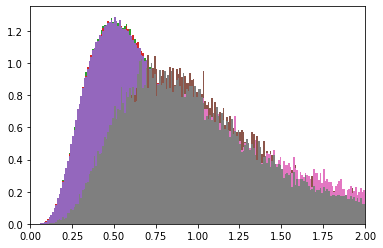

In [49]:
for in_file, out_file_waic, out_file_justloss, sigbit_flag, is_sig, n_prong in zip(inputlist,outputlist_waic,outputlist_justloss,exist_signalflag,is_signal, nprong):    
    
    f_bb = pd.read_hdf(in_file)
3
    model.eval()
    #huberloss = nn.SmoothL1Loss(reduction='none')
    sigae_bbloss = torch.mean((model(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    bbvar = torch.var((model(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()
    waic = sigae_bbloss + bbvar
    #sigae_bbloss = torch.mean(huberloss(model(total_bb_test.float().cuda())[0],total_bb_test.float().cuda()),dim=1).data.cpu().numpy()
    print(waic[0:10])
    plt.hist(waic,bins=np.linspace(0,10,1001),density=True);
    plt.xlim([0,2])
    np.save(out_file_waic,waic)
    np.save(out_file_justloss,sigae_bbloss)

In [50]:
bkg_mean

[229.63703733315916,
 0.5040889514020693,
 0.7057013083107537,
 0.7997482828680078,
 1.962088799505638,
 255.28311110430732,
 104.75378636669201,
 0.5826962213587913,
 0.7337977883611374,
 0.7995755223103627,
 2.4171146383976034,
 159.75951298419648]

In [51]:
bkg_std

[131.99460164832075,
 0.1849760683347428,
 0.12816197632833803,
 0.0865553075423761,
 0.7978444985340304,
 111.36202699158525,
 68.17314726646633,
 0.17458368821556094,
 0.11581000682757887,
 0.08481896882883566,
 1.1084488583498446,
 83.52566008451547]

In [52]:
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb1.npy",
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb2.npy",
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_bb3.npy",
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_purebkg.npy",
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_WAICloss_rndbkg.npy",

('../data_strings/bkg_rndbkg_12features_mjjcut_MSELoss_beta1_z8f1_WAICloss_rndbkg.npy',)

In [53]:
loss_prong3 = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_3prong.npy")
loss_prong2 = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_2prong.npy")
loss_purebkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_purebkg.npy")
loss_rndbkg = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_rndbkg.npy")
loss_4500 = np.load(f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_4500.npy")



In [54]:
f"../data_strings/{ae_def['type']}_{ae_def['trainon']}_{ae_def['features']}_{ae_def['selection']}_{ae_def['trainloss']}_{ae_def['beta']}_{ae_def['zdimnflow']}_Justloss_4500.npy"

'../data_strings/bkg_rndbkg_12features_mjjcut_MSELoss_beta1_z8f1_Justloss_4500.npy'

In [55]:
ae_def

{'type': 'bkg',
 'trainon': 'rndbkg',
 'features': '12features',
 'architecture': 'MAF',
 'selection': 'mjjcut',
 'trainloss': 'MSELoss',
 'beta': 'beta1',
 'zdimnflow': 'z8f1'}

In [56]:
loss_4500

array([0.500607  , 0.45028985, 0.5987567 , ..., 0.6106272 , 0.58294433,
       0.550126  ], dtype=float32)

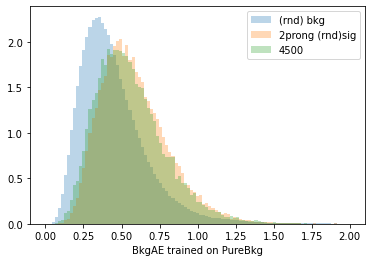

In [71]:
#plt.hist(loss_purebkg,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='Pure Bkg');
plt.hist(loss_rndbkg,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='(rnd) bkg');

plt.hist(loss_prong2,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='2prong (rnd)sig');
#plt.hist(loss_prong3,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='3prong (rnd)sig');
plt.hist(loss_4500,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='4500');

#plt.yscale('log')
plt.xlabel('BkgAE trained on PureBkg')
plt.legend(loc='upper right')
#plt.savefig('bkgae_trained_on_purebkg_withmass_turnonselection.png')

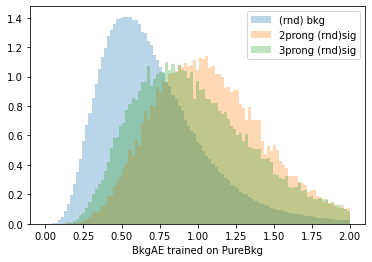

In [94]:
#plt.hist(loss_purebkg,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='Pure Bkg');
plt.hist(loss_rndbkg,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='(rnd) bkg');

plt.hist(loss_prong2,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='2prong (rnd)sig');
plt.hist(loss_prong3,bins=np.linspace(0,2,100),density=True,alpha=0.3,label='3prong (rnd)sig');
#plt.yscale('log')
plt.xlabel('BkgAE trained on PureBkg')
plt.legend(loc='upper right')
#plt.savefig('bkgae_trained_on_purebkg_withmass_turnonselection.png')

In [64]:
def reconstruct(X):
    out = model(torch.tensor(X[:100000]).float().cuda())[0]
    out = out.data.cpu().numpy()
    return out

In [65]:
out = reconstruct(Y)

In [66]:
out.shape

(100000, 12)

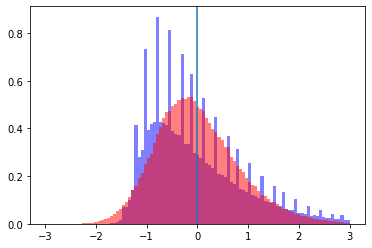

In [78]:
bins = np.linspace(-3,3,100)
bins.shape
column = 11
#print(df.coluns[column])
plt.hist(Y[:,column],bins,density=True,alpha=0.5,color='b');
plt.hist(out[:,column],bins,density=True,alpha=0.5,color='r');
plt.axvline(np.mean(Y[:,column]))

In [ ]:
f_bb = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5')

In [ ]:
dt = f_bb.values

In [ ]:
correct = (dt[:,3]>0) &(dt[:,19]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]
    
for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])
        
        
correct = (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]
Y = dt[:,[3,4,5,6,11,12,13,14,15,16,17,18,19,20,21,22,27,28,29,30,31,32,33,34]]

In [ ]:
Y.shape

In [ ]:
idx = dt[:,-1]
sigidx = idx == 1
bkgidx = idx == 0

In [ ]:
for i in range(24):
    Y[:,i] = (Y[:,i]-bkg_mean[i])/bkg_std[i]

In [ ]:
Y = Y[sigidx]

In [ ]:
#correct = Y[:,0] > 300 #(For 2prong)
correct = Y[:,0] > 400 # (for 3prong)

In [ ]:
Y = Y[correct]

In [ ]:
Y.shape

In [ ]:
plt.hist(Y[:,0],bins=np.linspace(0,1000,1001));

In [ ]:
np.mean(Y[:,0])

In [ ]:
total_bb_test = torch.tensor(Y)
bkgae_bbloss = torch.mean((model(total_bb_test.float().cuda())[0]- total_bb_test.float().cuda())**2,dim=1).data.cpu().numpy()

In [ ]:
bkgae_bbloss

In [ ]:
plt.hist(bkgae_bbloss,bins=np.linspace(0,10,1001));

In [ ]:
np.save('../data_strings/bkgae_rndbkg_loss_3prong.npy',bkgae_bbloss)

In [ ]:
loss_prong3 = np.load('../data_strings/bkgae_purebkg_loss_3prong.npy')
loss_prong2 = np.load('../data_strings/bkgae_purebkg_loss_2prong.npy')
loss_purebkg = np.load('../data_strings/bkgae_purebkg_loss_purebkg.npy')
loss_rndbkg = np.load('../data_strings/bkgae_purebkg_loss_rndbkg.npy')

In [ ]:
len(loss_purebkg)

In [ ]:
len(loss_prong2)

In [ ]:
plt.hist(loss_purebkg,bins=np.linspace(0,10,100),weights=np.ones(len(loss_purebkg)),alpha=0.3,label='Pure Bkg');
plt.hist(loss_rndbkg,bins=np.linspace(0,10,100),weights=np.ones(len(loss_rndbkg))*(len(loss_purebkg)/len(loss_rndbkg)),alpha=0.3,label='(rnd) bkg');

#plt.hist(loss_prong3,bins=np.linspace(0,2,100),weights=np.ones(len(loss_prong3))*(len(loss_purebkg)/len(loss_prong3)),alpha=0.3,label='2prong (rnd)sig');
#plt.hist(loss_prong2,bins=np.linspace(0,2,100),weights=np.ones(len(loss_prong2))*(len(loss_purebkg)/len(loss_prong2)),alpha=0.3,label='3prong (rnd)sig');
plt.yscale('log')
plt.xlabel('BkgAE trained on Pure Bkg')
plt.legend(loc='upper right')
plt.savefig('bkgae_trained_on_pure_bkg_onlybkg.png')

In [ ]:
def get_loss(dt):
    
    def generator(dt, chunk_size=5000, total_size=1000000):

        i = 0
        i_max = total_size // chunk_size
        print(i_max)
    
        for i in range(i_max):
            start=i * chunk_size
            stop=(i + 1) * chunk_size
            yield torch.tensor(dt[start:stop])
        
    loss = []

    
    with torch.no_grad():
        
        for total_in_selection in generator(dt,chunk_size=5000, total_size=1000000):
            loss.extend(torch.mean((model(total_in_selection.float().cuda())[0]- total_in_selection.float().cuda())**2,dim=1).data.cpu().numpy())
    
    return loss

In [ ]:
bb1_loss_bkg = get_loss(X_bb1)

In [ ]:
bb1_loss_bkg = np.array(bb1_loss_bkg,dtype=np.float)

In [ ]:
bb1_loss_bkg

In [ ]:
plt.hist(bb1_loss_bkg,bins=np.linspace(0,5,1001));

In [ ]:
np.save('../data_strings/bkgaeloss_bb1.npy',bb1_loss_bkg)

In [ ]:
f_bb2 = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5')
dt_bb2 = f_bb2.values

In [ ]:
X_bb2 = dt_bb2[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [ ]:
for i in range(12):
    X_bb2[:,i] = (X_bb2[:,i]-bkg_mean[i])/bkg_std[i]

In [ ]:
bb2_loss_bkg = get_loss(X_bb2)

In [ ]:
bb2_loss_bkg = np.array(bb2_loss_bkg,dtype=np.float)

In [ ]:
plt.hist(bb2_loss_bkg,bins=np.linspace(0,5,1001));

In [ ]:
f_bb3 = pd.read_hdf('/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5')
dt_bb3 = f_bb3.values

In [ ]:
X_bb3 = dt_bb3[:,[3,4,5,6,11,12,19,20,21,22,27,28]]

In [ ]:
for i in range(12):
    X_bb3[:,i] = (X_bb3[:,i]-bkg_mean[i])/bkg_std[i]

In [ ]:
bb3_loss_bkg = get_loss(X_bb3)

In [ ]:
bb3_loss_bkg = np.array(bb3_loss_bkg,dtype=np.float)

In [ ]:
bb3_loss_bkg

In [ ]:
plt.hist(bb3_loss_bkg,bins=np.linspace(0,5,1001));

In [ ]:
np.save('../data_strings/bkgaeloss_bb2.npy',bb2_loss_bkg)

In [ ]:
np.save('../data_strings/bkgaeloss_bb3.npy',bb3_loss_bkg)

In [ ]:
X[signal_idx].shape

In [ ]:
loss_bkg = get_loss(X[bkg_idx])
loss_sig = get_loss(X[signal_idx])

In [ ]:
plt.rcParams["figure.figsize"] = (10,10)
bins = np.linspace(0,0.5,1100)
plt.hist(loss_bkg,bins=bins,alpha=0.3,color='b',label='bkg')
plt.hist(loss_sig,bins=bins,alpha=0.3,color='r',label='sig')
plt.xlabel(r'Autoencoder Loss')
plt.ylabel('Count')
plt.legend(loc='upper right')
plt.show()

In [ ]:
def get_tpr_fpr(sigloss,bkgloss,aetype='sig'):
    bins = np.linspace(0,50,1001)
    tpr = []
    fpr = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss<cut)[0].shape[0]/len(bkgloss))
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            fpr.append(np.where(bkgloss>cut)[0].shape[0]/len(bkgloss))
    return tpr,fpr        

In [ ]:
bkg_tpr, bkg_fpr = get_tpr_fpr(loss_sig,loss_bkg,aetype='bkg')

In [ ]:
np.save('NFLOWVAE_PlanarNEW_bkgAE_fpr.npy',bkg_fpr)
np.save('NFLOWVAE_PlanarNEW_bkgAE_tpr.npy',bkg_tpr)

In [ ]:
plt.plot(bkg_fpr,bkg_tpr,label='Bkg NFlowVAE-Planar')


In [ ]:
def get_precision_recall(sigloss,bkgloss,aetype='bkg'):
    bins = np.linspace(0,100,1001)
    tpr = []
    fpr = []
    precision = []
    for cut in bins:
        if aetype == 'sig':
            tpr.append(np.where(sigloss<cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss<cut)[0].shape[0])/(np.where(bkgloss<cut)[0].shape[0]+np.where(sigloss<cut)[0].shape[0]))
            
        if aetype == 'bkg':
            tpr.append(np.where(sigloss>cut)[0].shape[0]/len(sigloss))
            precision.append((np.where(sigloss>cut)[0].shape[0])/(np.where(bkgloss>cut)[0].shape[0]+np.where(sigloss>cut)[0].shape[0]))
    return precision,tpr      

In [ ]:
precision,recall = get_precision_recall(loss_sig,loss_bkg,aetype='bkg')

In [ ]:
np.save('NFLOWVAE_PlanarNEW_22var_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_22var_bkgloss.npy',loss_bkg)

In [ ]:
np.save('NFLOWVAE_PlanarNEW_precision.npy',precision)
np.save('NFLOWVAE_PlanarNEW_recall.npy',recall)
np.save('NFLOWVAE_PlanarNEW_bkgAE_fpr.npy',bkg_fpr)
np.save('NFLOWVAE_PlanarNEW_bkgAE_tpr.npy',bkg_tpr)
np.save('NFLOWVAE_PlanarNEW_sigloss.npy',loss_sig)
np.save('NFLOWVAE_PlanarNEW_bkgloss.npy',loss_bkg)

In [ ]:
plt.plot(recall,precision)

In [ ]:
flows = [1,2,3,4,5,6]
zdim = [1,2,3,4,5]

for N_flows in flows:
    for Z_DIM in zdim:
        model = VAE_NF(N_FLOWS, Z_DIM).cuda()
        optimizer = optim.Adam(model.parameters(), lr=LR)
        BEST_LOSS = 99999
        LAST_SAVED = -1
        PATIENCE_COUNT = 0
        PATIENCE_LIMIT = 5
        for epoch in range(1, N_EPOCHS):
            print("Epoch {}:".format(epoch))
            train()
            cur_loss = evaluate()

            if cur_loss <= BEST_LOSS:
                PATIENCE_COUNT = 0
                BEST_LOSS = cur_loss
                LAST_SAVED = epoch
                print("Saving model!")
                if mode == 'ROC':
                    torch.save(model.state_dict(),f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_RND_22var_z{Z_DIM}_f{N_FLOWS}.h5")
                else:
                    torch.save(model.state_dict(), f"/data/t3home000/spark/QUASAR/weights/bkg_vae_NF_planar_PureBkg_22var_z{Z_DIM}_f{N_FLOWS}.h5")
            else:
                PATIENCE_COUNT += 1
                print("Not saving model! Last saved: {}".format(LAST_SAVED))
                if PATIENCE_COUNT > 3:
                    print("Patience Limit Reached")
                    break 
                    
        loss_bkg = get_loss(dt_PureBkg[bkg_idx])
        loss_sig = get_loss(dt_PureBkg[signal_idx])
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_sigloss.npy',loss_sig)
        np.save(f'NFLOWVAE_PlanarNEW_22var_z{Z_DIM}_f{N_flows}_bkgloss.npy',loss_bkg)